# Module 4 Final Project - Time Series and Zillow Dataset
* Student name: Krystian Dennis
* Student pace: Full Time
* Scheduled project review date/time: 19 September 2019 14:00pm
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Business Understanding 

Aries Real Estate Investors buys and rehabs homes in high-growth urban areas. Homes are purchased to be renovated and sold (or flipped). Properties held longer than 30 days past end of renovation are rented for 3-5 years, then re-entered into the housing market. Aries is looking to expand its offering to buyers with a wider range of budgets to capture more market share. To make sure that new areas of investment are ideal, 5 zipcodes have been identified using the following criteria:

* Zipcodes are located in the Top 5 in 2019 Market rankings for Overall Real Estate Prospects according to Price Waterhouse Cooper's Emerging Trends in Real Estate 2019 Report
* Areas have demonstrated 30% or greater Return On Investment in the last 10 years
* Risk has been mitigated by selecting zipcodes in several geographical areas
* Price and return dispersion (measured by coefficient of variation) kept to minimum to lower risk

# Zillow Dataset

Zillow is a top real estate marketplace that has a dedicated research team to provide accurate housing data and unbiased insights to home buyers and home sellers alike. The dataset contains historical sales price data back to 1996 for the United States. 

# Import Libraries

In [1]:
import pandas as pd
from pandas import Series

import numpy as np

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    print(dfoutput)

In [3]:
def test_stationarity(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='#87CEEB',label='Original')
    mean = plt.plot(rolmean, color='#FFC0CB', label='Rolling Mean')
    std = plt.plot(rolstd, color='#008000', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

## Import and Explore Data

In [4]:
df = pd.read_csv("zillow_data.csv")
display(df.head())
display(df.info())
display(round(df.describe(),2))
np.shape(df)

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


None

RegionID  RegionName  SizeRank     1996-04     1996-05     1996-06  \
count   14723.00    14723.00  14723.00    13684.00    13684.00    13684.00   
mean    81075.01    48222.35   7362.00   118299.12   118419.04   118537.42   
std     31934.12    29359.33   4250.31    86002.51    86155.67    86309.23   
min     58196.00     1001.00      1.00    11300.00    11500.00    11600.00   
25%     67174.50    22101.50   3681.50    68800.00    68900.00    69100.00   
50%     78007.00    46106.00   7362.00    99500.00    99500.00    99700.00   
75%     90920.50    75205.50  11042.50   143200.00   143300.00   143225.00   
max    753844.00    99901.00  14723.00  3676700.00  3704200.00  3729600.00   

          1996-07     1996-08     1996-09     1996-10     ...       \
count    13684.00    13684.00    13684.00    13684.00     ...        
mean    118653.07   118780.25   118927.53   119120.52     ...        
std      86467.95    86650.94    86872.08    87151.85     ...        
min      11800.00    11800.00    12000.00    12100.00     ...        
25%      69200.00    69375.00    69500.00    69600.00     ...        
50%      99700.00    99800.00    99900.00    99950.00     ...        
75%     143225.00   143500.00   143700.00   143900.00     ...        
max    3754600.00  3781800.00  3813500.00  3849600.00     ...        

           2017-07      2017-08      2017-09      2017-10      2017-11  \
count     14723.00     14723.00     14723.00     14723.00     14723.00   
mean     273335.39    274865.77    276464.62    278033.19    279520.86   
std      360398.42    361467.76    362756.27    364460.95    365600.33   
min       14400.00     14500.00     14700.00     14800.00     14500.00   
25%      126900.00    127500.00    128200.00    128700.00    129250.00   
50%      188400.00    189600.00    190500.00    191400.00    192500.00   
75%      305000.00    306650.00    308500.00    309800.00    311700.00   
max    18889900.00  18703500.00  18605300.00  18569400.00  18428800.00   

           2017-12      2018-01      2018-02      2018-03      2018-04  
count     14723.00     14723.00     14723.00     14723.00     14723.00  
mean     281095.32    282657.06    284368.69    286511.38    288039.94  
std      367045.39    369572.74    371773.91    372461.23    372054.40  
min       14300.00     14100.00     13900.00     13800.00     13800.00  
25%      129900.00    130600.00    131050.00    131950.00    132400.00  
50%      193400.00    194100.00    195000.00    196700.00    198100.00  
75%      313400.00    315100.00    316850.00    318850.00    321100.00  
max    18307100.00  18365900.00  18530400.00  18337700.00  17894900.00  

[8 rows x 268 columns]

(14723, 272)

In [5]:
df.isnull().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
              ... 
2015-11          0
2015-12          0
2016-01          0
2016-02          0
2016-03          0
2016-04          0
2016-05          0
2016-06          0
2016-07          0
2016-08          0
2016-09          0
2016-10          0
2016-11          0
2016-12          0
2017-01          0
2017-02          0
2017-03          0
2017-04          0
2017-05          0
2017-06          0
2017-07          0
2017-08     

In [6]:
#backfill missing data
df = df.fillna(df.ffill())

In [7]:
df.isnull().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
1996-04       0
1996-05       0
1996-06       0
1996-07       0
1996-08       0
1996-09       0
1996-10       0
1996-11       0
1996-12       0
1997-01       0
1997-02       0
1997-03       0
1997-04       0
1997-05       0
1997-06       0
1997-07       0
1997-08       0
1997-09       0
1997-10       0
1997-11       0
1997-12       0
1998-01       0
1998-02       0
             ..
2015-11       0
2015-12       0
2016-01       0
2016-02       0
2016-03       0
2016-04       0
2016-05       0
2016-06       0
2016-07       0
2016-08       0
2016-09       0
2016-10       0
2016-11       0
2016-12       0
2017-01       0
2017-02       0
2017-03       0
2017-04       0
2017-05       0
2017-06       0
2017-07       0
2017-08       0
2017-09       0
2017-10       0
2017-11       0
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int6

## EDA and Visualization

In [8]:
#calculate ROI
df['ROI'] = ((df['2018-04']-df['1996-04'])/df['1996-04'])
df['ROI 10 YR'] = ((df['2018-04']-df['2008-04'])/df['2008-04'])
df['% Growth 10 YR'] = ((df['2018-04']-df['2008-04'])/df['2008-04'])*100
#using std, coefficient of variation as a measure of volatility and risk
#smaller coefficient of variation = smaller risk
df['Risk'] = df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)/df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

In [9]:
df_risk = df.Risk.quantile(.6)
df = df[df['Risk'] < df_risk].sort_values(by='ROI 10 YR',axis=0, ascending = False)

In [10]:
#rename RegionName to ZipCode
df.rename(columns={'RegionName':'ZipCode'}, inplace=True)
df.reset_index(drop=True)
df['ZipCode']=df['ZipCode'].astype(str)

In [11]:
#create Dallas-Fort Worth dataframe
dallas_fort_worth = df.loc[(df['Metro']=='Dallas-Fort Worth')].sort_values(by='ROI 10 YR',axis=0, ascending = False)[:5]
dallas_fort_worth

RegionID ZipCode            City State              Metro CountyName  \
3845     90770   75218          Dallas    TX  Dallas-Fort Worth     Dallas   
820      90675   75080      Richardson    TX  Dallas-Fort Worth     Dallas   
3157     90786   75234  Farmers Branch    TX  Dallas-Fort Worth     Dallas   
1964     90676   75081      Richardson    TX  Dallas-Fort Worth     Dallas   
5323     90787   75235          Dallas    TX  Dallas-Fort Worth     Dallas   

      SizeRank   1996-04   1996-05   1996-06    ...     2017-11  2017-12  \
3845      3846  159900.0  160500.0  160700.0    ...      347000   347100   
820        821  133300.0  133000.0  132600.0    ...      298100   300700   
3157      3158   91100.0   91000.0   90900.0    ...      221300   224100   
1964      1965  121500.0  121600.0  121800.0    ...      262200   261900   
5323      5324   61300.0   61600.0   62000.0    ...      176200   176200   

      2018-01  2018-02  2018-03  2018-04       ROI  ROI 10 YR  % Growth 10 YR  \
3845   350900   354600   356600   358100  1.239525   0.830777       83.077710   
820    303600   305700   307500   308900  1.317329   0.785549       78.554913   
3157   228700   232100   233600   234000  1.568606   0.767372       76.737160   
1964   262800   264100   265600   267100  1.198354   0.737801       73.780091   
5323   177200   178200   176800   174700  1.849918   0.734856       73.485601   

          Risk  
3845  0.231909  
820   0.226112  
3157  0.218109  
1964  0.203133  
5323  0.239466  

[5 rows x 276 columns]

In [12]:
#create Brooklyn. no zipcodes with acceptable risk (variation .5 or below)
brooklyn = df.loc[(df['CountyName']=='Kings')&(df['State']=='NY')].sort_values(by='ROI 10 YR',axis=0, ascending = False)[:5]
brooklyn

Empty DataFrame
Columns: [RegionID, ZipCode, City, State, Metro, CountyName, SizeRank, 1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 2000-05, 2000-06, 2000-07, 2000-08, 2000-09, 2000-10, 2000-11, 2000-12, 2001-01, 2001-02, 2001-03, 2001-04, 2001-05, 2001-06, 2001-07, 2001-08, 2001-09, 2001-10, 2001-11, 2001-12, 2002-01, 2002-02, 2002-03, 2002-04, 2002-05, 2002-06, 2002-07, 2002-08, 2002-09, 2002-10, 2002-11, 2002-12, 2003-01, 2003-02, 2003-03, 2003-04, 2003-05, 2003-06, 2003-07, 2003-08, 2003-09, 2003-10, 2003-11, 2003-12, ...]
Index: []

[0 rows x 276 columns]

In [13]:
#create Orlando. no zipcodes with acceptable risk (variation .5 or below)
orlando = df.loc[(df['City']=='Orlando')&(df['State']=='FL')].sort_values(by='ROI 10 YR',axis=0, ascending = False)[:5]
orlando.head()

Empty DataFrame
Columns: [RegionID, ZipCode, City, State, Metro, CountyName, SizeRank, 1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 2000-05, 2000-06, 2000-07, 2000-08, 2000-09, 2000-10, 2000-11, 2000-12, 2001-01, 2001-02, 2001-03, 2001-04, 2001-05, 2001-06, 2001-07, 2001-08, 2001-09, 2001-10, 2001-11, 2001-12, 2002-01, 2002-02, 2002-03, 2002-04, 2002-05, 2002-06, 2002-07, 2002-08, 2002-09, 2002-10, 2002-11, 2002-12, 2003-01, 2003-02, 2003-03, 2003-04, 2003-05, 2003-06, 2003-07, 2003-08, 2003-09, 2003-10, 2003-11, 2003-12, ...]
Index: []

[0 rows x 276 columns]

In [14]:
#create Raleigh-Durham
raleigh = df.loc[(df['City']=='Raleigh')&(df['State']=='NC')]
durham = df.loc[(df['City']=='Durham')&(df['State']=='NC')]
raleigh_durham = pd.concat([raleigh,durham], axis = 0)
raleigh_durham = raleigh_durham.sort_values(by='ROI 10 YR',axis=0, ascending = False)[:5]
raleigh_durham

RegionID ZipCode     City State    Metro CountyName  SizeRank   1996-04  \
355      69491   27707   Durham    NC   Durham     Durham       356  105000.0   
1151     69449   27609  Raleigh    NC  Raleigh       Wake      1152  140800.0   
417      69489   27705   Durham    NC   Durham     Durham       418  112800.0   
1857     69488   27704   Durham    NC   Durham     Durham      1858   84900.0   
4719     69447   27607  Raleigh    NC  Raleigh       Wake      4720  162800.0   

       1996-05   1996-06    ...     2017-11  2017-12  2018-01  2018-02  \
355   105400.0  106100.0    ...      229500   231900   234000   235400   
1151  141500.0  142200.0    ...      318500   319700   320900   322700   
417   113400.0  114400.0    ...      261900   262800   264100   265600   
1857   85300.0   85800.0    ...      157400   159300   161200   162400   
4719  163400.0  164000.0    ...      397800   400700   401900   403100   

      2018-03  2018-04       ROI  ROI 10 YR  % Growth 10 YR      Risk  
355    236800   238300  1.269524   0.426092       42.609216  0.169501  
1151   325800   328300  1.331676   0.424295       42.429501  0.218422  
417    268100   270200  1.395390   0.413919       41.391941  0.194705  
1857   163500   164600  0.938751   0.315747       31.574740  0.122997  
4719   405100   406400  1.496314   0.310123       31.012250  0.219050  

[5 rows x 276 columns]

In [15]:
#create Nashville
nashville = df.loc[(df['City']=='Nashville')&(df['State']=='TN')].sort_values(by='ROI 10 YR',axis=0, ascending = False)
nashville

RegionID ZipCode       City State      Metro CountyName  SizeRank  \
17       74242   37211  Nashville    TN  Nashville   Davidson        18   
2005     74245   37214  Nashville    TN  Nashville   Davidson      2006   
2323     74248   37217  Nashville    TN  Nashville   Davidson      2324   
1225     74178   37115  Nashville    TN  Nashville   Davidson      1226   
4617     74195   37138  Nashville    TN  Nashville   Davidson      4618   

       1996-04   1996-05   1996-06    ...     2017-11  2017-12  2018-01  \
17     97900.0   98000.0   98200.0    ...      251100   253900   256500   
2005   88300.0   88400.0   88500.0    ...      217100   218100   219900   
2323   96000.0   96200.0   96500.0    ...      200500   202700   205000   
1225   79700.0   79800.0   79900.0    ...      180000   181700   183900   
4617  104000.0  104400.0  105000.0    ...      223100   224800   226500   

      2018-02  2018-03  2018-04       ROI  ROI 10 YR  % Growth 10 YR      Risk  
17     259000   262100   264200  1.698672   0.686024       68.602425  0.247623  
2005   221800   224400   226600  1.566251   0.620887       62.088698  0.216641  
2323   207500   210700   213000  1.218750   0.531272       53.127247  0.177759  
1225   186000   188300   189800  1.381430   0.526951       52.695093  0.205418  
4617   228400   230800   232400  1.234615   0.469956       46.995572  0.181321  

[5 rows x 276 columns]

In [16]:
#brooklyn and orlando eliminated due to high risk

In [17]:
dallas_fort_worth.drop(['ROI 10 YR','City','% Growth 10 YR','Risk','CountyName','ROI','Risk','RegionID','SizeRank','State','Metro'], axis=1, inplace=True)
dallas_fort_worth

ZipCode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
3845   75218  159900.0  160500.0  160700.0  160500.0  160200.0  159800.0   
820    75080  133300.0  133000.0  132600.0  132300.0  132000.0  131800.0   
3157   75234   91100.0   91000.0   90900.0   90700.0   90600.0   90500.0   
1964   75081  121500.0  121600.0  121800.0  122000.0  122300.0  122500.0   
5323   75235   61300.0   61600.0   62000.0   62400.0   62700.0   63000.0   

       1996-10   1996-11   1996-12   ...     2017-07  2017-08  2017-09  \
3845  159400.0  158900.0  158700.0   ...      349600   349600   349900   
820   131700.0  131700.0  131700.0   ...      290200   292000   293900   
3157   90400.0   90400.0   90400.0   ...      213300   216600   219100   
1964  122700.0  122900.0  123100.0   ...      257700   259600   261800   
5323   63300.0   63500.0   63800.0   ...      157200   163000   170600   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
3845   349600   347000   347100   350900   354600   356600   358100  
820    295900   298100   300700   303600   305700   307500   308900  
3157   220200   221300   224100   228700   232100   233600   234000  
1964   263100   262200   261900   262800   264100   265600   267100  
5323   175100   176200   176200   177200   178200   176800   174700  

[5 rows x 266 columns]

In [18]:
raleigh_durham.drop(['ROI 10 YR','City','% Growth 10 YR','Risk','CountyName','ROI','Risk','RegionID','SizeRank','State','Metro'], axis=1, inplace=True)
raleigh_durham

ZipCode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
355    27707  105000.0  105400.0  106100.0  107200.0  108500.0  110100.0   
1151   27609  140800.0  141500.0  142200.0  143100.0  144000.0  145000.0   
417    27705  112800.0  113400.0  114400.0  115700.0  117300.0  118900.0   
1857   27704   84900.0   85300.0   85800.0   86500.0   87300.0   88300.0   
4719   27607  162800.0  163400.0  164000.0  164800.0  165700.0  166700.0   

       1996-10   1996-11   1996-12   ...     2017-07  2017-08  2017-09  \
355   111800.0  113500.0  115100.0   ...      222800   225300   227100   
1151  146000.0  146900.0  147900.0   ...      313000   313900   315700   
417   120700.0  122600.0  124200.0   ...      255600   258800   261400   
1857   89600.0   91000.0   92400.0   ...      149800   152000   154200   
4719  168000.0  169400.0  171000.0   ...      387600   389500   391500   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
355    228200   229500   231900   234000   235400   236800   238300  
1151   317500   318500   319700   320900   322700   325800   328300  
417    261900   261900   262800   264100   265600   268100   270200  
1857   155900   157400   159300   161200   162400   163500   164600  
4719   394500   397800   400700   401900   403100   405100   406400  

[5 rows x 266 columns]

In [19]:
nashville.drop(['ROI 10 YR','City','% Growth 10 YR','Risk','CountyName','ROI','Risk','RegionID','SizeRank','State','Metro'], axis=1, inplace=True)
nashville

ZipCode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
17     37211   97900.0   98000.0   98200.0   98400.0   98700.0   99000.0   
2005   37214   88300.0   88400.0   88500.0   88700.0   88800.0   89000.0   
2323   37217   96000.0   96200.0   96500.0   96800.0   97000.0   97300.0   
1225   37115   79700.0   79800.0   79900.0   80100.0   80400.0   80600.0   
4617   37138  104000.0  104400.0  105000.0  105600.0  106200.0  106800.0   

       1996-10   1996-11   1996-12   ...     2017-07  2017-08  2017-09  \
17     99400.0   99900.0  100500.0   ...      243100   245000   246700   
2005   89300.0   89700.0   90200.0   ...      206400   209300   212900   
2323   97700.0   98200.0   98700.0   ...      194000   195600   197000   
1225   80900.0   81200.0   81600.0   ...      170800   173000   175600   
4617  107400.0  108100.0  108700.0   ...      215900   217500   219500   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
17     248800   251100   253900   256500   259000   262100   264200  
2005   215800   217100   218100   219900   221800   224400   226600  
2323   198700   200500   202700   205000   207500   210700   213000  
1225   178100   180000   181700   183900   186000   188300   189800  
4617   221500   223100   224800   226500   228400   230800   232400  

[5 rows x 266 columns]

In [20]:
#melt - wide to long format
dfw = dallas_fort_worth.transpose()
new_header=dfw.iloc[0] ##grab all first row data for the column headers
dfw=dfw[1:] ## take all rows after first row
dfw.columns=new_header ## assign all column headers to be equal to row 0 data
dfw.index=pd.to_datetime(dfw.index)
dfw.reset_index()
dfw=dfw.astype(int)
dfw.head()

ZipCode      75218   75080  75234   75081  75235
1996-04-01  159900  133300  91100  121500  61300
1996-05-01  160500  133000  91000  121600  61600
1996-06-01  160700  132600  90900  121800  62000
1996-07-01  160500  132300  90700  122000  62400
1996-08-01  160200  132000  90600  122300  62700

Text(0, 0.5, 'Home Price ($)\n')

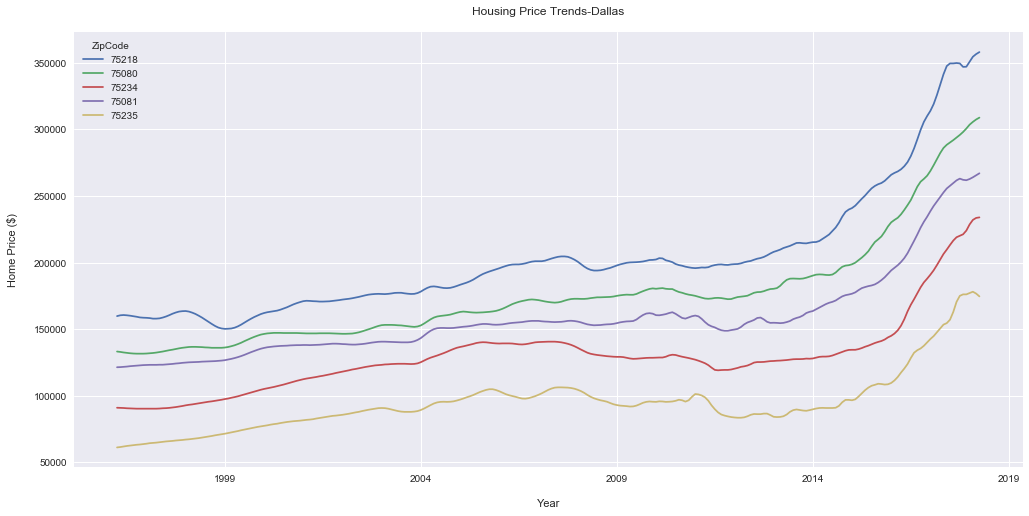

In [21]:
dfw.plot(figsize=(17,8))
plt.title("Housing Price Trends-Dallas\n")
plt.xlabel('\nYear')
plt.ylabel('Home Price ($)\n')

In [22]:
rdu = raleigh_durham.transpose()
new_header=rdu.iloc[0] ##grab all first row data for the column headers
rdu=rdu[1:] ## take all rows after first row
rdu.columns=new_header ## assign all column headers to be equal to row 0 data
rdu.index=pd.to_datetime(rdu.index)
rdu.reset_index()
rdu=rdu.astype(int)
rdu.head()

ZipCode      27707   27609   27705  27704   27607
1996-04-01  105000  140800  112800  84900  162800
1996-05-01  105400  141500  113400  85300  163400
1996-06-01  106100  142200  114400  85800  164000
1996-07-01  107200  143100  115700  86500  164800
1996-08-01  108500  144000  117300  87300  165700

Text(0, 0.5, 'Home Price ($)\n')

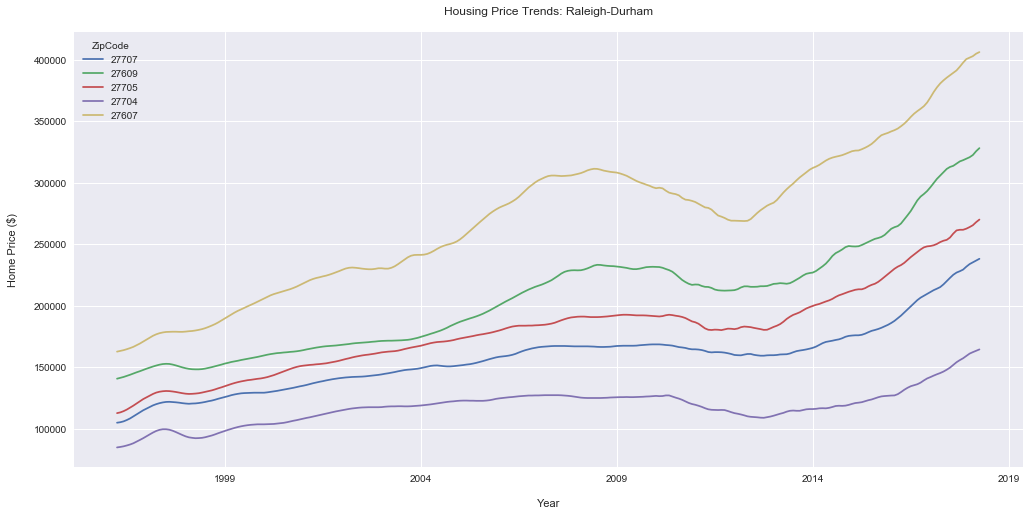

In [23]:
rdu.plot(figsize=(17,8))
plt.title("Housing Price Trends: Raleigh-Durham\n")
plt.xlabel('\nYear')
plt.ylabel('Home Price ($)\n')

In [24]:
nash = nashville.transpose()
new_header=nash.iloc[0] ##grab all first row data for the column headers
nash=nash[1:] ## take all rows after first row
nash.columns=new_header ## assign all column headers to be equal to row 0 data
nash.index=pd.to_datetime(nash.index)
nash.reset_index()
nash=nash.astype(int)
nash.head()

ZipCode     37211  37214  37217  37115   37138
1996-04-01  97900  88300  96000  79700  104000
1996-05-01  98000  88400  96200  79800  104400
1996-06-01  98200  88500  96500  79900  105000
1996-07-01  98400  88700  96800  80100  105600
1996-08-01  98700  88800  97000  80400  106200

Text(0, 0.5, 'Home Price ($)\n')

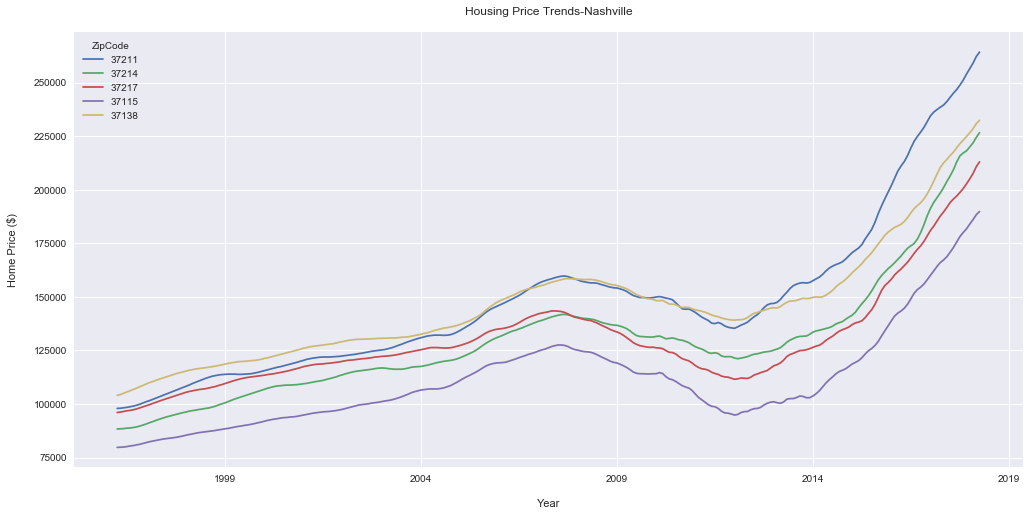

In [25]:
nash.plot(figsize=(17,8))
plt.title("Housing Price Trends-Nashville\n")
plt.xlabel('\nYear')
plt.ylabel('Home Price ($)\n')

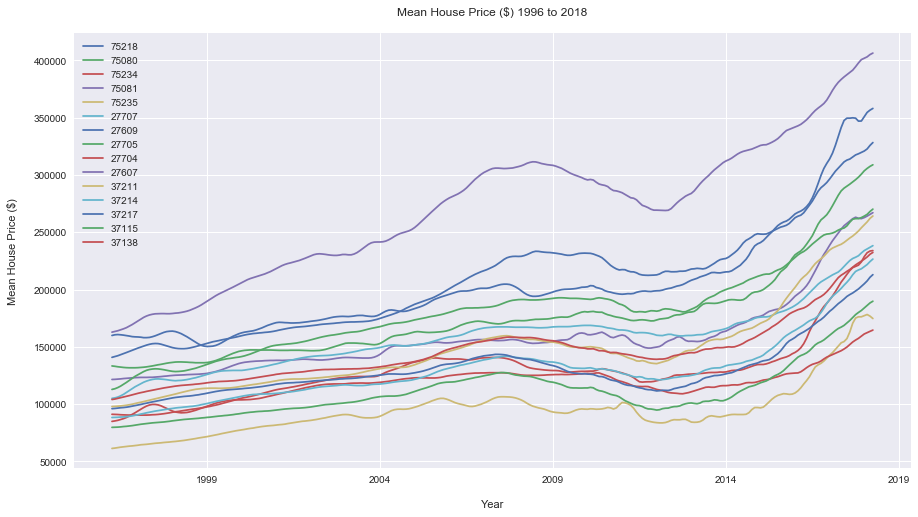

In [26]:
#visualize average house prices for all markets
ax = dfw.plot(label='Dallas-Fort Worth', figsize=(15,8))
rdu.plot(ax=ax, label='Raleigh-Durham')
nash.plot(ax=ax, label='Nashville')
plt.legend()
plt.title('Mean House Price ($) 1996 to 2018\n')
plt.ylabel('Mean House Price ($)\n')
plt.xlabel('\nYear')
plt.show()

In [27]:
#only including data for last 10 years and Great Recession of 2008
dfw=dfw[141:]
rdu=rdu[141:]
nash=nash[141:]
display(dfw.head())
display(rdu.head())
nash.head()

ZipCode      75218   75080   75234   75081   75235
2008-01-01  200800  172900  136100  155800  104600
2008-02-01  198900  172800  134800  155200  103600
2008-03-01  197100  172800  133600  154400  102300
2008-04-01  195600  173000  132400  153700  100700
2008-05-01  194600  173400  131600  153300   99300

ZipCode      27707   27609   27705   27704   27607
2008-01-01  167100  228900  191200  125800  307300
2008-02-01  167100  229000  191300  125400  308000
2008-03-01  167100  229600  191300  125200  309000
2008-04-01  167100  230500  191100  125100  310200
2008-05-01  167000  231600  190900  125100  311000

ZipCode      37211   37214   37217   37115   37138
2008-01-01  157900  140500  140200  125100  158200
2008-02-01  157300  140100  139800  124700  158100
2008-03-01  157000  139900  139400  124400  158000
2008-04-01  156700  139800  139100  124300  158100
2008-05-01  156500  139600  138900  124100  158100

In [28]:
display(dfw.describe())
display(rdu.describe())
nash.describe()

ZipCode          75218          75080          75234          75081  \
count       124.000000     124.000000     124.000000     124.000000   
mean     234865.322581  203843.548387  143659.677419  178612.096774   
std       50311.851946   40785.391618   30802.916448   35245.754153   
min      194100.000000  172600.000000  119200.000000  148900.000000   
25%      198975.000000  175575.000000  127575.000000  155350.000000   
50%      209350.000000  181750.000000  129550.000000  160800.000000   
75%      259125.000000  218050.000000  140675.000000  185550.000000   
max      358100.000000  308900.000000  234000.000000  267100.000000   

ZipCode          75235  
count       124.000000  
mean     105891.935484  
std       25556.907954  
min       83600.000000  
25%       90375.000000  
50%       95850.000000  
75%      108550.000000  
max      178200.000000

ZipCode          27707          27609          27705          27704  \
count       124.000000     124.000000     124.000000     124.000000   
mean     177642.741935  244375.000000  206710.483871  125391.935484   
std       21506.963037   32633.619317   26230.134778   12918.189085   
min      159500.000000  212400.000000  180300.000000  109000.000000   
25%      164100.000000  218500.000000  189925.000000  116050.000000   
50%      167650.000000  231600.000000  192650.000000  125100.000000   
75%      181450.000000  255425.000000  220000.000000  126825.000000   
max      238300.000000  328300.000000  270200.000000  164600.000000   

ZipCode          27607  
count       124.000000  
mean     317058.064516  
std       36862.400913  
min      269000.000000  
25%      289725.000000  
50%      308850.000000  
75%      337150.000000  
max      406400.000000

ZipCode          37211          37214          37217          37115  \
count       124.000000     124.000000     124.000000     124.000000   
mean     172204.838710  147150.806452  139944.354839  122560.483871   
std       36891.424643   28597.454250   26920.609877   25070.057347   
min      135300.000000  121100.000000  111500.000000   94800.000000   
25%      147350.000000  129100.000000  120975.000000  102975.000000   
50%      156350.000000  135400.000000  130800.000000  114750.000000   
75%      189775.000000  158400.000000  150500.000000  129825.000000   
max      264200.000000  226600.000000  213000.000000  189800.000000   

ZipCode          37138  
count       124.000000  
mean     163458.064516  
std       25473.397878  
min      139100.000000  
25%      145475.000000  
50%      152950.000000  
75%      175175.000000  
max      232400.000000

## Check Stationarity and Seasonality

## Dallas-Fort Worth

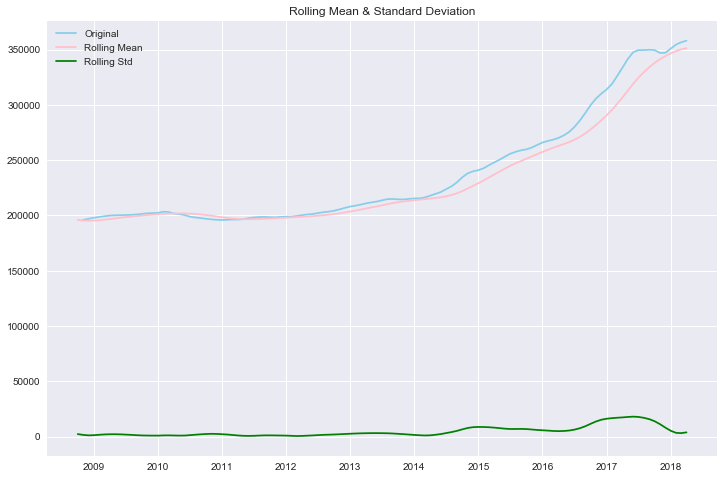

(2.398739834018658, 0.9990097153527193, 13, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}, 1733.3093661270368)
Results of Dickey-Fuller Test:
Test Statistic                   2.398740
p-value                          0.999010
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [29]:
#trends
test_stationarity(dfw['75218'], 10)
dickey_fuller_test_ind_zip(dfw['75218'])

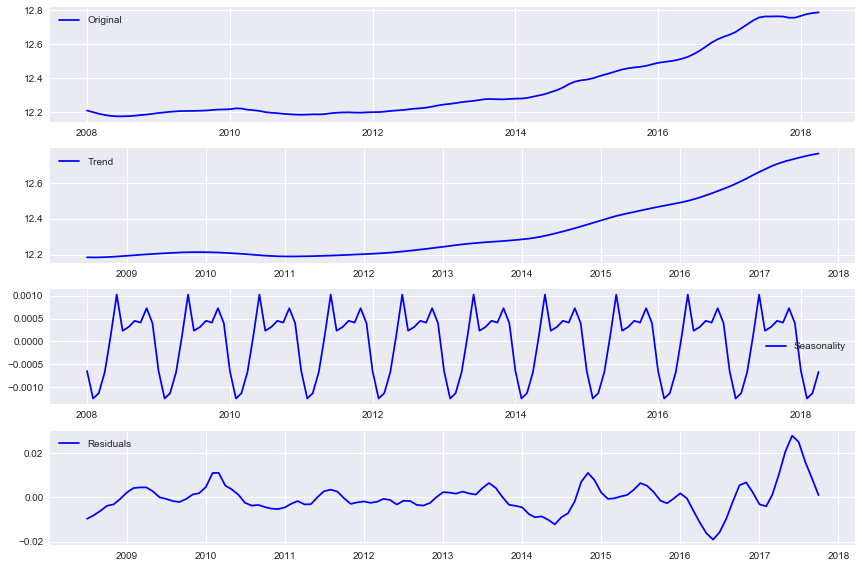

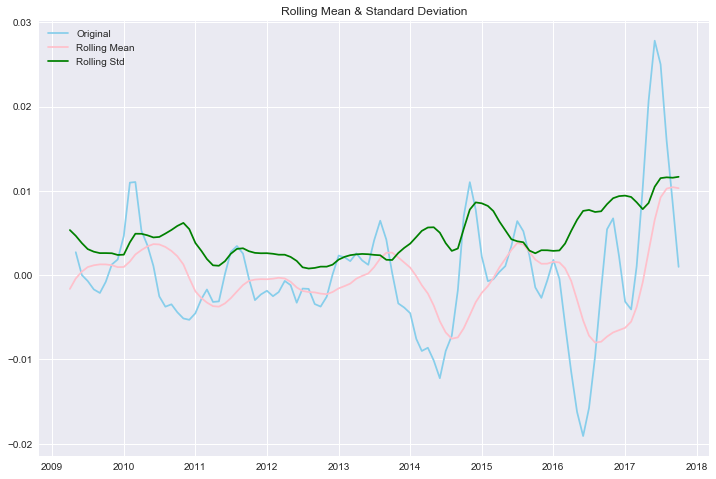

(-4.680114112315617, 9.169705637627072e-05, 8, 103, {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}, -950.5969717094465)
Results of Dickey-Fuller Test:
Test Statistic                  -4.680114
p-value                          0.000092
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [30]:
#decompose
decomposition = seasonal_decompose(np.log(dfw['75218']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(dfw['75218']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

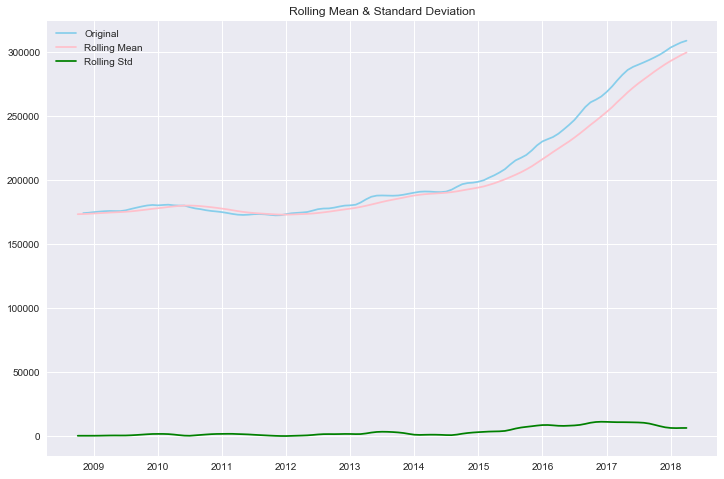

(-0.26930227134042956, 0.9297409268533592, 10, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 1649.7809317855342)
Results of Dickey-Fuller Test:
Test Statistic                  -0.269302
p-value                          0.929741
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [31]:
test_stationarity(dfw['75080'], 10)
dickey_fuller_test_ind_zip(dfw['75080'])

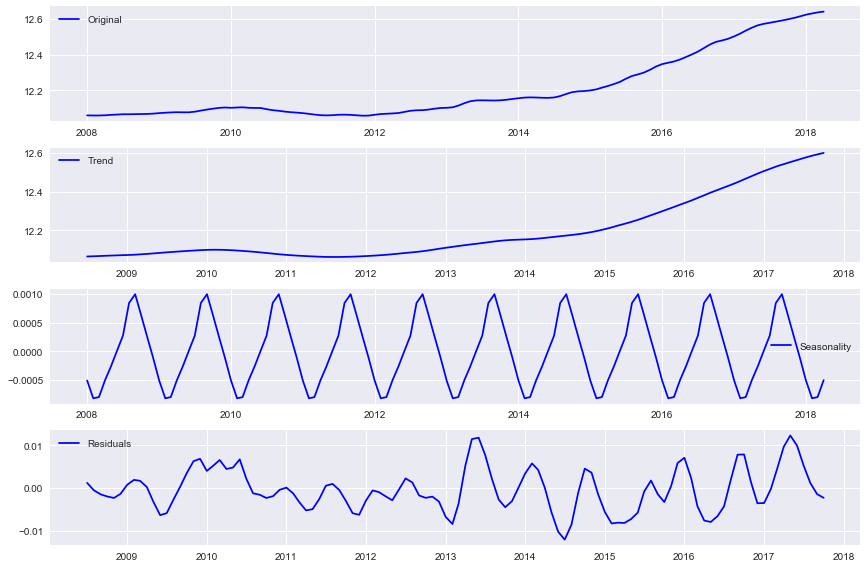

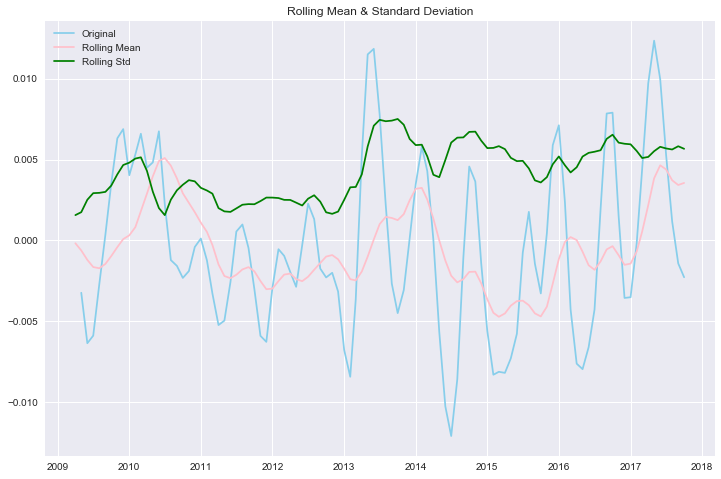

(-3.121921739474189, 0.024972845768741335, 8, 103, {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}, -978.4723388757318)
Results of Dickey-Fuller Test:
Test Statistic                  -3.121922
p-value                          0.024973
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [32]:
decomposition = seasonal_decompose(np.log(dfw['75080']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(dfw['75080']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

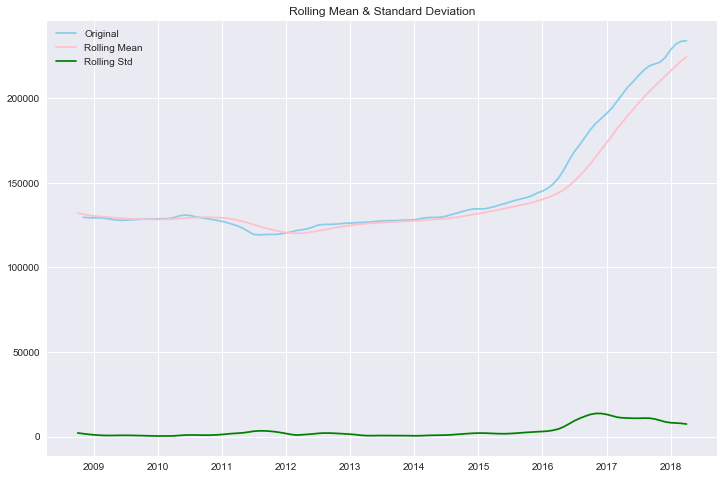

(-0.4981123398158924, 0.8923843347354035, 10, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 1639.0560579300143)
Results of Dickey-Fuller Test:
Test Statistic                  -0.498112
p-value                          0.892384
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [33]:
test_stationarity(dfw['75234'], 10)
dickey_fuller_test_ind_zip(dfw['75234'])

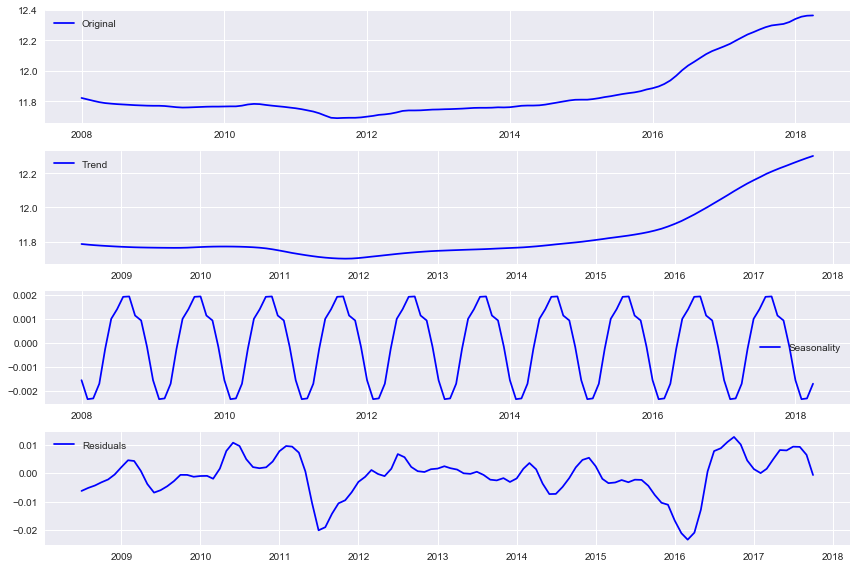

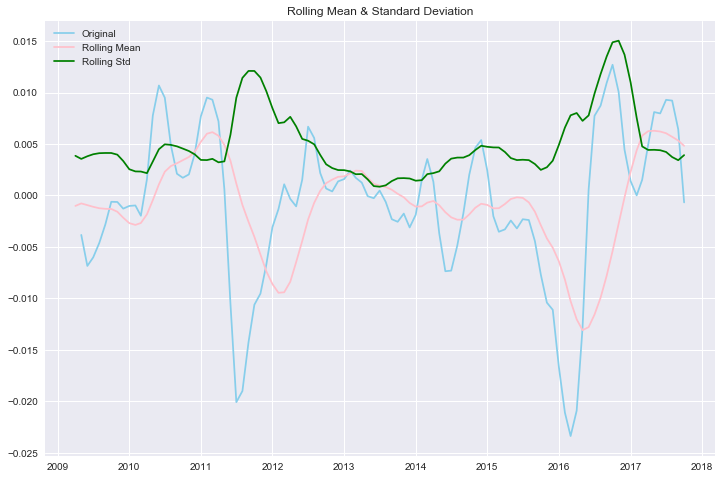

(-3.7691367473897768, 0.003239349986487559, 13, 98, {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157}, -942.9574759717598)
Results of Dickey-Fuller Test:
Test Statistic                 -3.769137
p-value                         0.003239
#Lags Used                     13.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [34]:
decomposition = seasonal_decompose(np.log(dfw['75234']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(dfw['75234']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

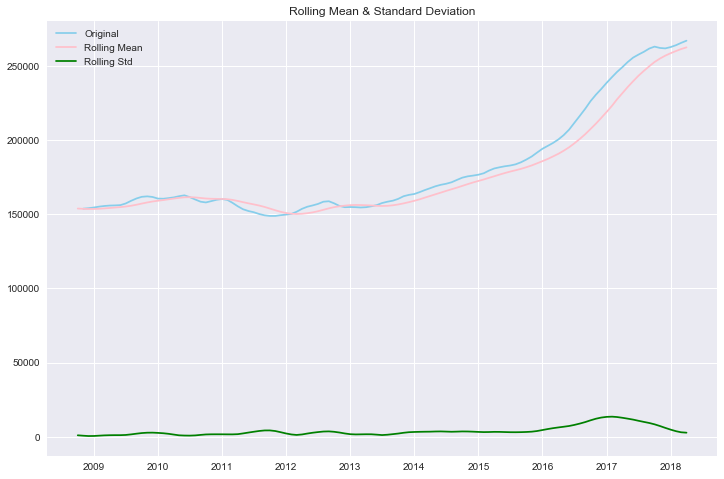

(0.11328458460251063, 0.9669564772568928, 5, 118, {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}, 1694.7831951244657)
Results of Dickey-Fuller Test:
Test Statistic                   0.113285
p-value                          0.966956
#Lags Used                       5.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [35]:
test_stationarity(dfw['75081'], 10)
dickey_fuller_test_ind_zip(dfw['75081'])

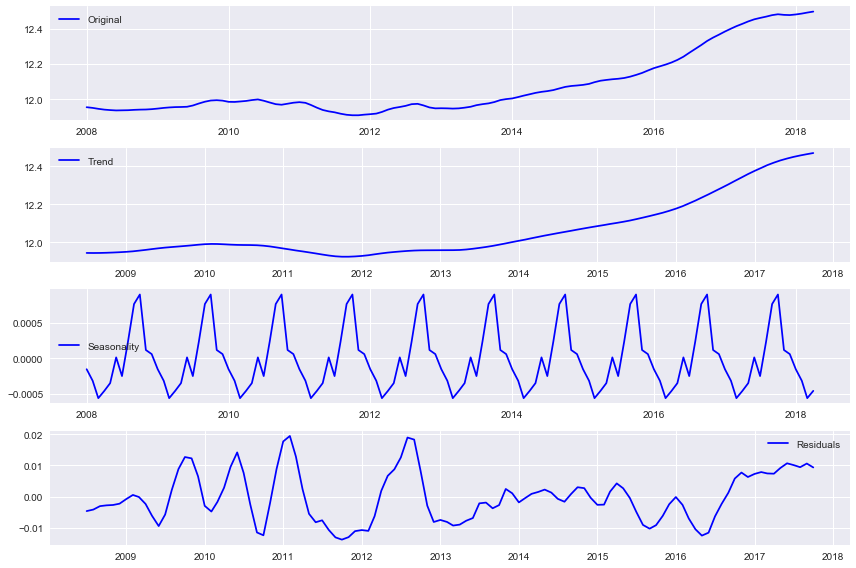

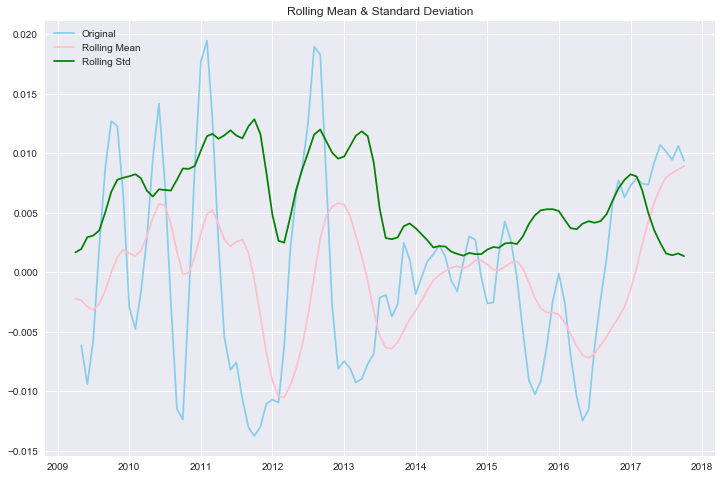

(-3.7294778740323395, 0.0037171173352180077, 6, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -903.9236854462629)
Results of Dickey-Fuller Test:
Test Statistic                  -3.729478
p-value                          0.003717
#Lags Used                       6.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [36]:
decomposition = seasonal_decompose(np.log(dfw['75081']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(dfw['75081']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

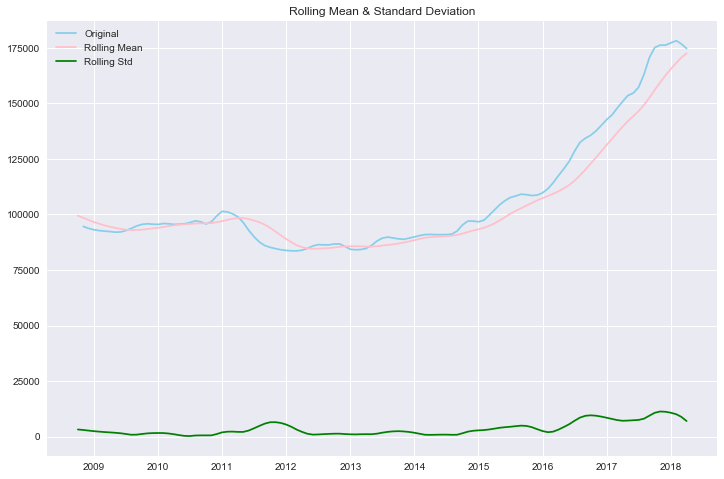

(0.39178054956142383, 0.9811849483423146, 6, 117, {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}, 1748.8819599538838)
Results of Dickey-Fuller Test:
Test Statistic                   0.391781
p-value                          0.981185
#Lags Used                       6.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [37]:
test_stationarity(dfw['75235'], 10)
dickey_fuller_test_ind_zip(dfw['75235'])

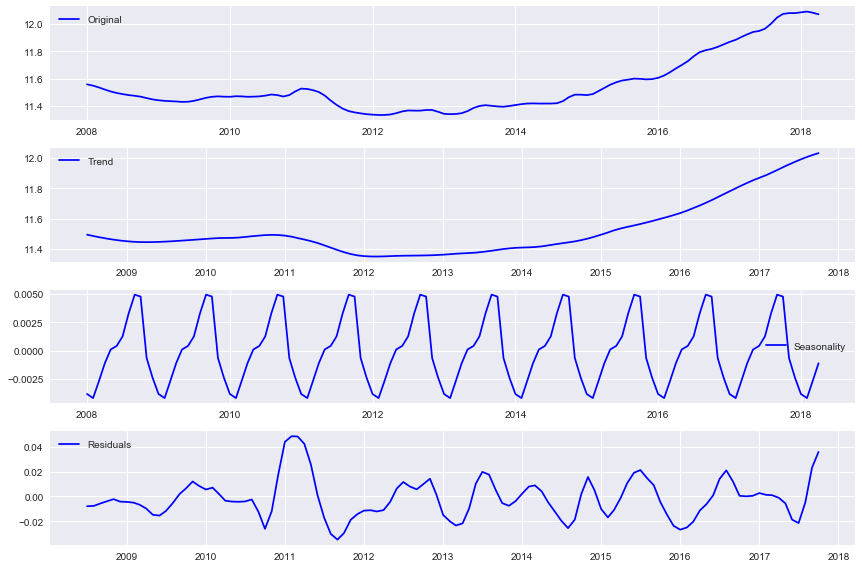

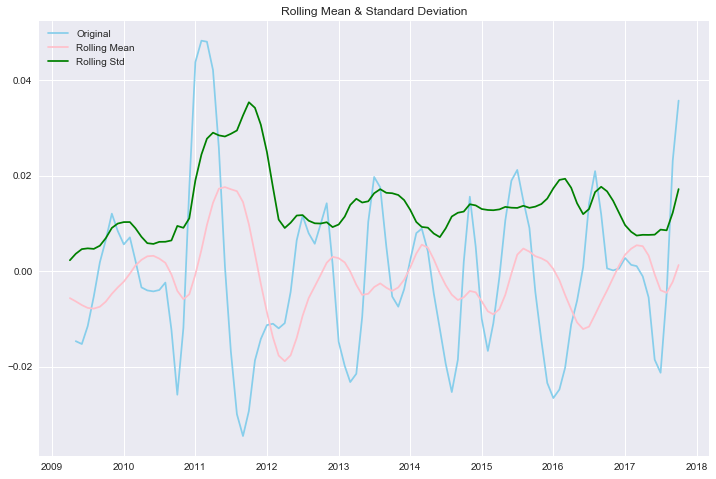

(-4.960154337256819, 2.6596311449078137e-05, 6, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -750.4781978620392)
Results of Dickey-Fuller Test:
Test Statistic                  -4.960154
p-value                          0.000027
#Lags Used                       6.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [38]:
decomposition = seasonal_decompose(np.log(dfw['75235']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(dfw['75235']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

## Autocorrelation: Dallas-Fort Worth

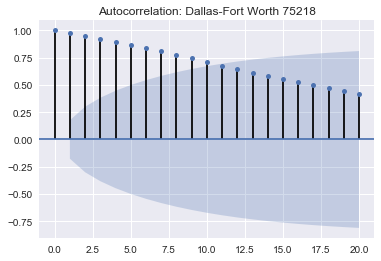

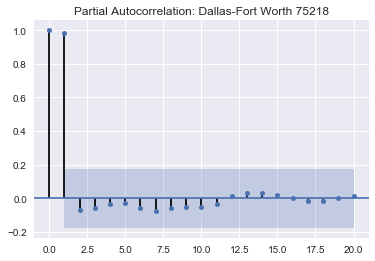

In [39]:
log_75218 = np.log(dfw['75218'])
title = 'Autocorrelation: Dallas-Fort Worth 75218'
lags = 20
plot_acf(log_75218,title=title,lags=lags);

title = 'Partial Autocorrelation: Dallas-Fort Worth 75218'
lags = 20
plot_pacf(log_75218,title=title,lags=lags);

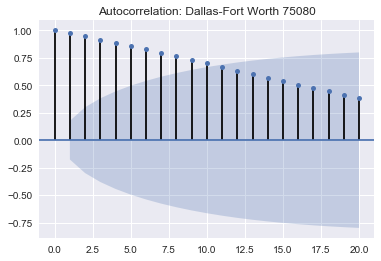

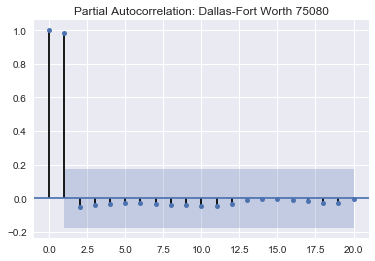

In [40]:
log_75080 = np.log(dfw['75080'])
title = 'Autocorrelation: Dallas-Fort Worth 75080'
lags = 20
plot_acf(log_75080,title=title,lags=lags);

title = 'Partial Autocorrelation: Dallas-Fort Worth 75080'
lags = 20
plot_pacf(log_75080,title=title,lags=lags);

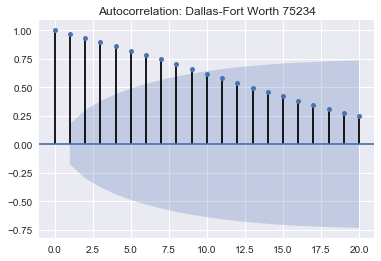

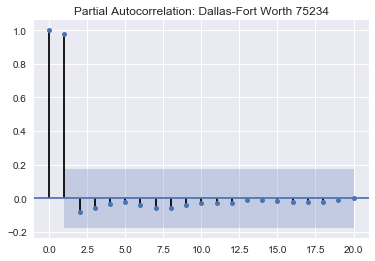

In [41]:
log_75234 = np.log(dfw['75234'])
title = 'Autocorrelation: Dallas-Fort Worth 75234'
lags = 20
plot_acf(log_75234,title=title,lags=lags);

title = 'Partial Autocorrelation: Dallas-Fort Worth 75234'
lags = 20
plot_pacf(log_75234,title=title,lags=lags);

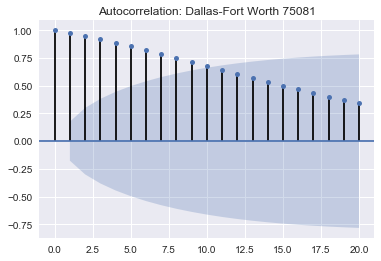

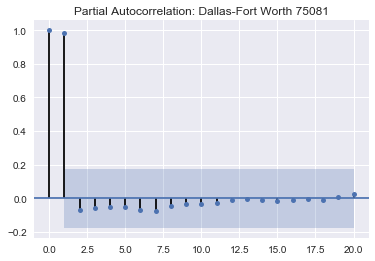

In [42]:
log_75081 = np.log(dfw['75081'])
title = 'Autocorrelation: Dallas-Fort Worth 75081'
lags = 20
plot_acf(log_75081,title=title,lags=lags);

title = 'Partial Autocorrelation: Dallas-Fort Worth 75081'
lags = 20
plot_pacf(log_75081,title=title,lags=lags);

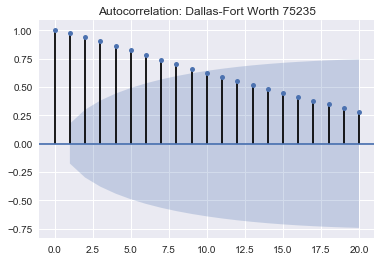

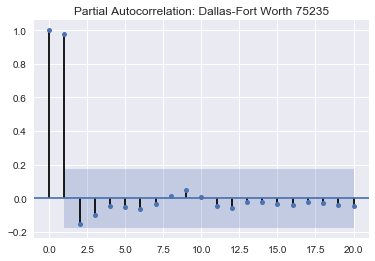

In [43]:
log_75235 = np.log(dfw['75235'])
title = 'Autocorrelation: Dallas-Fort Worth 75235'
lags = 20
plot_acf(log_75235,title=title,lags=lags);

title = 'Partial Autocorrelation: Dallas-Fort Worth 75235'
lags = 20
plot_pacf(log_75235,title=title,lags=lags);

## Raleigh-Durham

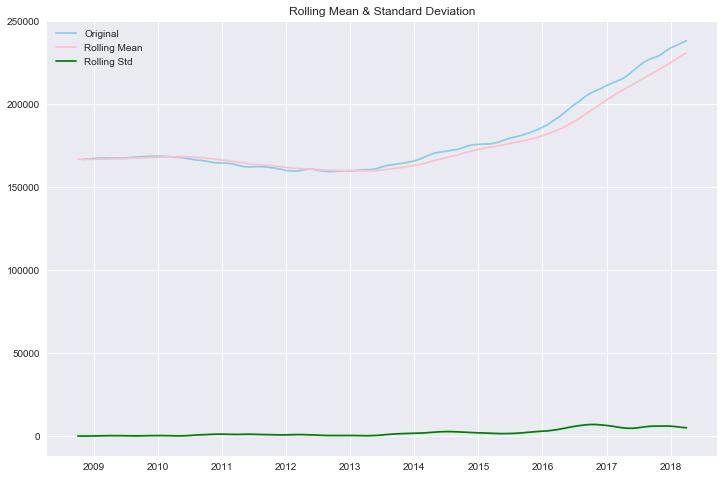

(-0.5819457315538616, 0.8750095892399059, 6, 117, {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}, 1562.808440693537)
Results of Dickey-Fuller Test:
Test Statistic                  -0.581946
p-value                          0.875010
#Lags Used                       6.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [44]:
test_stationarity(rdu['27707'], 10)
dickey_fuller_test_ind_zip(rdu['27707'])

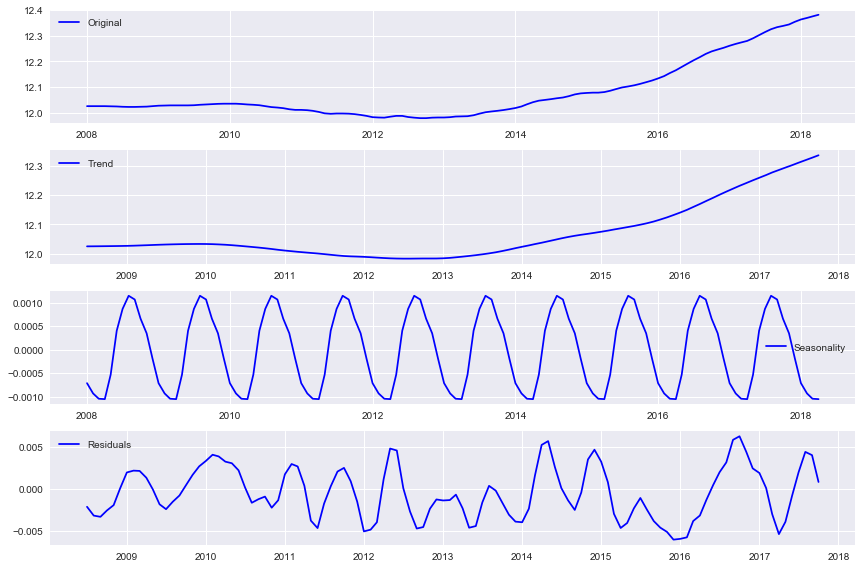

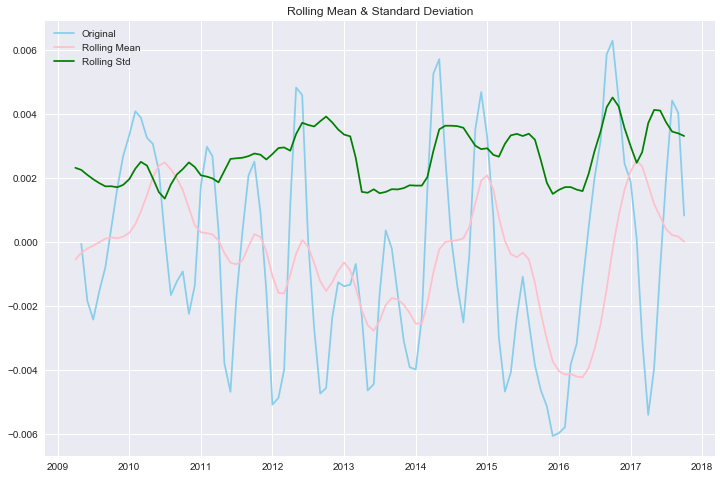

(-3.374248730022431, 0.011868688354021809, 6, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -1037.472059294833)
Results of Dickey-Fuller Test:
Test Statistic                  -3.374249
p-value                          0.011869
#Lags Used                       6.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [45]:
decomposition = seasonal_decompose(np.log(rdu['27707']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(rdu['27707']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

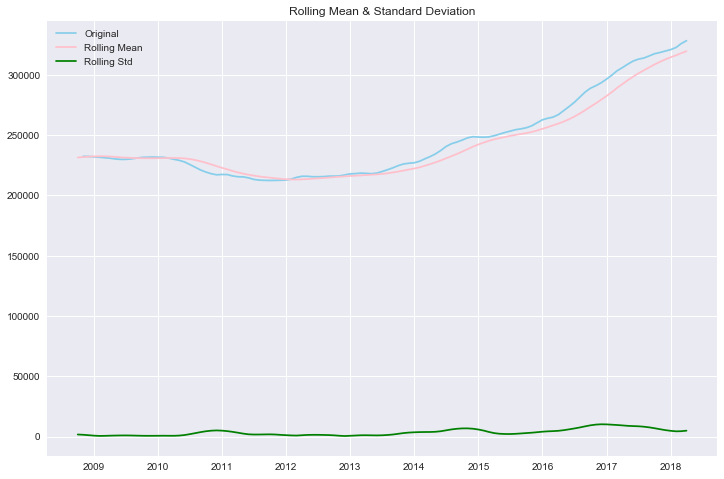

(1.1605002312905834, 0.9957012856906271, 4, 119, {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}, 1675.524617471652)
Results of Dickey-Fuller Test:
Test Statistic                   1.160500
p-value                          0.995701
#Lags Used                       4.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [46]:
test_stationarity(rdu['27609'], 10)
dickey_fuller_test_ind_zip(rdu['27609'])

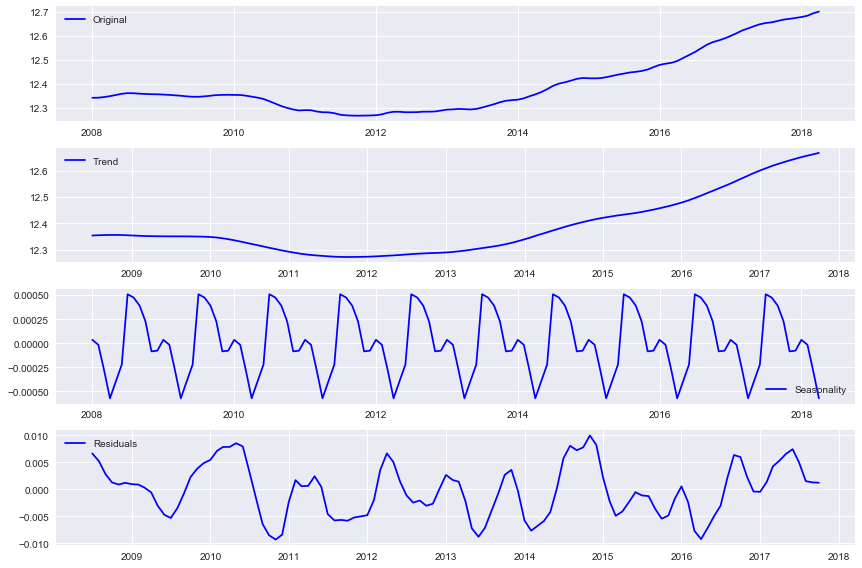

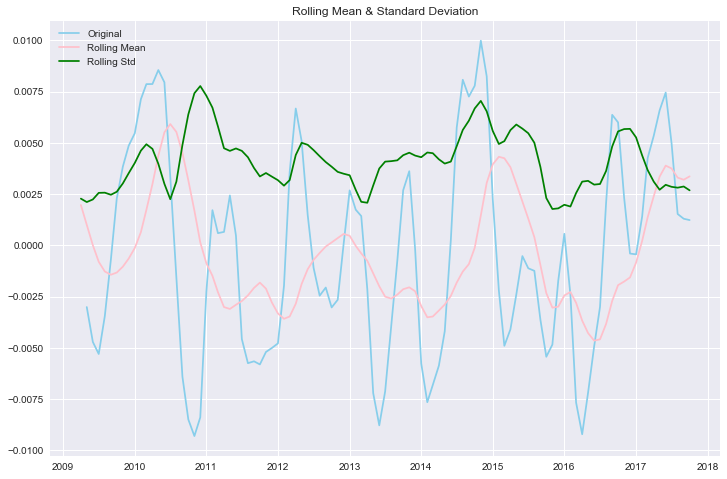

(-3.8395016303223257, 0.0025280566599961826, 4, 107, {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}, -983.0160946896874)
Results of Dickey-Fuller Test:
Test Statistic                  -3.839502
p-value                          0.002528
#Lags Used                       4.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [47]:
decomposition = seasonal_decompose(np.log(rdu['27609']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(rdu['27609']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

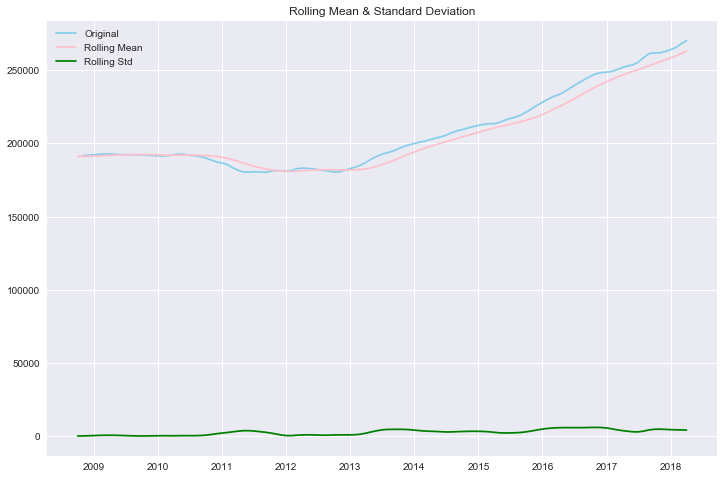

(1.3220234060948788, 0.9967294441445111, 4, 119, {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}, 1620.9484580231767)
Results of Dickey-Fuller Test:
Test Statistic                   1.322023
p-value                          0.996729
#Lags Used                       4.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [48]:
test_stationarity(rdu['27705'], 10)
dickey_fuller_test_ind_zip(rdu['27705'])

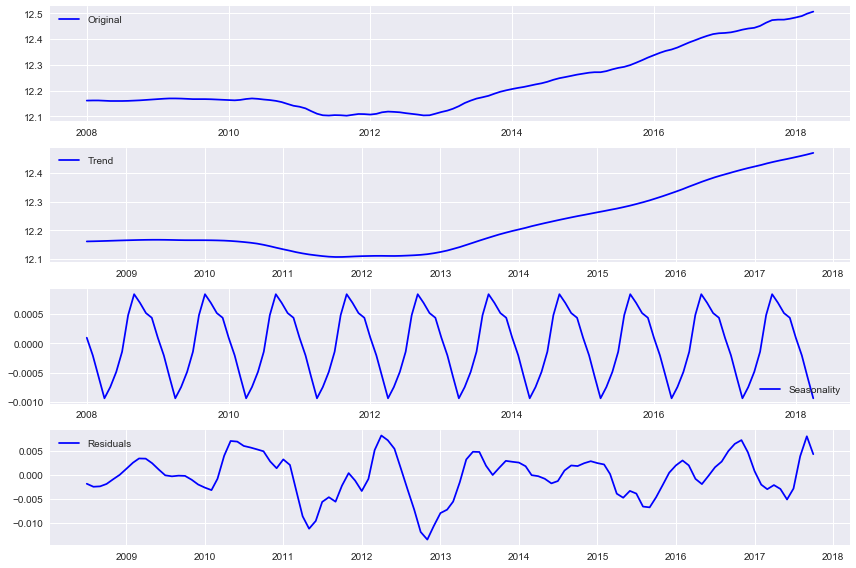

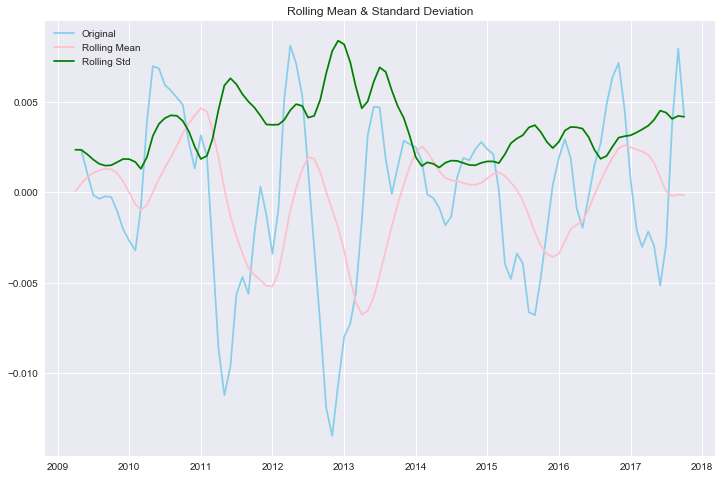

(-3.400729229609075, 0.010934037327742977, 10, 101, {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}, -1012.7627322245335)
Results of Dickey-Fuller Test:
Test Statistic                  -3.400729
p-value                          0.010934
#Lags Used                      10.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [49]:
decomposition = seasonal_decompose(np.log(rdu['27705']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(rdu['27705']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

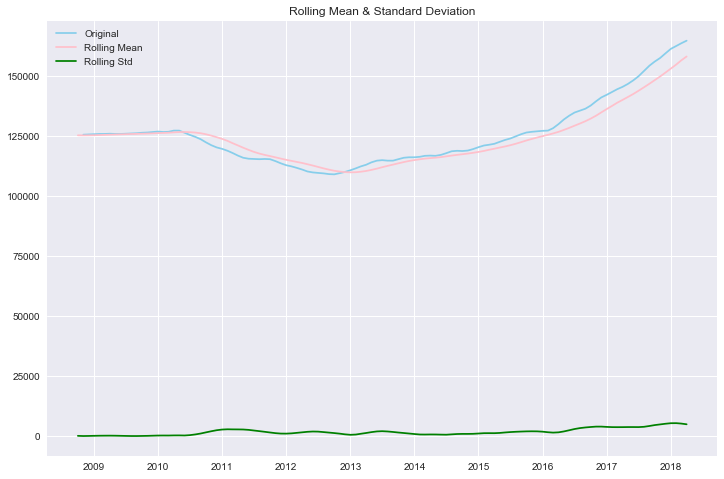

(-1.3548521273958012, 0.6037191668595456, 13, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}, 1543.9207548154006)
Results of Dickey-Fuller Test:
Test Statistic                  -1.354852
p-value                          0.603719
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [50]:
test_stationarity(rdu['27704'], 10)
dickey_fuller_test_ind_zip(rdu['27704'])

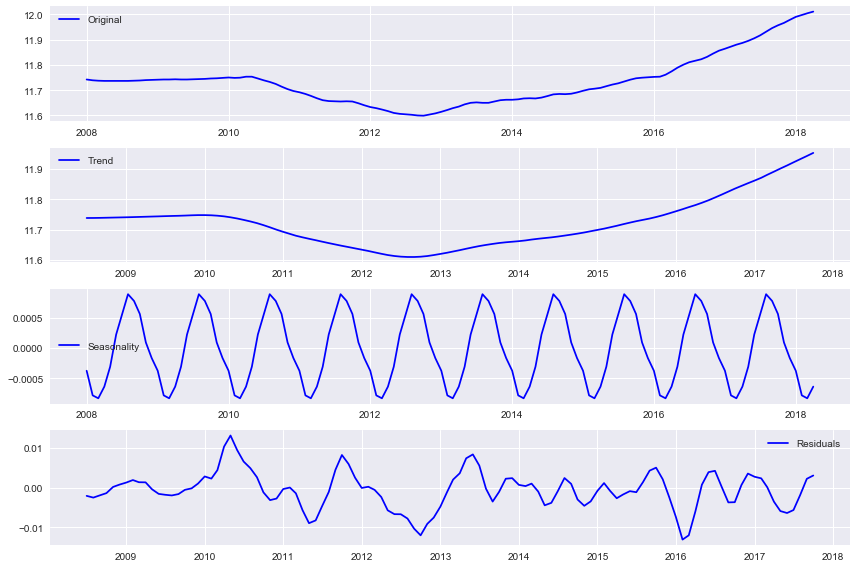

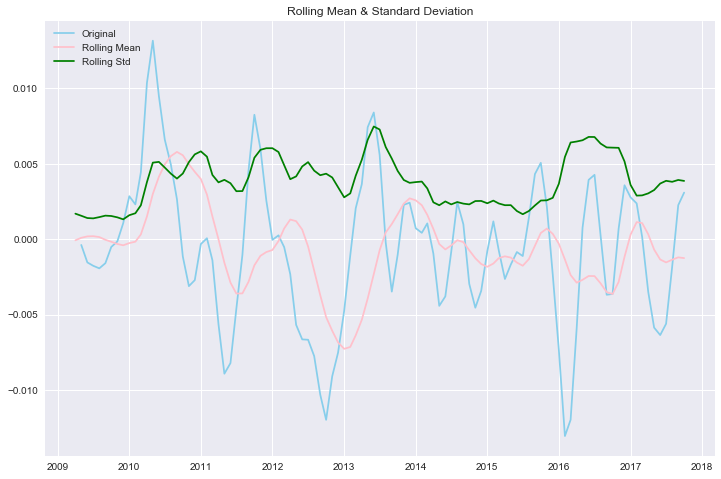

(-2.6158856377811435, 0.08975827515407114, 13, 98, {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157}, -971.2018454932747)
Results of Dickey-Fuller Test:
Test Statistic                 -2.615886
p-value                         0.089758
#Lags Used                     13.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [51]:
decomposition = seasonal_decompose(np.log(rdu['27704']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(rdu['27704']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

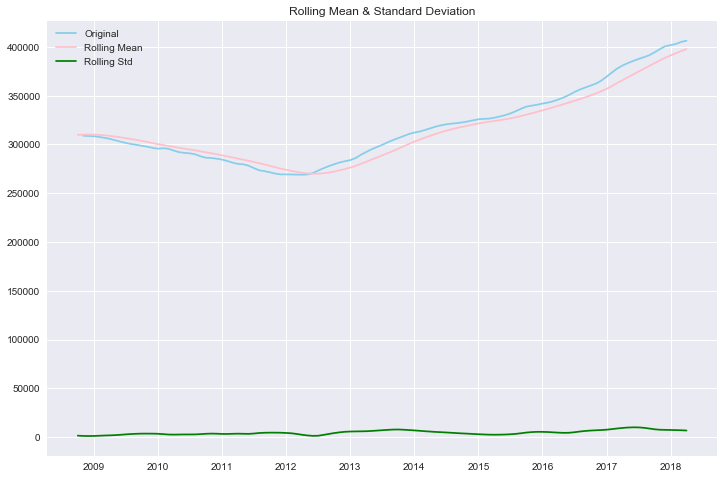

(-0.02636968509304656, 0.9562962389816072, 11, 112, {'1%': -3.4901313156261384, '5%': -2.8877122815688776, '10%': -2.5807296460459184}, 1671.5266980809051)
Results of Dickey-Fuller Test:
Test Statistic                  -0.026370
p-value                          0.956296
#Lags Used                      11.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


In [52]:
test_stationarity(rdu['27607'], 10)
dickey_fuller_test_ind_zip(rdu['27607'])

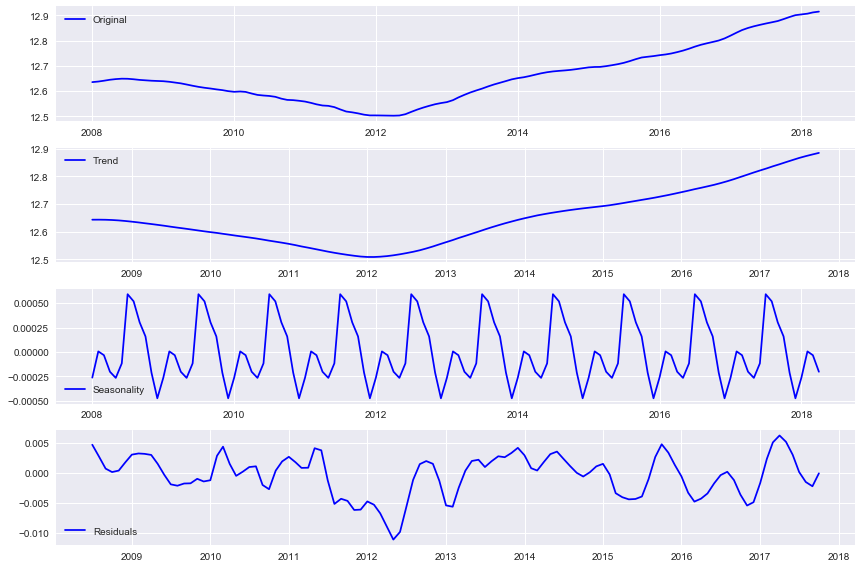

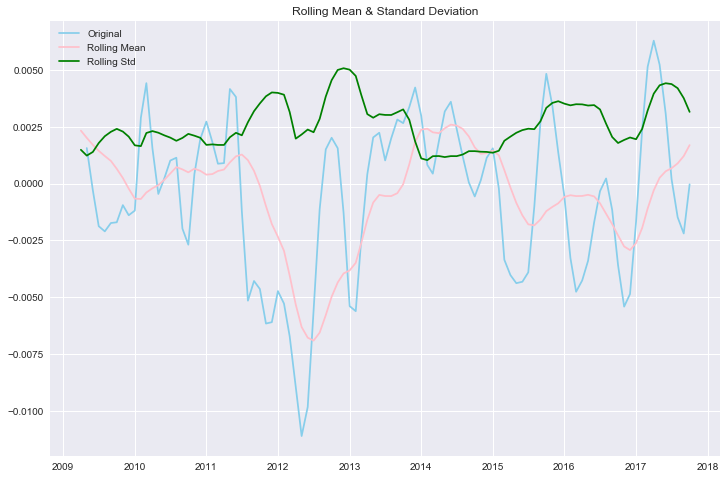

(-2.8960779271112833, 0.045805985833046424, 4, 107, {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}, -1026.4281098132255)
Results of Dickey-Fuller Test:
Test Statistic                  -2.896078
p-value                          0.045806
#Lags Used                       4.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [53]:
decomposition = seasonal_decompose(np.log(rdu['27607']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(rdu['27607']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

## Autocorrelation: Raleigh-Durham

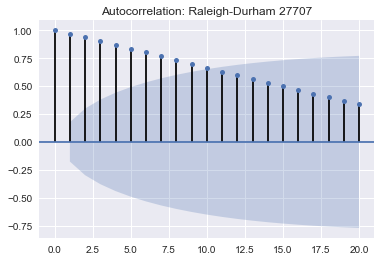

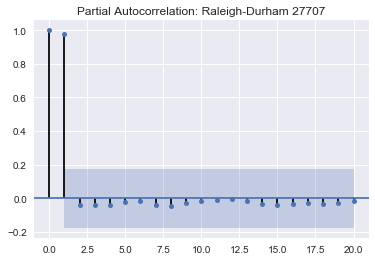

In [54]:
log_27707 = np.log(rdu['27707'])
title = 'Autocorrelation: Raleigh-Durham 27707'
lags = 20
plot_acf(log_27707,title=title,lags=lags);

title = 'Partial Autocorrelation: Raleigh-Durham 27707'
lags = 20
plot_pacf(log_27707,title=title,lags=lags);

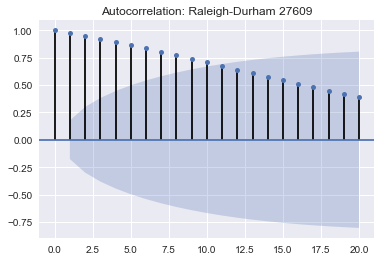

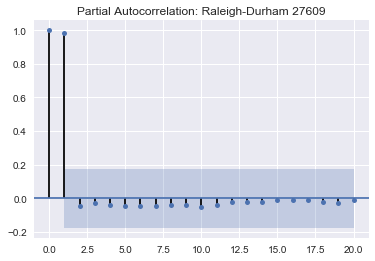

In [55]:
log_27609 = np.log(rdu['27609'])
title = 'Autocorrelation: Raleigh-Durham 27609'
lags = 20
plot_acf(log_27609,title=title,lags=lags);

title = 'Partial Autocorrelation: Raleigh-Durham 27609'
lags = 20
plot_pacf(log_27609,title=title,lags=lags);

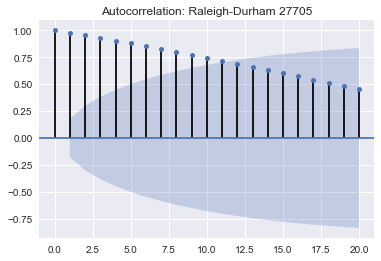

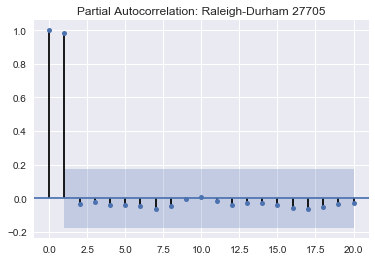

In [56]:
log_27705 = np.log(rdu['27705'])
title = 'Autocorrelation: Raleigh-Durham 27705'
lags = 20
plot_acf(log_27705,title=title,lags=lags);

title = 'Partial Autocorrelation: Raleigh-Durham 27705'
lags = 20
plot_pacf(log_27705,title=title,lags=lags);

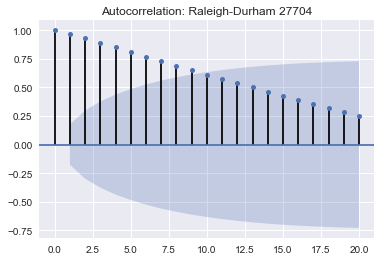

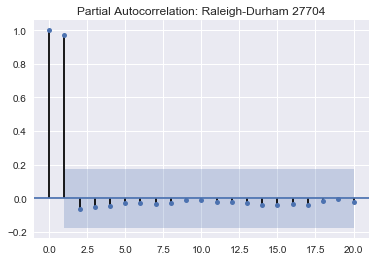

In [57]:
log_27704 = np.log(rdu['27704'])
title = 'Autocorrelation: Raleigh-Durham 27704'
lags = 20
plot_acf(log_27704,title=title,lags=lags);

title = 'Partial Autocorrelation: Raleigh-Durham 27704'
lags = 20
plot_pacf(log_27704,title=title,lags=lags);

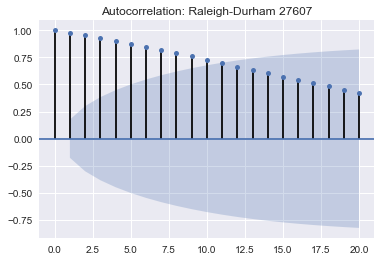

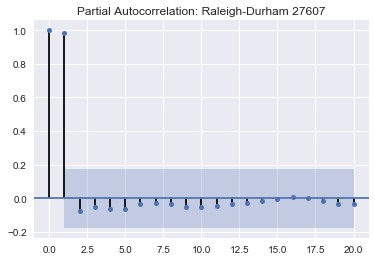

In [58]:
log_27607 = np.log(rdu['27607'])
title = 'Autocorrelation: Raleigh-Durham 27607'
lags = 20
plot_acf(log_27607,title=title,lags=lags);

title = 'Partial Autocorrelation: Raleigh-Durham 27607'
lags = 20
plot_pacf(log_27607,title=title,lags=lags);

## Nashville

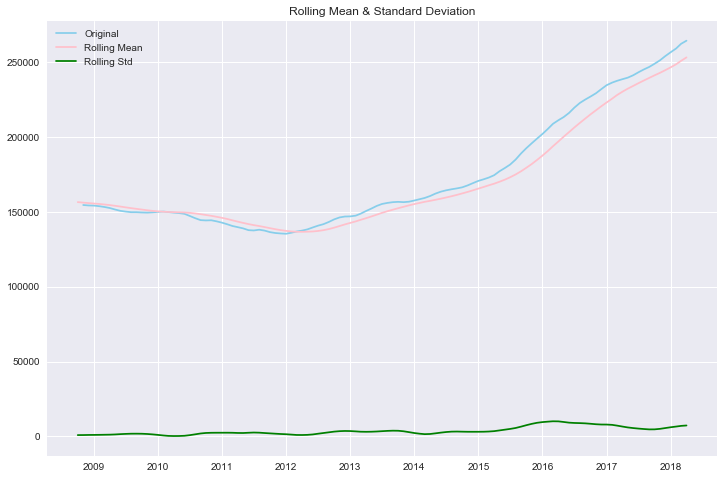

(0.3243466110618245, 0.9784343315502539, 3, 120, {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}, 1642.4298165860318)
Results of Dickey-Fuller Test:
Test Statistic                   0.324347
p-value                          0.978434
#Lags Used                       3.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [59]:
test_stationarity(nash['37211'], 10)
dickey_fuller_test_ind_zip(nash['37211'])

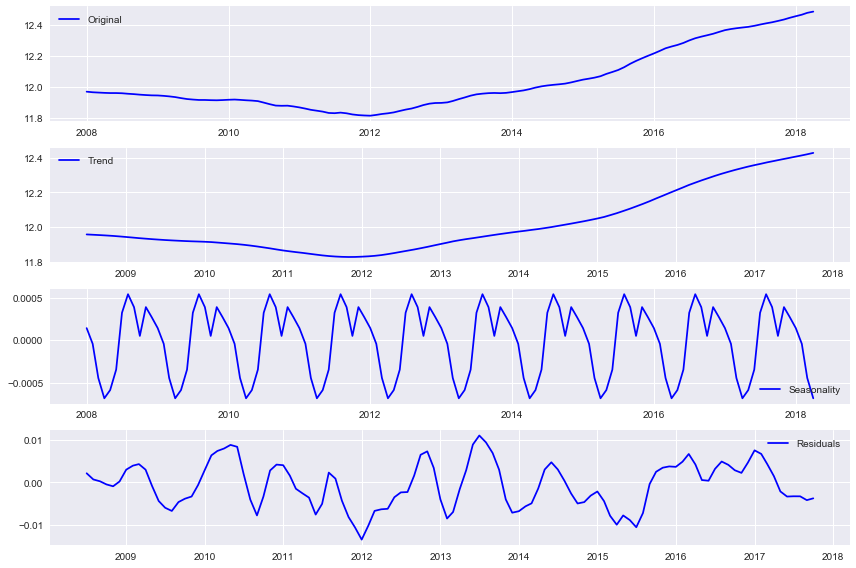

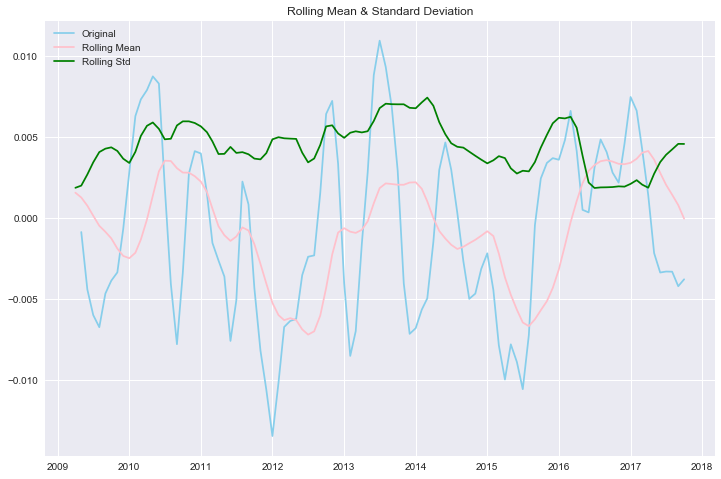

(-3.015456680683241, 0.033475937128411286, 8, 103, {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}, -938.275702815256)
Results of Dickey-Fuller Test:
Test Statistic                  -3.015457
p-value                          0.033476
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [60]:
decomposition = seasonal_decompose(np.log(nash['37211']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(nash['37211']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

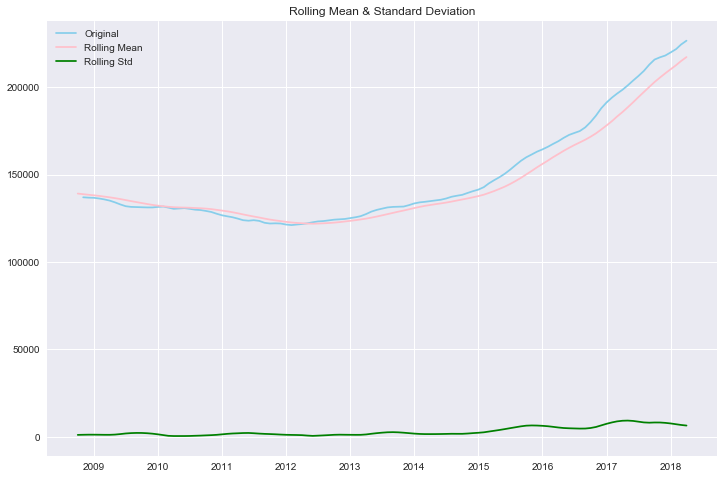

(-0.44426041819448053, 0.9024424792366008, 6, 117, {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}, 1611.8245931826223)
Results of Dickey-Fuller Test:
Test Statistic                  -0.444260
p-value                          0.902442
#Lags Used                       6.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [61]:
test_stationarity(nash['37214'], 10)
dickey_fuller_test_ind_zip(nash['37214'])

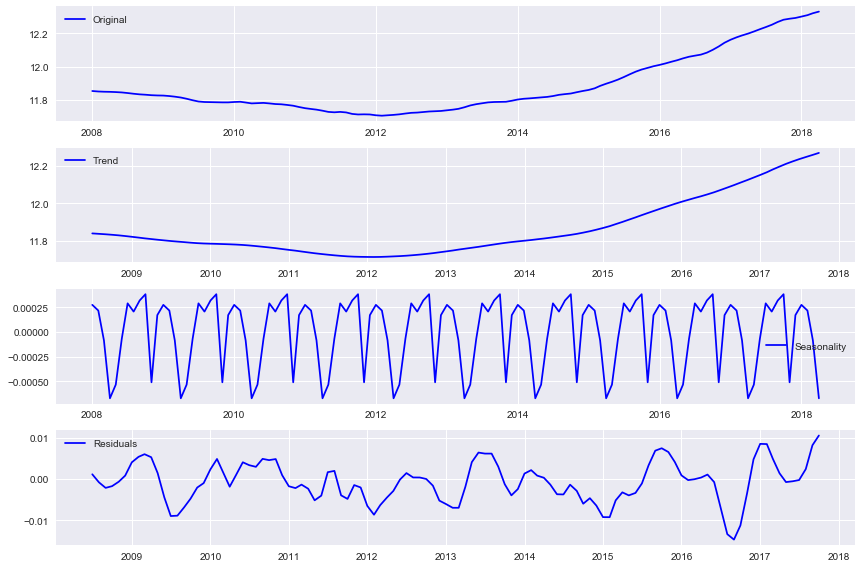

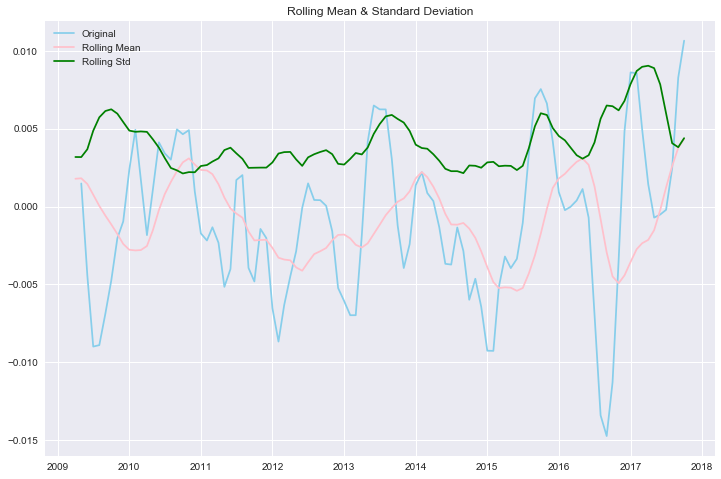

(-4.471969996415293, 0.0002208892990046636, 9, 102, {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}, -953.2115777465528)
Results of Dickey-Fuller Test:
Test Statistic                  -4.471970
p-value                          0.000221
#Lags Used                       9.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [62]:
decomposition = seasonal_decompose(np.log(nash['37214']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(nash['37214']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

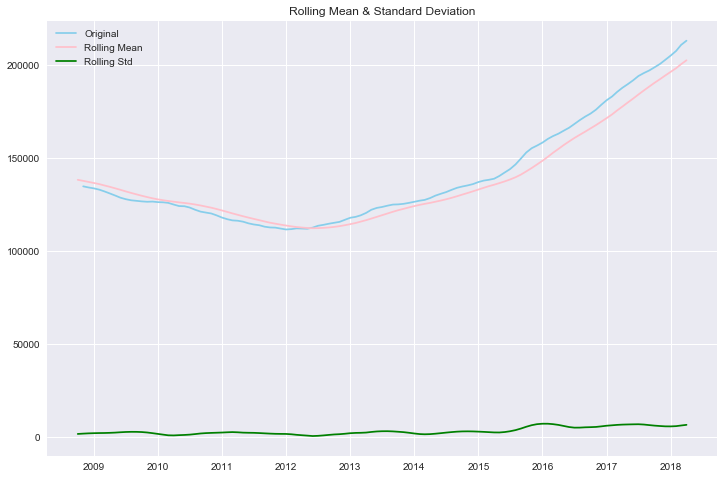

(-0.6787396925811706, 0.8521798526964145, 10, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 1598.6616420030948)
Results of Dickey-Fuller Test:
Test Statistic                  -0.678740
p-value                          0.852180
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [63]:
test_stationarity(nash['37217'], 10)
dickey_fuller_test_ind_zip(nash['37217'])

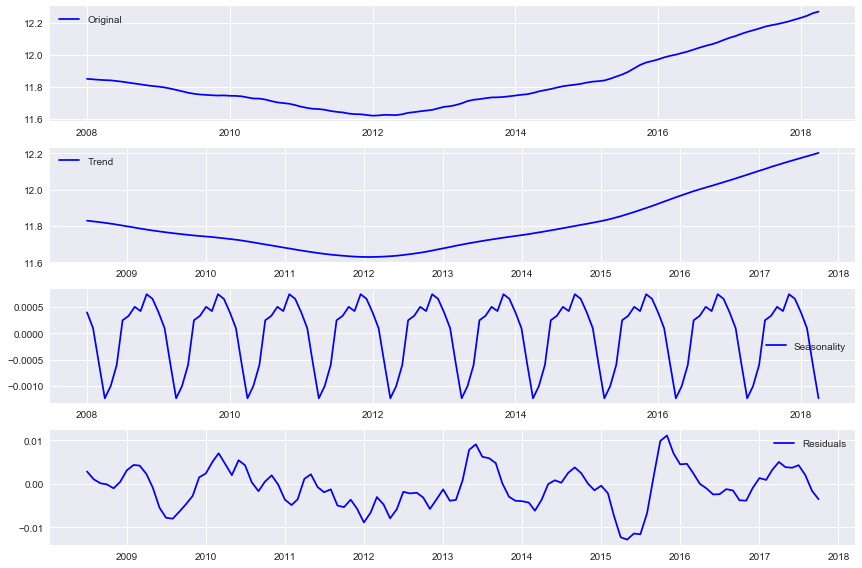

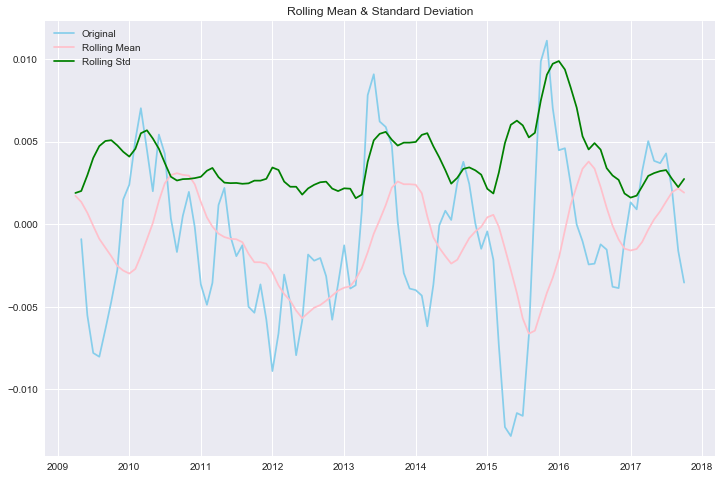

(-6.150078818951545, 7.599709188952593e-08, 3, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, -954.8467898114416)
Results of Dickey-Fuller Test:
Test Statistic                -6.150079e+00
p-value                        7.599709e-08
#Lags Used                     3.000000e+00
Number of Observations Used    1.080000e+02
Critical Value (1%)           -3.492401e+00
Critical Value (5%)           -2.888697e+00
Critical Value (10%)          -2.581255e+00
dtype: float64


In [64]:
decomposition = seasonal_decompose(np.log(nash['37217']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(nash['37217']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

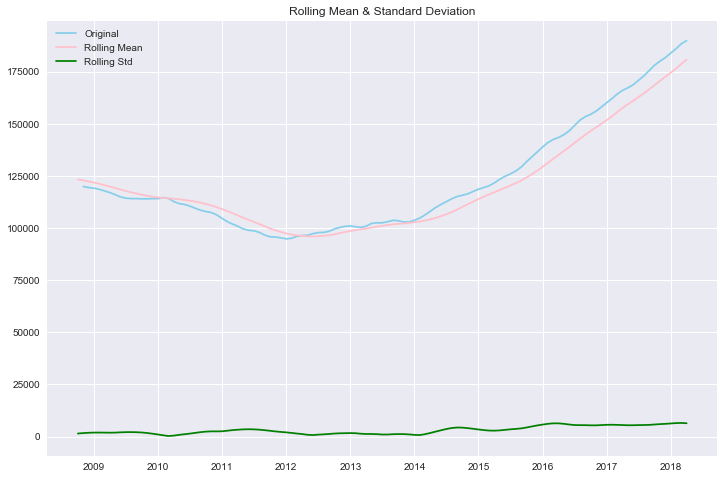

(-0.6140246270471345, 0.8677814416437131, 6, 117, {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}, 1610.5812326847467)
Results of Dickey-Fuller Test:
Test Statistic                  -0.614025
p-value                          0.867781
#Lags Used                       6.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


In [65]:
test_stationarity(nash['37115'], 10)
dickey_fuller_test_ind_zip(nash['37115'])

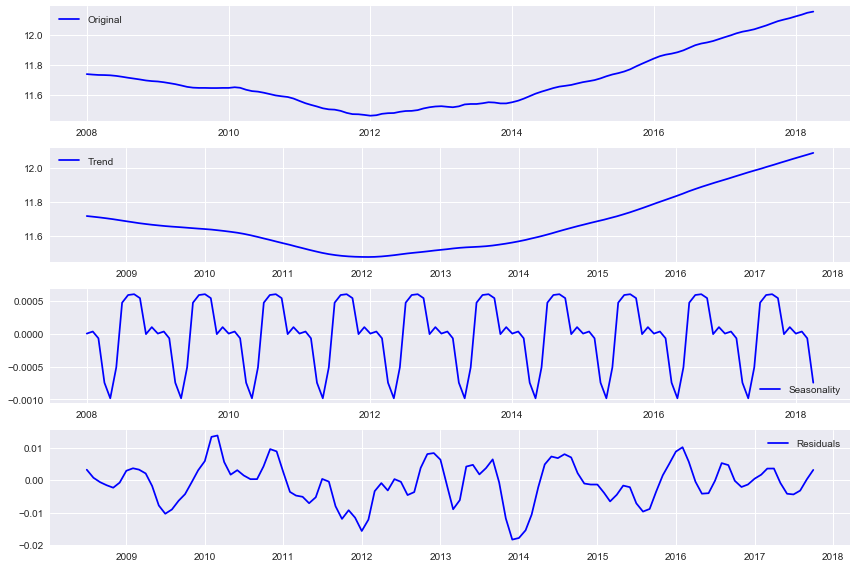

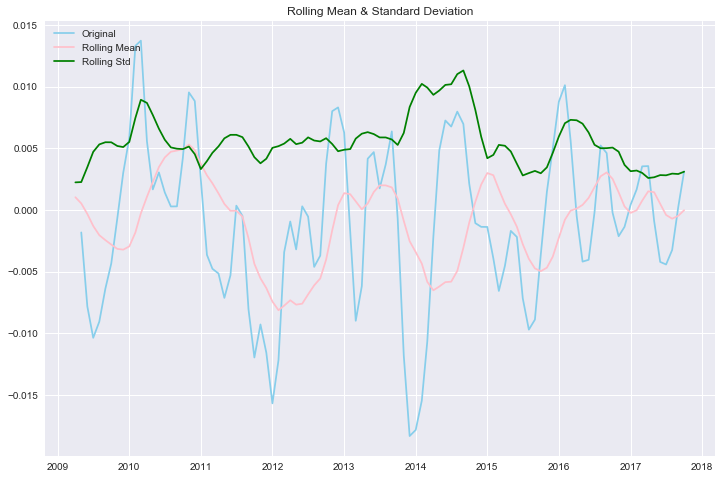

(-3.7494690914571485, 0.0034687519055429973, 4, 107, {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}, -900.369193590154)
Results of Dickey-Fuller Test:
Test Statistic                  -3.749469
p-value                          0.003469
#Lags Used                       4.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [66]:
decomposition = seasonal_decompose(np.log(nash['37115']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(nash['37115']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

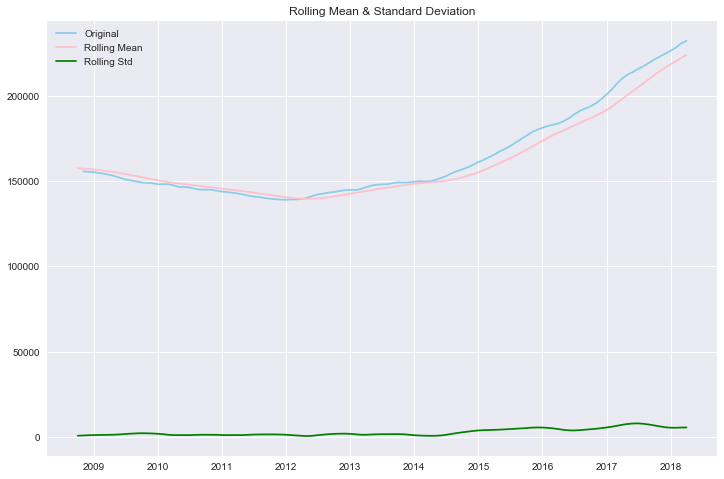

(0.15945733293568465, 0.9698937774259184, 3, 120, {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}, 1590.1820194815962)
Results of Dickey-Fuller Test:
Test Statistic                   0.159457
p-value                          0.969894
#Lags Used                       3.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [67]:
test_stationarity(nash['37138'], 10)
dickey_fuller_test_ind_zip(nash['37138'])

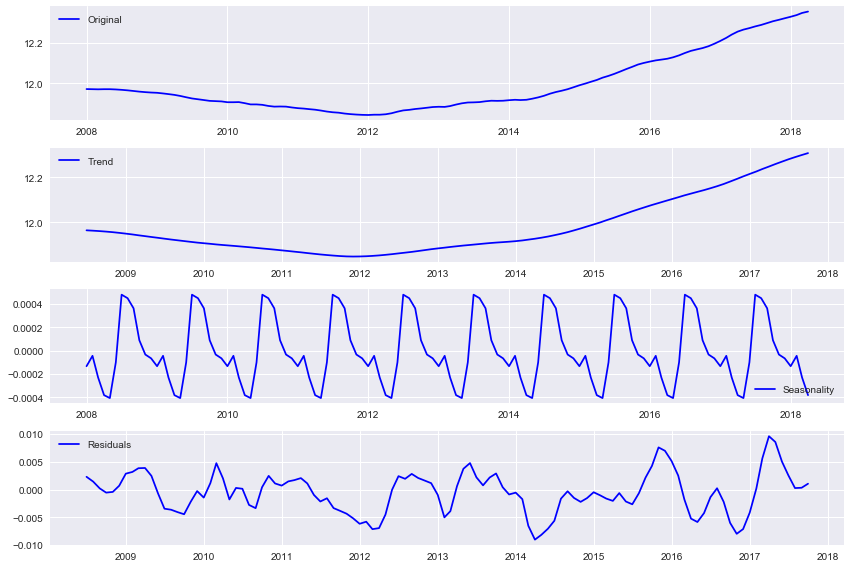

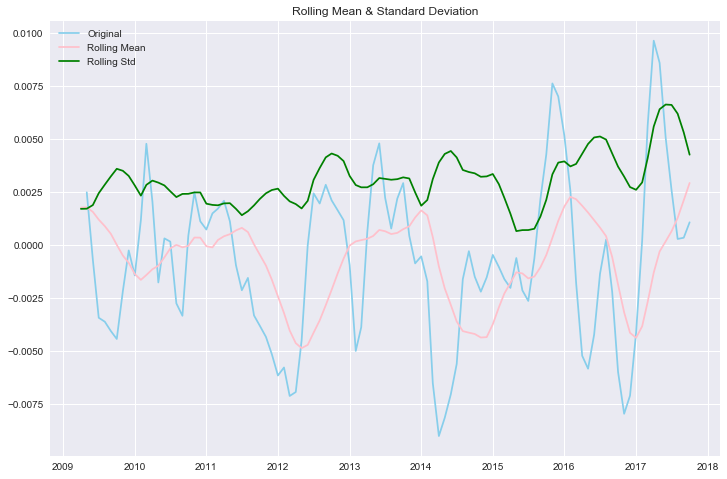

(-4.28819632700776, 0.0004655904424877398, 8, 103, {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}, -990.972934436983)
Results of Dickey-Fuller Test:
Test Statistic                  -4.288196
p-value                          0.000466
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [68]:
decomposition = seasonal_decompose(np.log(nash['37138']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(nash['37138']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)
dickey_fuller_test_ind_zip(ts_log_decompose)

## Autocorrelation: Nashville

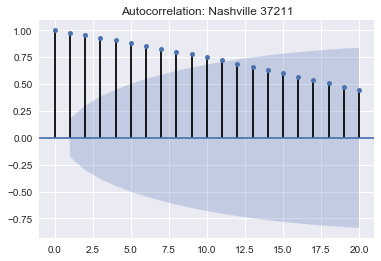

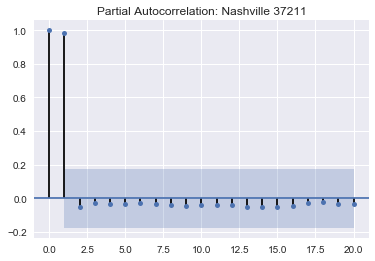

In [69]:
log_37211 = np.log(nash['37211'])
title = 'Autocorrelation: Nashville 37211'
lags = 20
plot_acf(log_37211,title=title,lags=lags);

title = 'Partial Autocorrelation: Nashville 37211'
lags = 20
plot_pacf(log_37211,title=title,lags=lags);

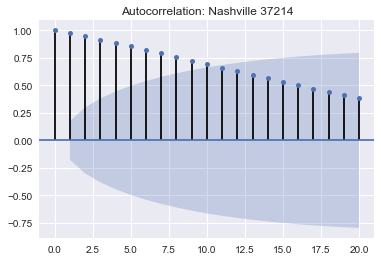

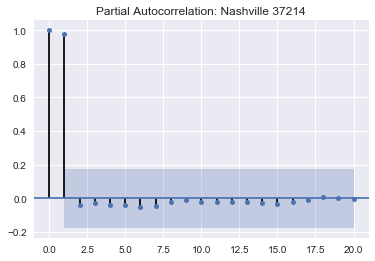

In [70]:
log_37214 = np.log(nash['37214'])
title = 'Autocorrelation: Nashville 37214'
lags = 20
plot_acf(log_37214,title=title,lags=lags);

title = 'Partial Autocorrelation: Nashville 37214'
lags = 20
plot_pacf(log_37214,title=title,lags=lags);

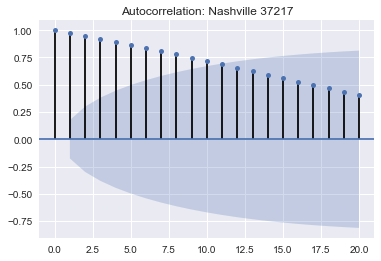

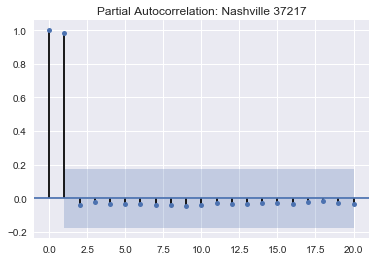

In [71]:
log_37217 = np.log(nash['37217'])
title = 'Autocorrelation: Nashville 37217'
lags = 20
plot_acf(log_37217,title=title,lags=lags);

title = 'Partial Autocorrelation: Nashville 37217'
lags = 20
plot_pacf(log_37217,title=title,lags=lags);

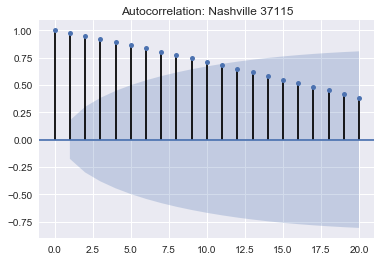

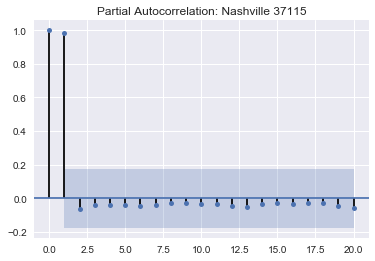

In [72]:
log_37115 = np.log(nash['37115'])
title = 'Autocorrelation: Nashville 37115'
lags = 20
plot_acf(log_37115,title=title,lags=lags);

title = 'Partial Autocorrelation: Nashville 37115'
lags = 20
plot_pacf(log_37115,title=title,lags=lags);

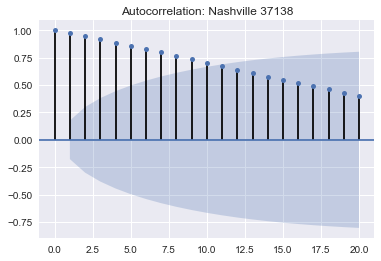

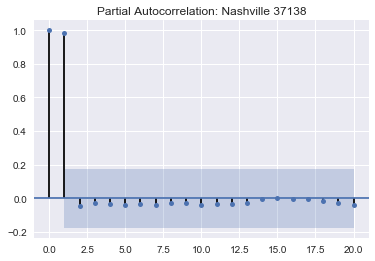

In [73]:
log_37138 = np.log(nash['37138'])
title = 'Autocorrelation: Nashville 37138'
lags = 20
plot_acf(log_37138,title=title,lags=lags);

title = 'Partial Autocorrelation: Nashville 37138'
lags = 20
plot_pacf(log_37138,title=title,lags=lags);

# ARIMA Modeling

In [74]:
#define the p, d and q parameters to take any value between 0 and 2
P = D = Q = range(0, 2)

#generate all different combinations of p, q and q triplets
PDQ = list(itertools.product(P, D, Q))

#generate all different combinations of seasonal p, q and q triplets
PDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

## Dallas-Fort Worth 75218

In [75]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_75218,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =969.4088507322492
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =876.8555815278066
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-219.3597620364808
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-194.16781076780515
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-297.376138820719
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-305.5028877338441
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-288.447305447562
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-281.1834319079843
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =800.263244347901
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =854.3908784297415
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-362.6603113654855
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-256.0871217635629
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-312.1317724225367
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-294.4641530970727
ARIMA (0, 0,

In [76]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1102.02
Name: 56, dtype: object

In [77]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_75218,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8676      0.036     23.959      0.000       0.797       0.939
ma.L1          0.5829      0.068      8.600      0.000       0.450       0.716
sigma2      6.147e-06   5.64e-07     10.890      0.000    5.04e-06    7.25e-06


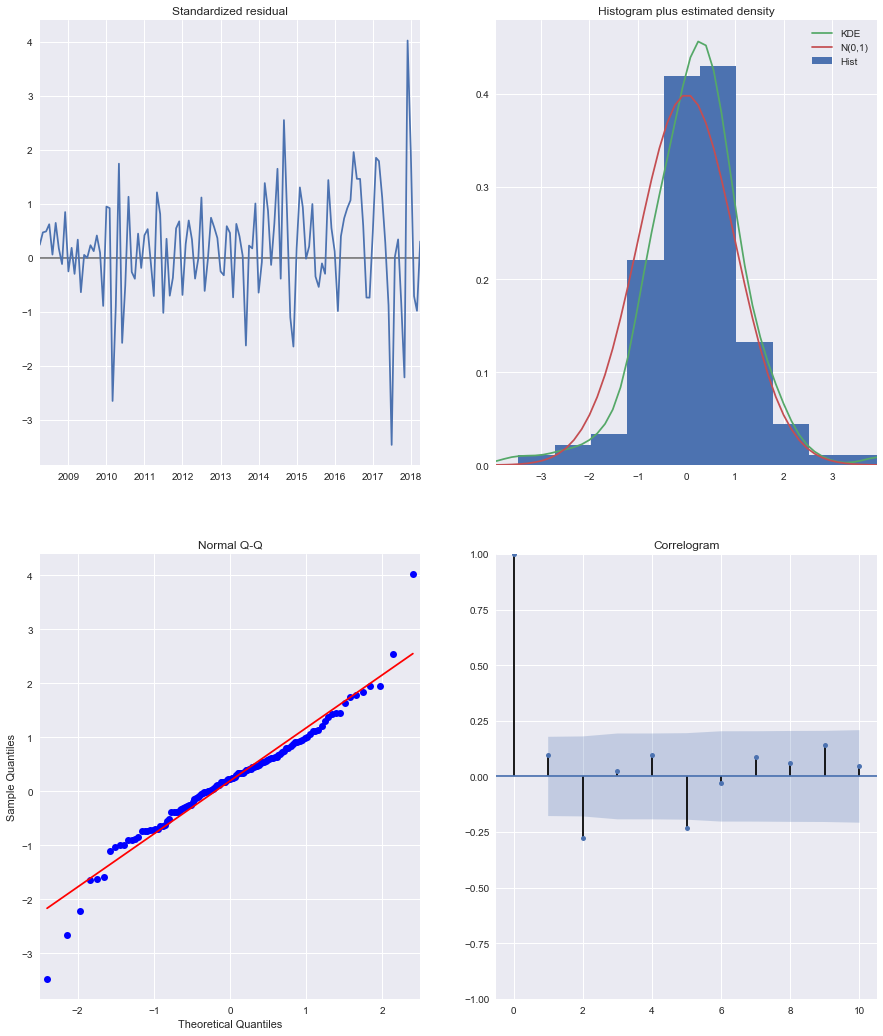

In [78]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [79]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

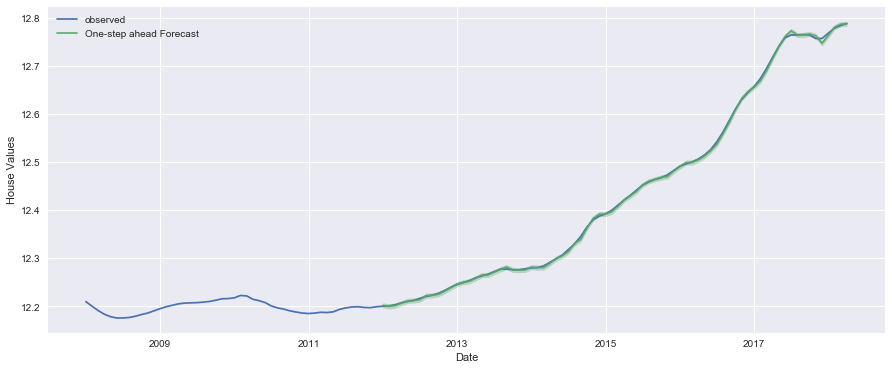

In [80]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_75218['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [81]:
#get the real and predicted values
dfw_75218_forecasted = pred.predicted_mean
dfw_75218_truth = log_75218['2012-01-01':].values

#compute the mean square error
rmse_75218 = np.sqrt(((dfw_75218_forecasted - dfw_75218_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_75218, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [82]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

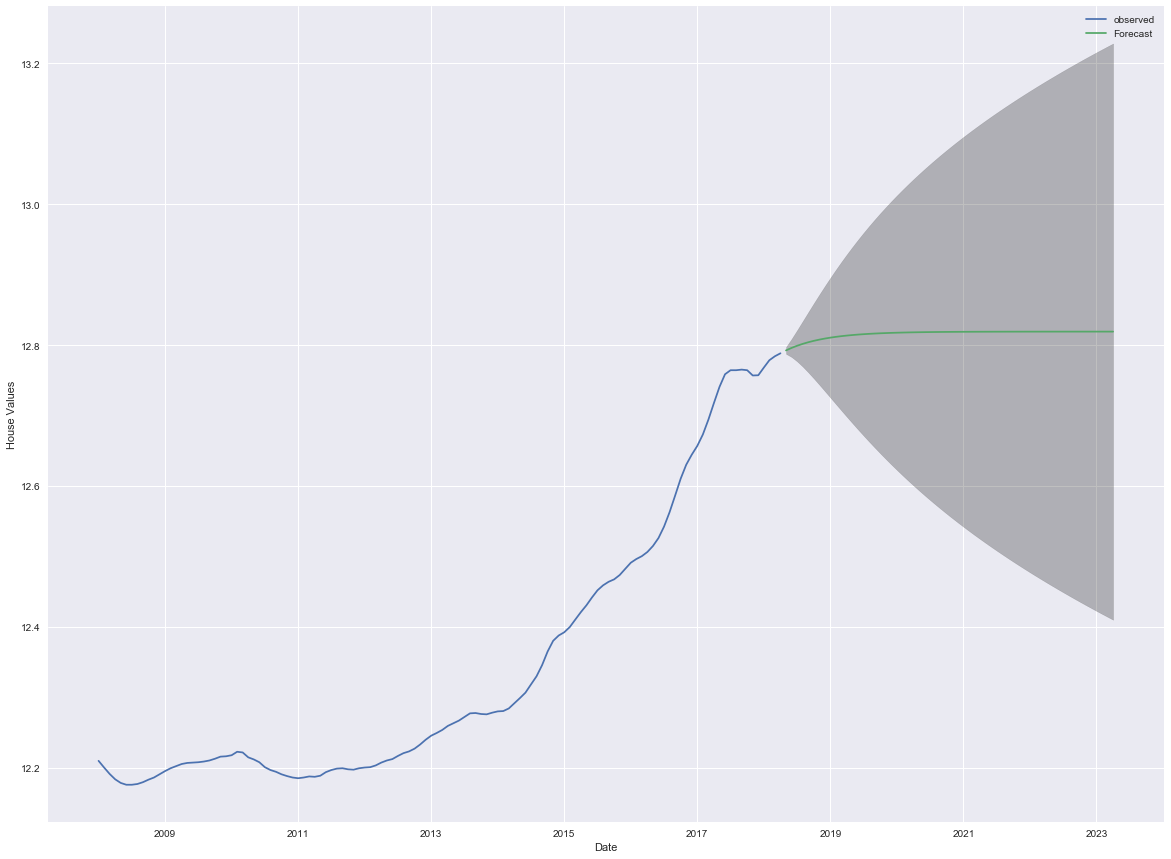

In [83]:
#plot future predictions with confidence intervals

ax = log_75218.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Dallas-Fort Worth 75080

In [84]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_75080,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =966.6206652010993
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =873.9116944041383
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-229.2198875314654
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-201.57339161073776
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-301.04187490542853
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-308.37143290071606
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-319.93830841558247
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-314.3325162055848
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =797.4978400419926
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =721.3151250420063
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-372.3537922893384
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-266.19074155606404
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-313.3058860932601
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-435.1385397489166
ARIMA

In [85]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1133.67
Name: 56, dtype: object

In [86]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_75080,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8746      0.039     22.387      0.000       0.798       0.951
ma.L1          0.6513      0.069      9.464      0.000       0.516       0.786
sigma2      4.729e-06   6.01e-07      7.866      0.000    3.55e-06    5.91e-06


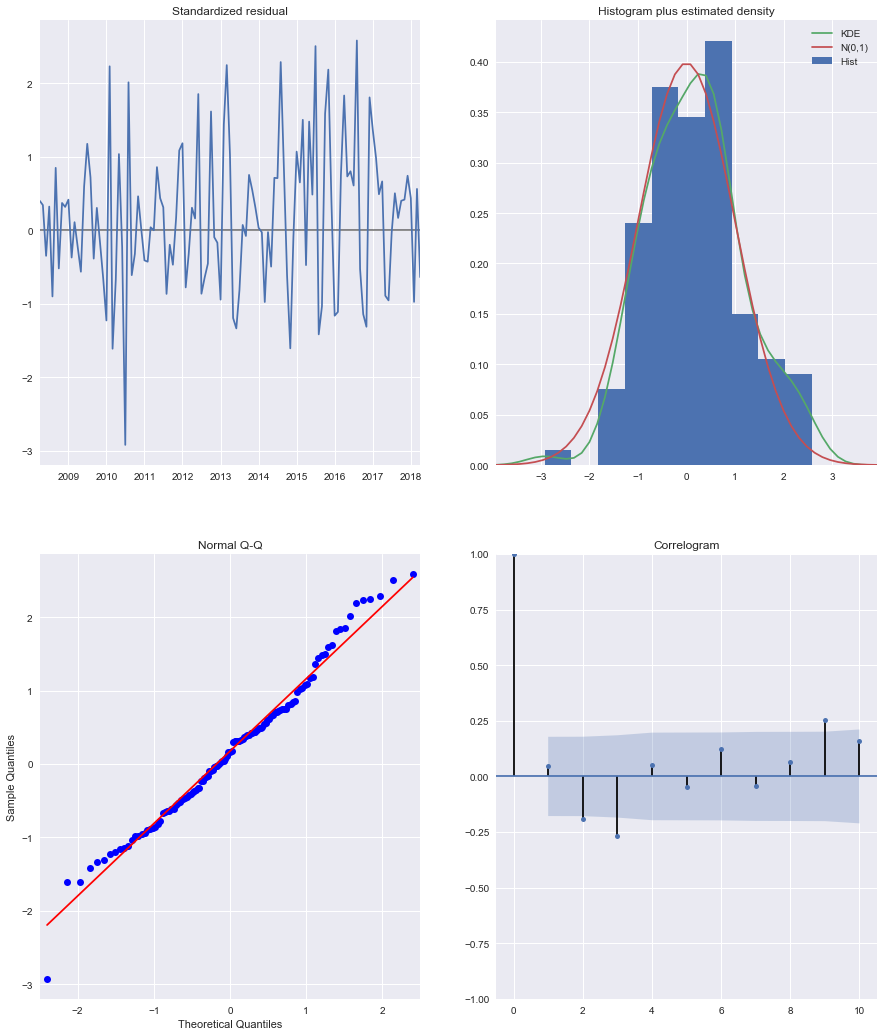

In [87]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [88]:
#get predictions starting from 2016-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

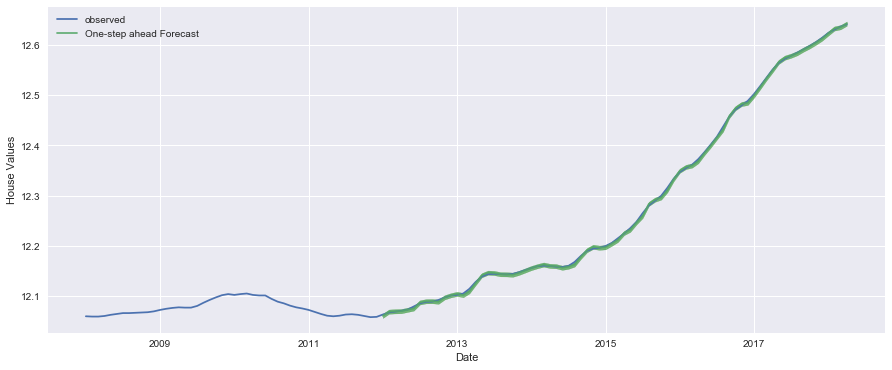

In [89]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_75080['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [90]:
#get the real and predicted values
dfw_75080_forecasted = pred.predicted_mean
dfw_75080_truth = log_75080['2012-01-01':].values

#compute the mean square error
rmse_75080 = np.sqrt(((dfw_75080_forecasted - dfw_75080_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_75080, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [91]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

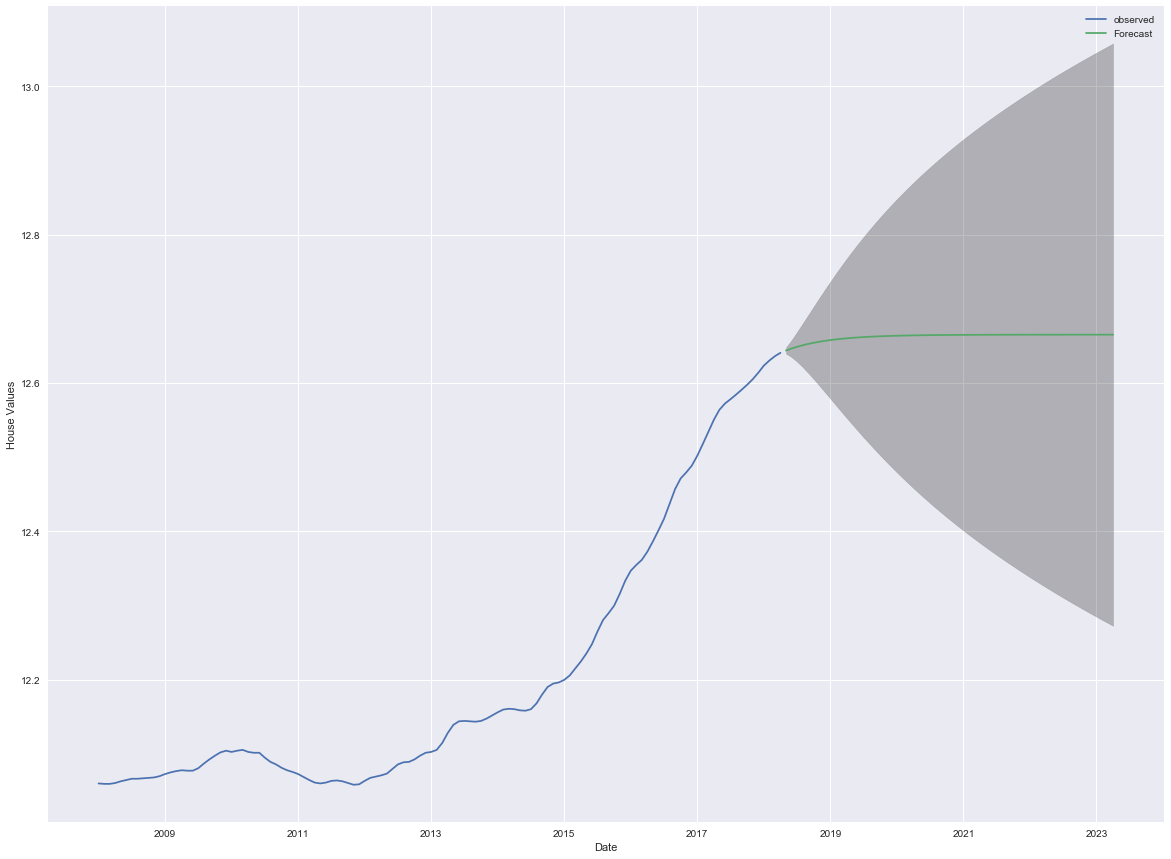

In [92]:
#plot future predictions with confidence intervals

ax = log_75080.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Step 6: Interpreting Results

# Dallas-Fort Worth 75234

In [93]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_75234,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =959.4210601445127
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =866.9902158906133
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-170.09145770827018
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-178.93696736029693
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-203.76822736049058
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-207.63501712888709
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-211.21611023348186
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-203.77444076670258
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =949.0469715833207
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =857.0808458883856
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-313.578408324489
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-205.05078751200583
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-205.97119571748016
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-229.88003427884857
AR

In [94]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1085.71
Name: 56, dtype: object

In [95]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_75234,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9018      0.026     34.554      0.000       0.851       0.953
ma.L1          0.6368      0.062     10.341      0.000       0.516       0.757
sigma2      7.039e-06   7.23e-07      9.734      0.000    5.62e-06    8.46e-06


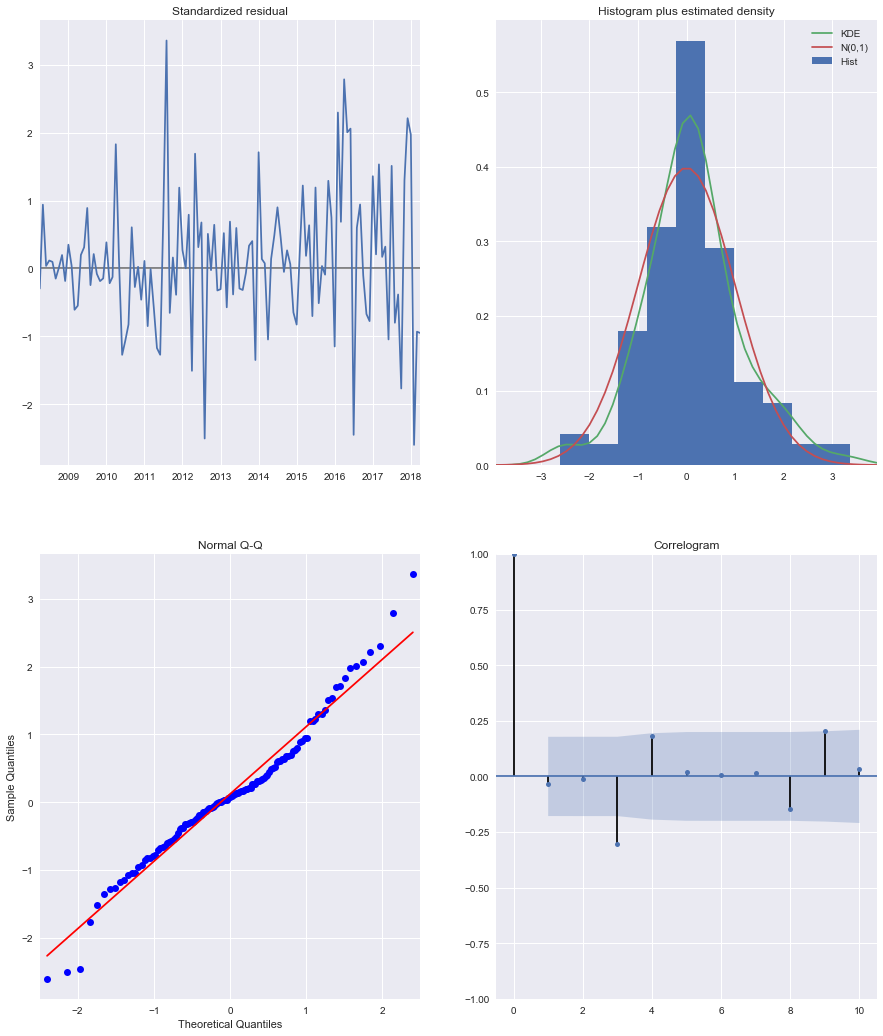

In [96]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [97]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

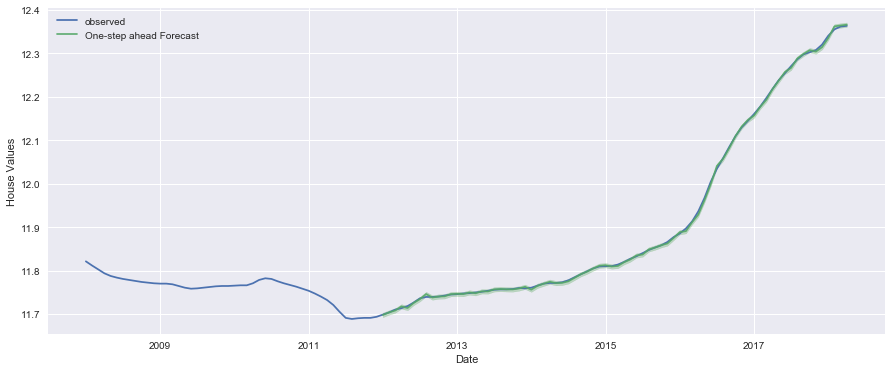

In [98]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_75234['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [99]:
#get the real and predicted values
dfw_75234_forecasted = pred.predicted_mean
dfw_75234_truth = log_75234['2012-01-01':].values

#compute the mean square error
rmse_75234 = np.sqrt(((dfw_75234_forecasted - dfw_75234_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_75234, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [100]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

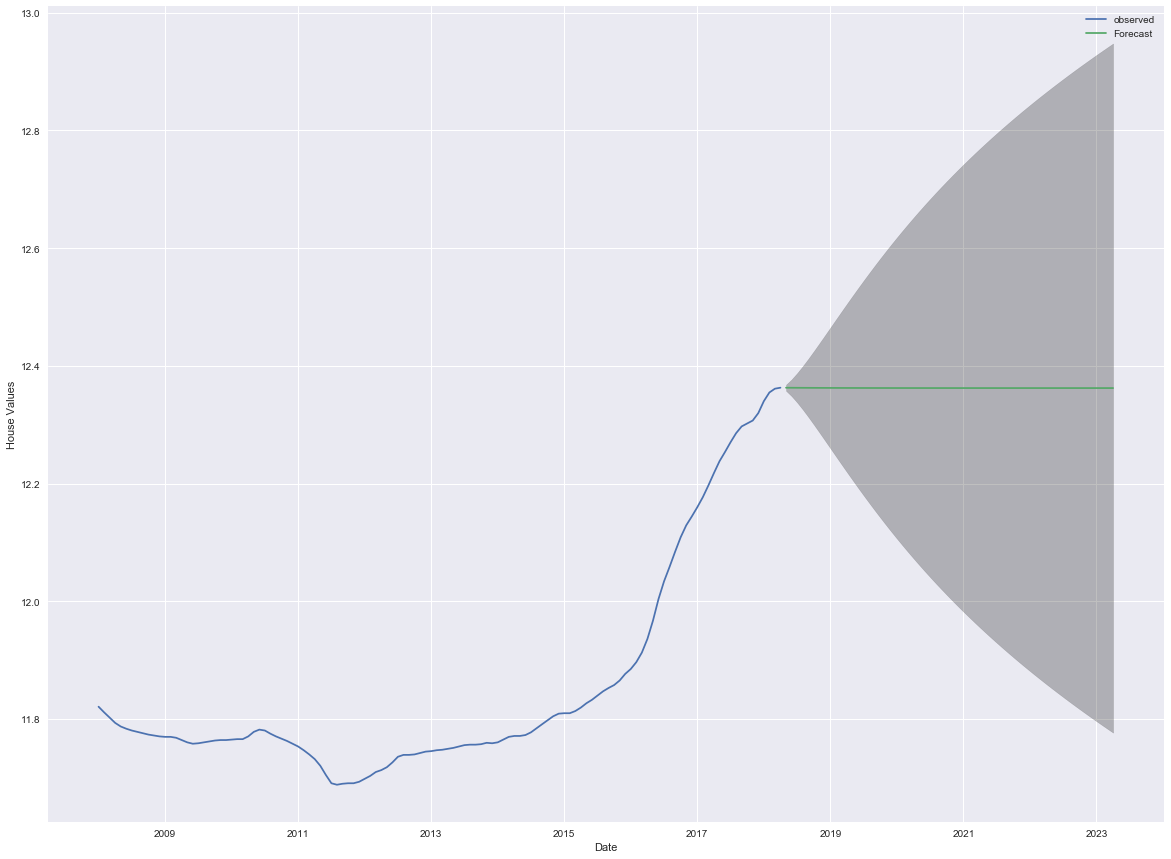

In [101]:
#plot future predictions with confidence intervals

ax = log_75234.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Dallas-Fort Worth 75081

In [102]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_75081,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =963.9507487018301
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =870.9832670917398
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-212.3396993067837
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-188.3669122930377
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-268.24719244172684
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-273.212234335761
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-247.62216566977358
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-241.78155760133146
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =794.8469374014364
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =867.8020224437486
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-355.58450442046455
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-255.19124418196685
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-263.47816419502783
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-426.5150836470087
ARIMA

In [103]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1069.38
Name: 56, dtype: object

In [104]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_75081,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8435      0.059     14.305      0.000       0.728       0.959
ma.L1          0.6492      0.068      9.499      0.000       0.515       0.783
sigma2      8.065e-06    9.3e-07      8.667      0.000    6.24e-06    9.89e-06


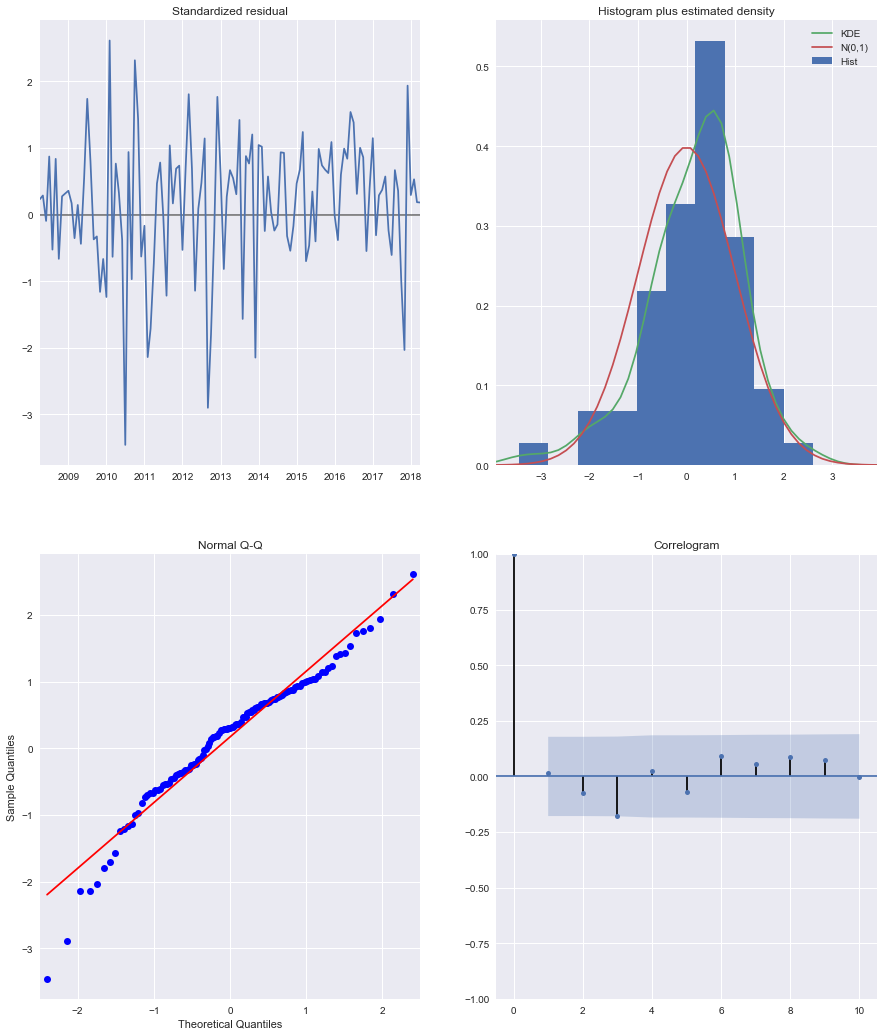

In [105]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [106]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

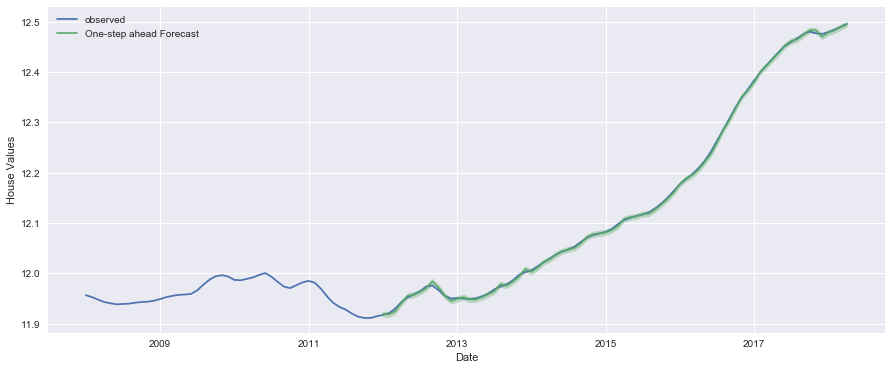

In [107]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_75081['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [108]:
#get the real and predicted values
dfw_75081_forecasted = pred.predicted_mean
dfw_75081_truth = log_75081['2012-01-01':].values

#compute the mean square error
rmse_75081 = np.sqrt(((dfw_75081_forecasted - dfw_75081_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_75081, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [109]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

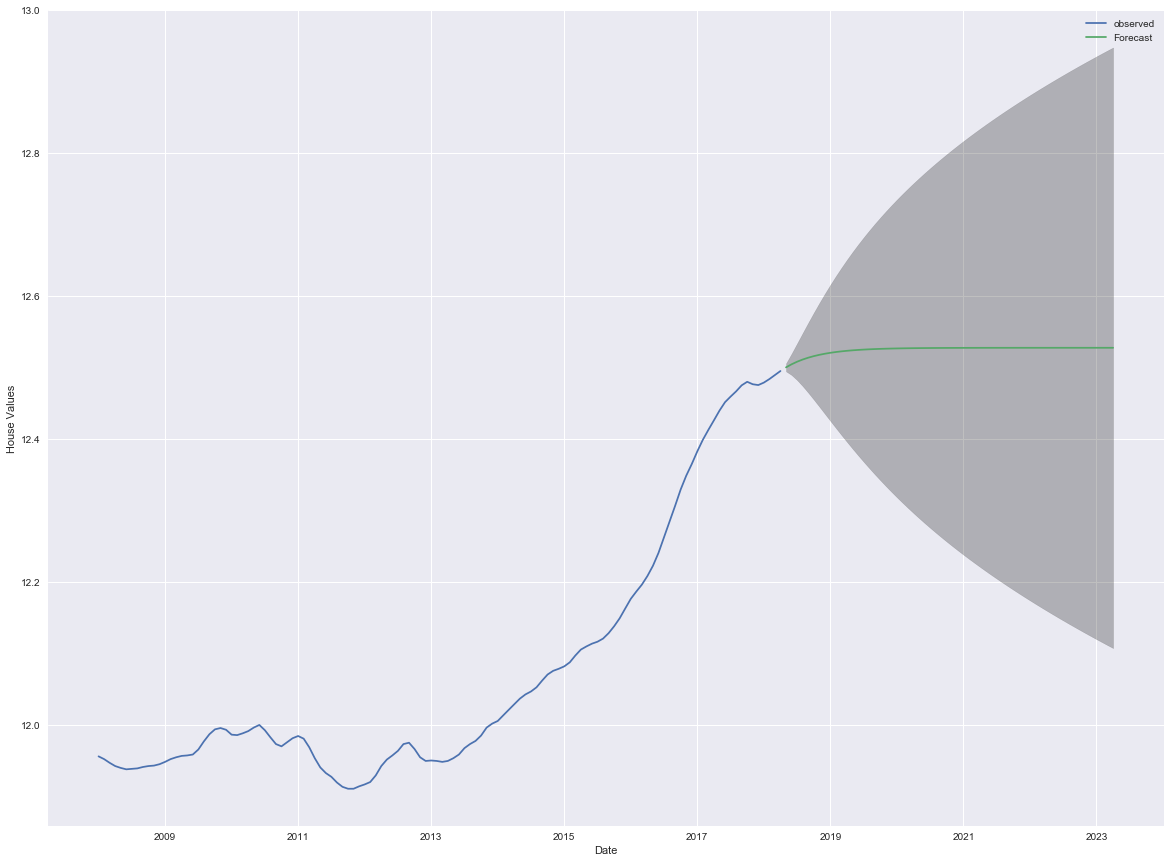

In [110]:
#plot future predictions with confidence intervals

ax = log_75081.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Dallas-Fort Worth 75235

In [111]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_75235,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =952.9033130085436
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =858.8414639471217
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-139.84291545512474
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-126.66252406123493
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-165.8274030232604
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-177.6938889712679
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-174.17885965148346
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-170.27465130991015
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =783.8887499022297
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =706.350312452869
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-283.98722908207156
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-255.40920456844827
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-311.96607839739744
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-300.2469713808634
ARIM

In [112]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC           -886.12
Name: 56, dtype: object

In [113]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_75235,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7680      0.050     15.433      0.000       0.670       0.866
ma.L1          0.6246      0.065      9.645      0.000       0.498       0.751
sigma2      3.666e-05    4.3e-06      8.518      0.000    2.82e-05    4.51e-05


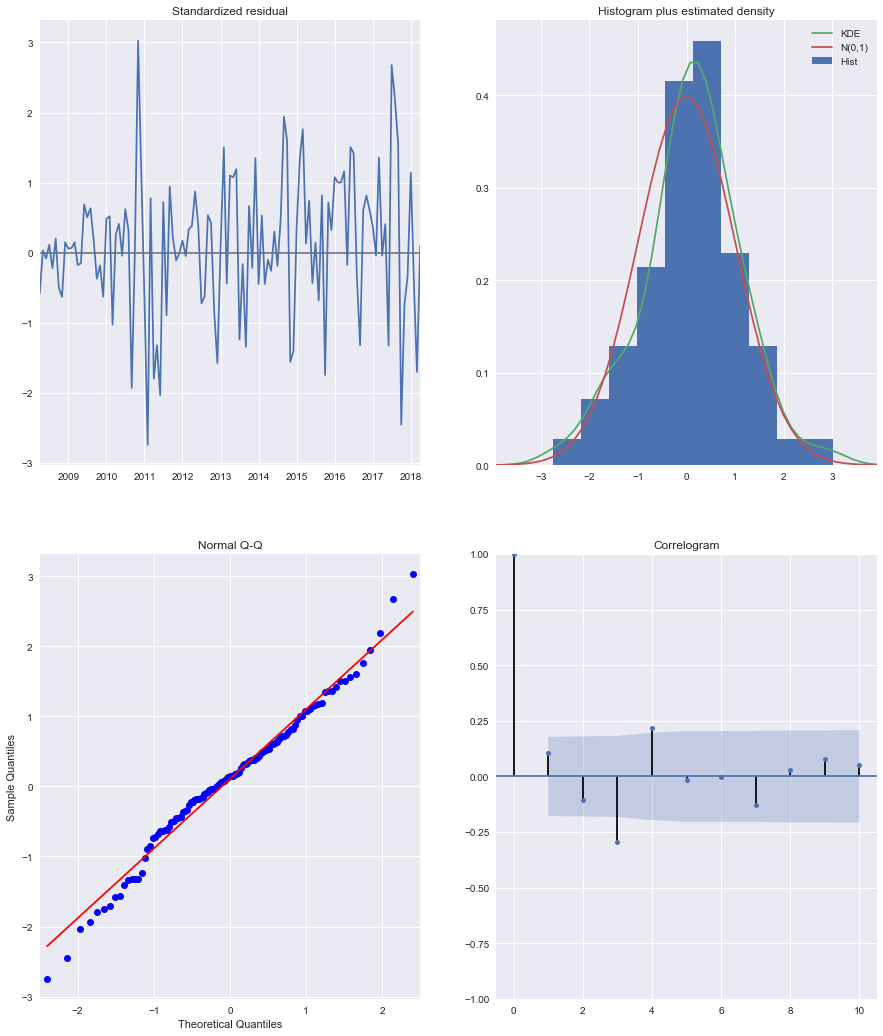

In [114]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [115]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

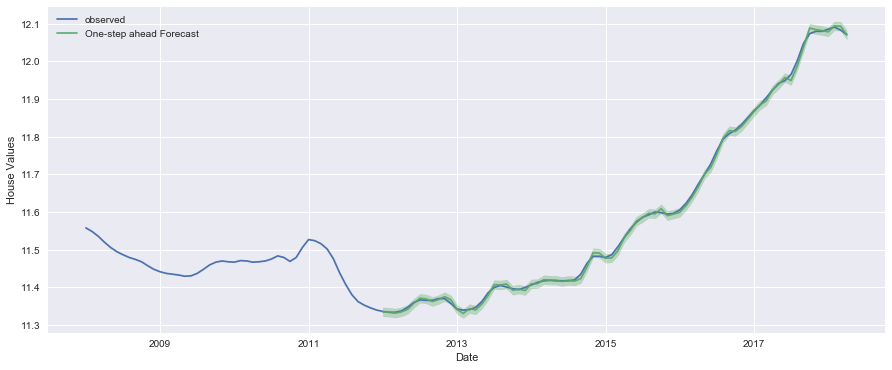

In [116]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_75235['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [117]:
#get the real and predicted values
dfw_75235_forecasted = pred.predicted_mean
dfw_75235_truth = log_75235['2012-01-01':].values

#compute the mean square error
rmse_75235 = np.sqrt(((dfw_75235_forecasted - dfw_75235_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_75235, 2)))

The Root Mean Squared Error of our forecasts is 0.01


In [118]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

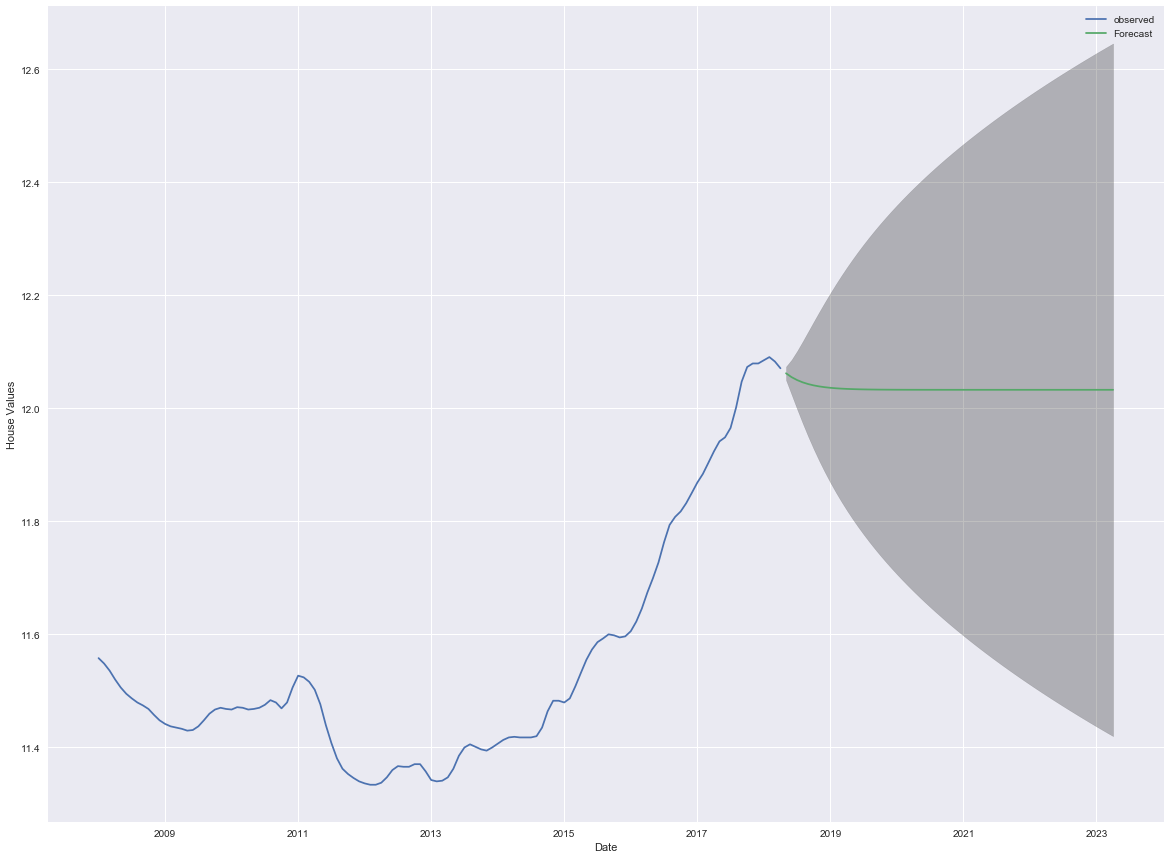

In [119]:
#plot future predictions with confidence intervals

ax = log_75235.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Raleigh-Durham 27707

In [120]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_27707,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =964.0197180448619
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =872.9145818050958
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-308.8503894457398
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-279.54229555058595
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-355.23602330295074
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-365.82260039897744
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-396.9549327092986
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-385.87545107649817
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =794.8996071109301
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =871.7190389339147
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-450.2053993359296
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-406.29804395725
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-502.1834043671841
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-306.95090207174235
ARIMA (

In [121]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1209.22
Name: 56, dtype: object

In [122]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_27707,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9191      0.036     25.434      0.000       0.848       0.990
ma.L1          0.3872      0.083      4.660      0.000       0.224       0.550
sigma2      2.537e-06   3.02e-07      8.390      0.000    1.94e-06    3.13e-06


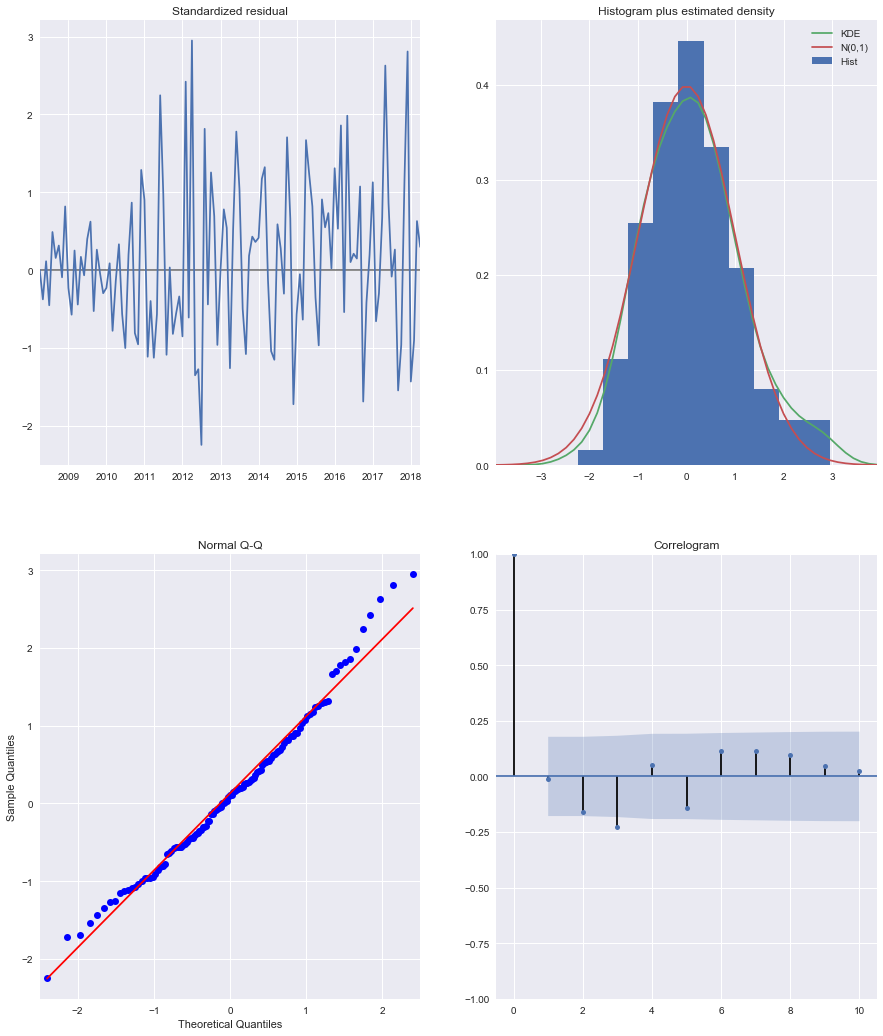

In [123]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [124]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

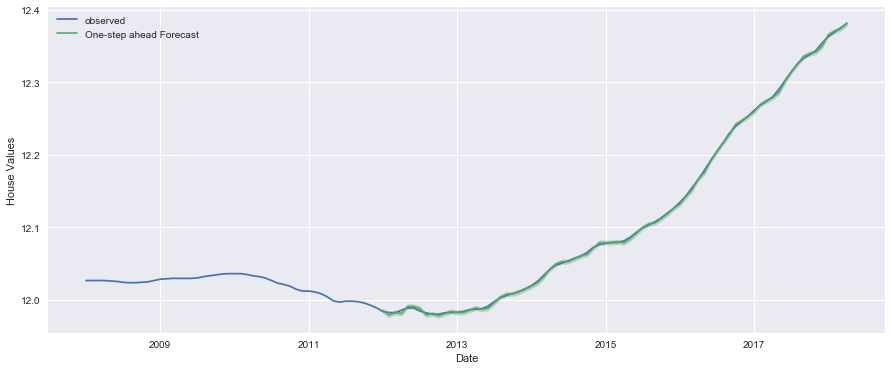

In [125]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_27707['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [126]:
#get the real and predicted values
rdu_27707_forecasted = pred.predicted_mean
rdu_27707_truth = log_27707['2012-01-01':].values

#compute the mean square error
rmse_27707 = np.sqrt(((rdu_27707_forecasted - rdu_27707_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_27707, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [127]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

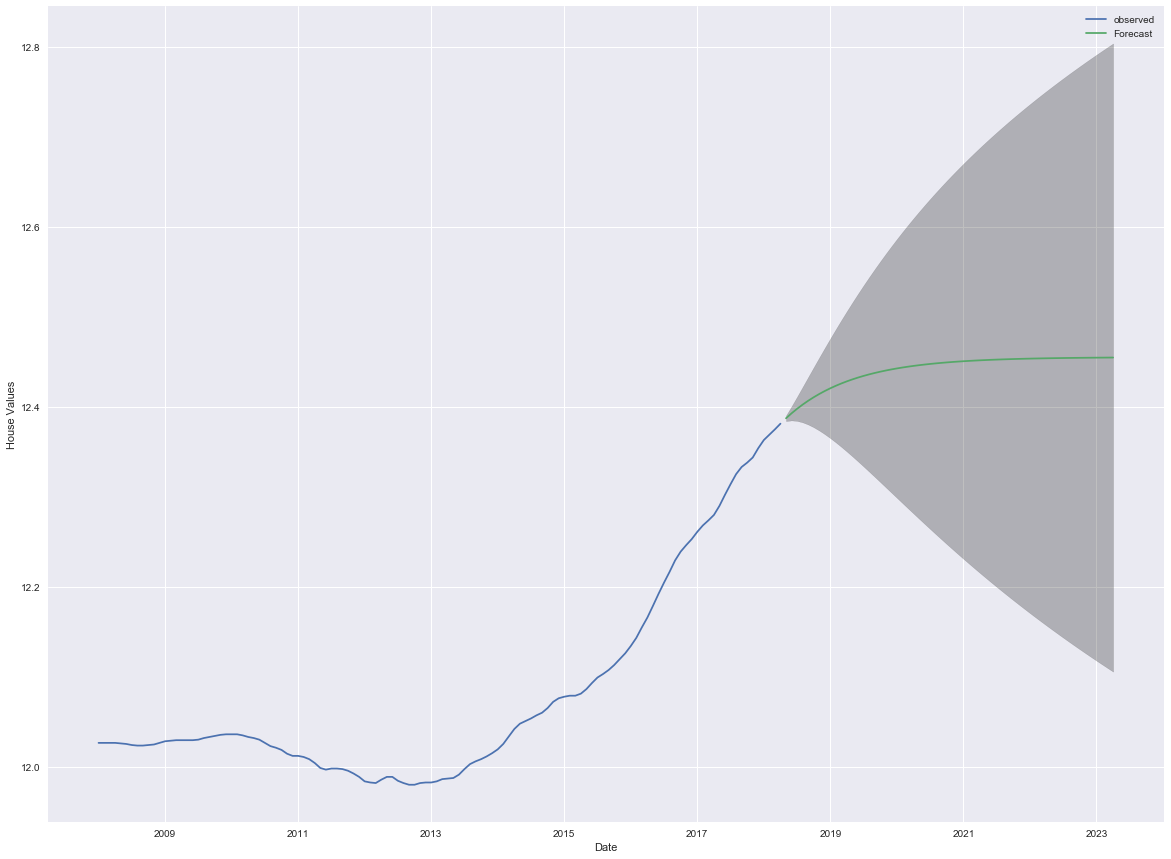

In [128]:
#plot future predictions with confidence intervals

ax = log_27707.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Raleigh-Durham 27609

In [129]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_27609,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =970.4014741360229
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =876.7586221371741
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-290.3527383528008
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-290.0023041407771
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-328.77783261208674
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-357.27356062559
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-333.22093926035086
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-318.0212210486569
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =801.2293246414321
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =863.1442474032589
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-432.7554679447242
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-330.9655541532933
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-334.68182033824473
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-307.28159154695516
ARIMA (0

In [130]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1161.44
Name: 56, dtype: object

In [131]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_27609,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8719      0.046     18.778      0.000       0.781       0.963
ma.L1          0.5123      0.091      5.625      0.000       0.334       0.691
sigma2      3.954e-06    6.7e-07      5.905      0.000    2.64e-06    5.27e-06


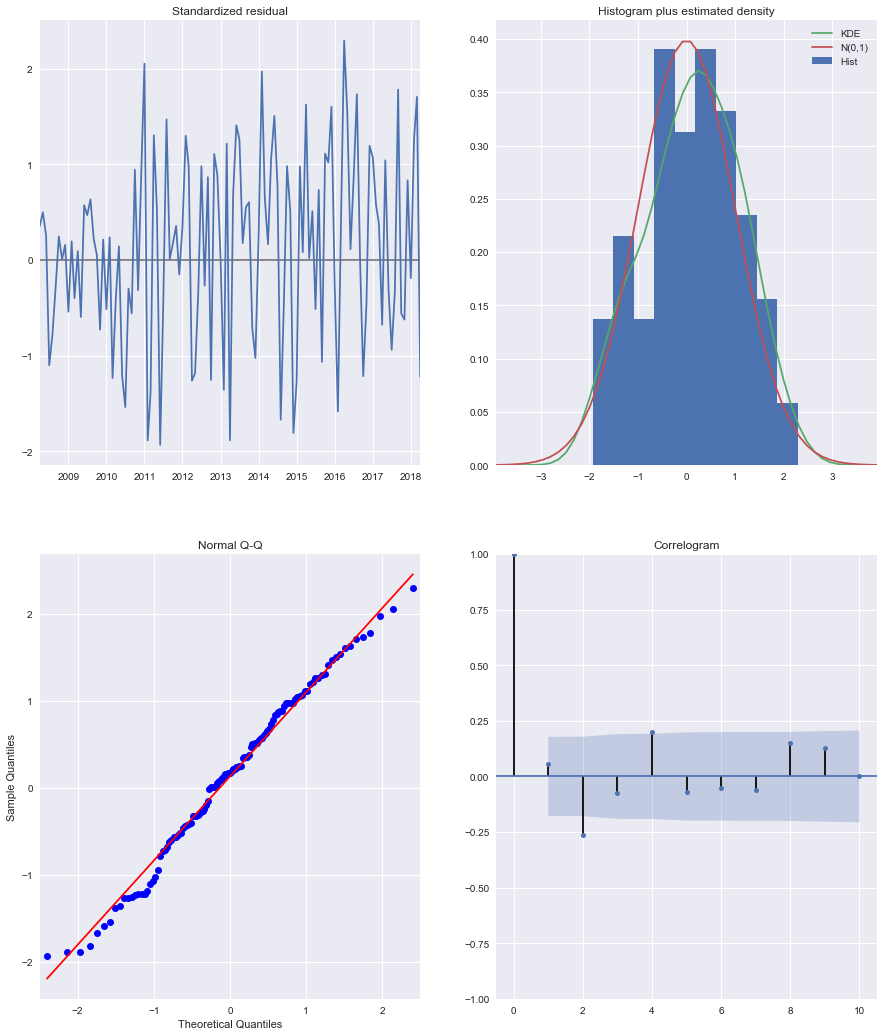

In [132]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [133]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

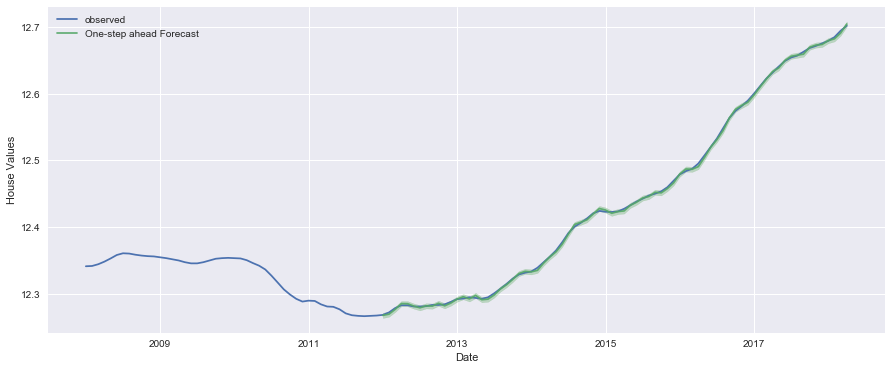

In [134]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_27609['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [135]:
#get the real and predicted values
rdu_27609_forecasted = pred.predicted_mean
rdu_27609_truth = log_27609['2012-01-01':].values

#compute the mean square error
rmse_27609 = np.sqrt(((rdu_27609_forecasted - rdu_27609_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_27609, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [136]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

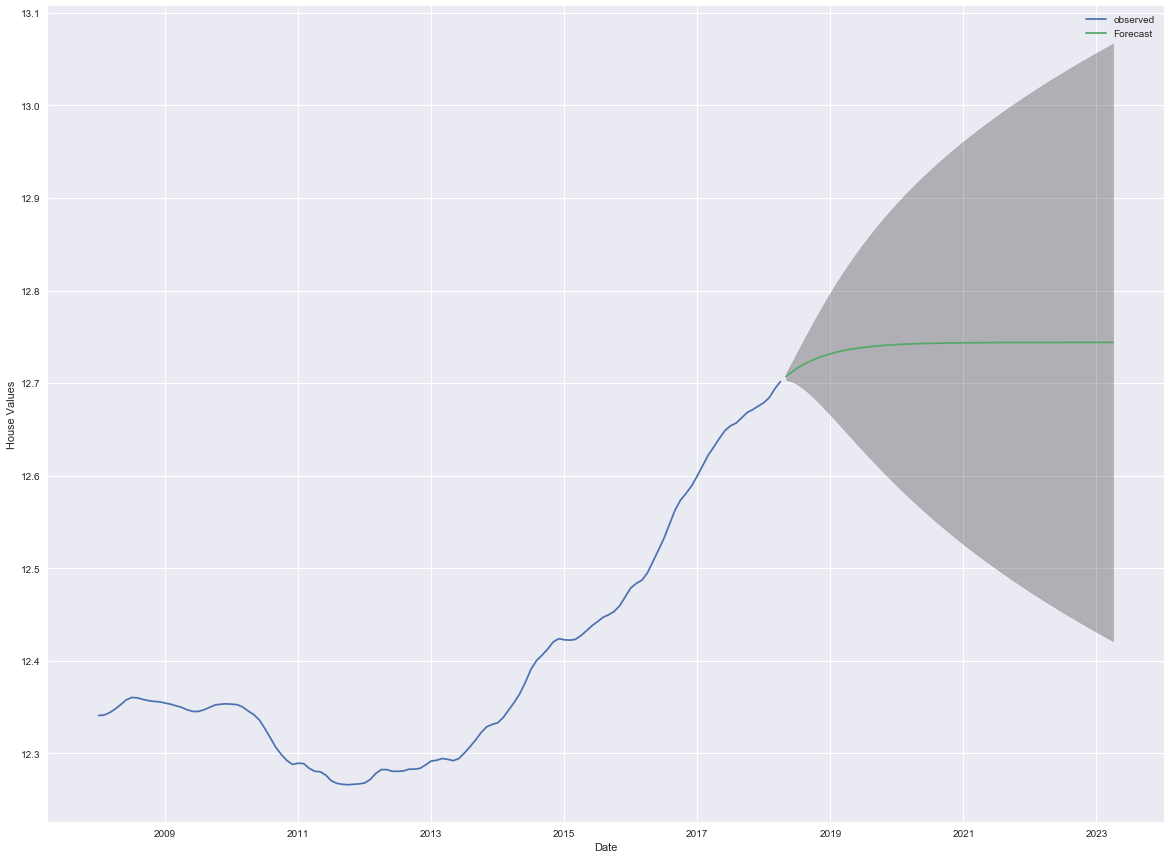

In [137]:
#plot future predictions with confidence intervals

ax = log_27609.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Raleigh-Durham 27705

In [138]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_27705,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =967.0724333703429
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =878.0843867446641
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-319.53469028533
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-286.45926243286533
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-370.2658541386429
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-377.7165797736956
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-360.9514713818401
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-353.65765934980476
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =797.9264564297561
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =858.5032074821177
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-461.4981476424992
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-352.7740706707792
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-382.2335641531447
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-336.3317563563648
ARIMA (0, 

In [139]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1183.81
Name: 56, dtype: object

In [140]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_27705,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9017      0.049     18.317      0.000       0.805       0.998
ma.L1          0.7574      0.070     10.855      0.000       0.621       0.894
sigma2      3.117e-06   3.66e-07      8.517      0.000     2.4e-06    3.83e-06


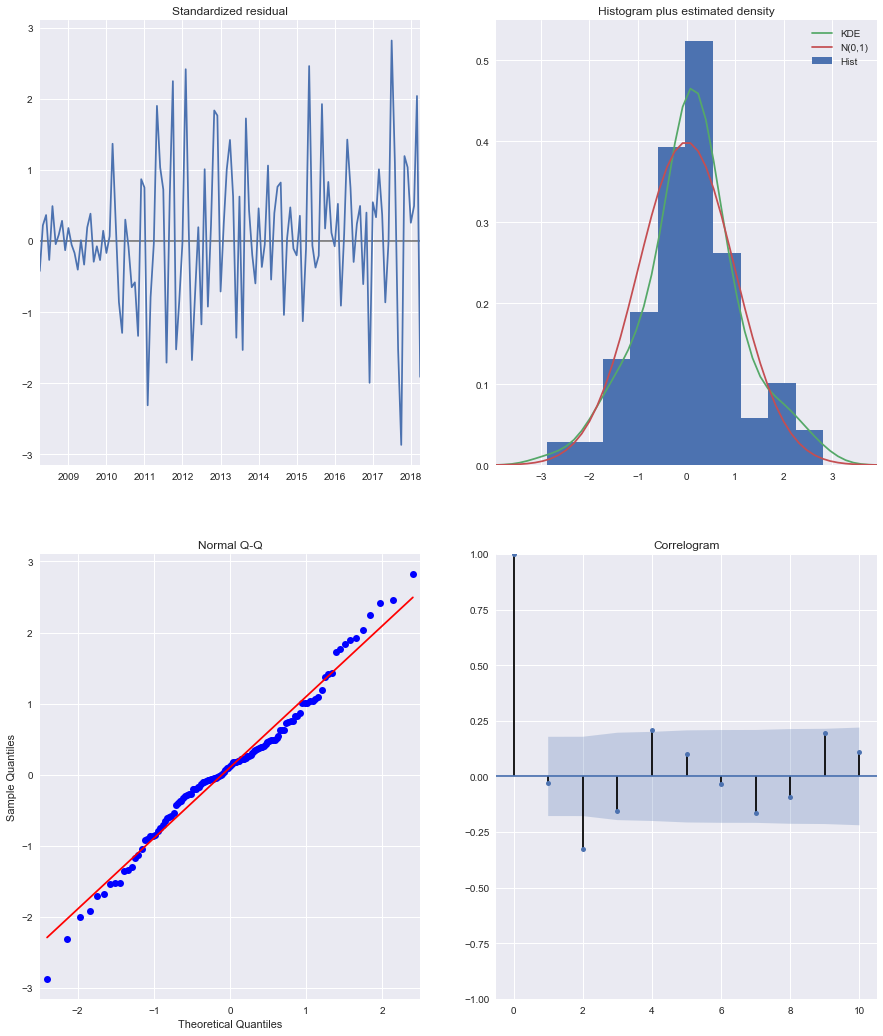

In [141]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [142]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

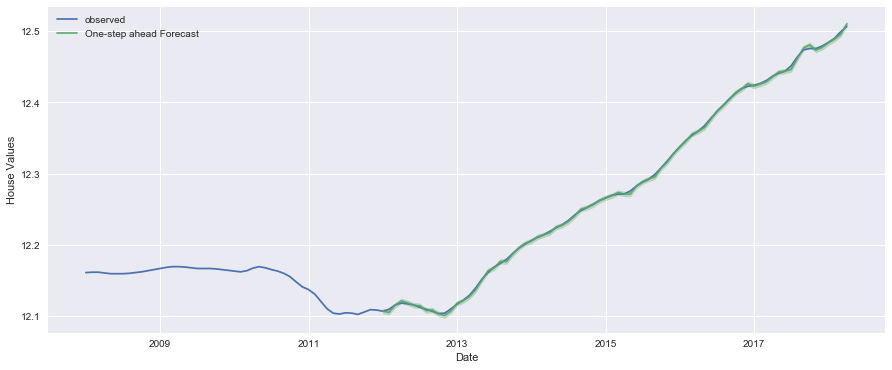

In [143]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_27705['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [144]:
#get the real and predicted values
rdu_27705_forecasted = pred.predicted_mean
rdu_27705_truth = log_27705['2012-01-01':].values

#compute the mean square error
rmse_27705 = np.sqrt(((rdu_27705_forecasted - rdu_27705_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_27705, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [145]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

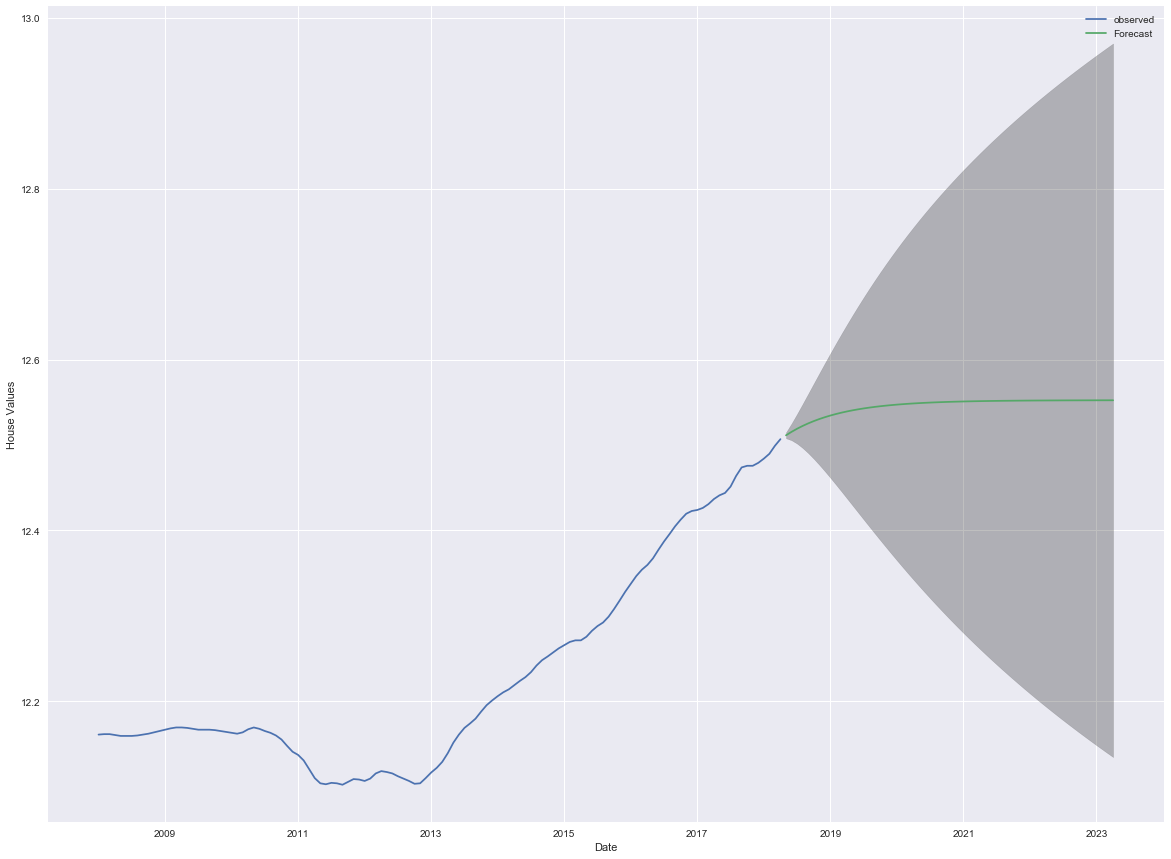

In [146]:
#plot future predictions with confidence intervals

ax = log_27705.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Raleigh-Durham 27704

In [147]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_27704,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =956.8452226928783
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =751.156307025656
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-291.4433568050752
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-300.1693285073327
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-309.4667410274197
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-318.0879168693812
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-327.5159057762171
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-323.86192536970503
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =952.1315112241017
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =598.6250953340598
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-432.4734461027151
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-390.9290093608775
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-456.04073387441076
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-498.06011612249506
ARIMA (0

In [148]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1140.48
Name: 56, dtype: object

In [149]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_27704,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8660      0.052     16.549      0.000       0.763       0.969
ma.L1          0.5026      0.087      5.755      0.000       0.331       0.674
sigma2      4.485e-06   5.35e-07      8.382      0.000    3.44e-06    5.53e-06


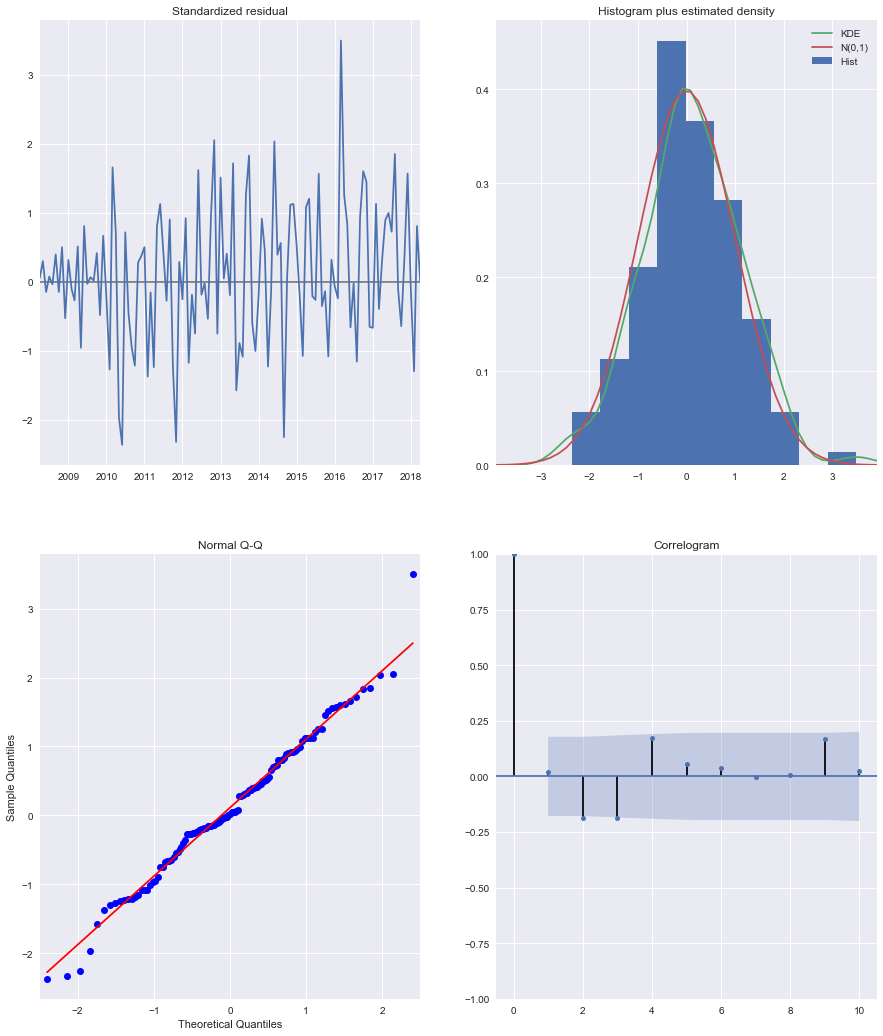

In [150]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [151]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

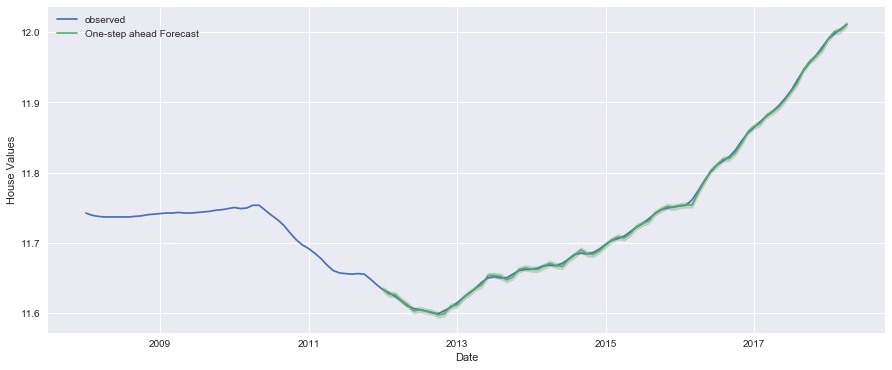

In [152]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_27704['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [153]:
#get the real and predicted values
rdu_27704_forecasted = pred.predicted_mean
rdu_27704_truth = log_27704['2012-01-01':].values

#compute the mean square error
rmse_27704 = np.sqrt(((rdu_27704_forecasted - rdu_27704_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_27704, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [154]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

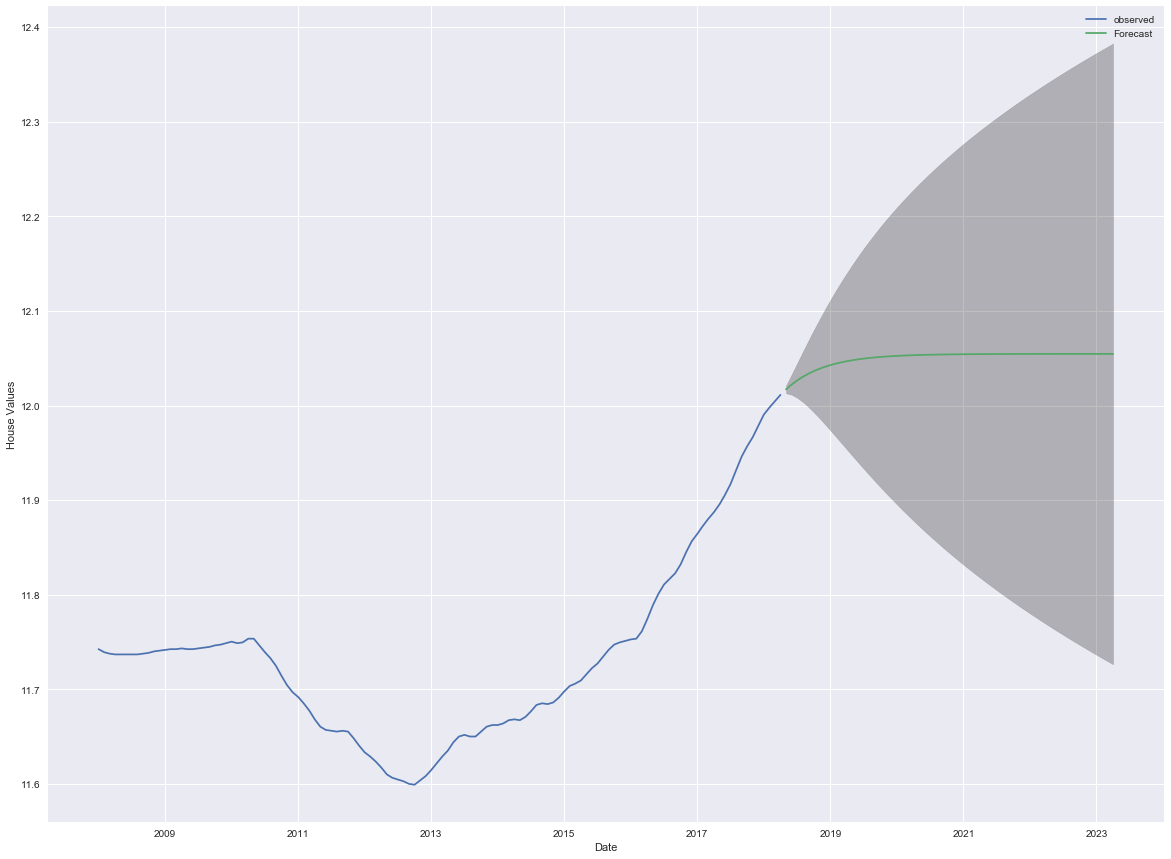

In [155]:
#plot future predictions with confidence intervals

ax = log_27704.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Raleigh-Durham 27607

In [156]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_27607,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =975.5394989963044
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =881.9040191897783
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-305.86727344657106
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-272.2431084002768
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-331.43489866997703
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-337.0958809116956
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-335.17108017595507
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-332.80338208399263
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =806.3186685850717
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =871.912411814225
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-448.1278950904417
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-400.1912414950297
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-333.60287919275964
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-309.97774384169975
ARIMA

In [157]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1209.54
Name: 56, dtype: object

In [158]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_27607,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8964      0.047     19.243      0.000       0.805       0.988
ma.L1          0.4641      0.073      6.342      0.000       0.321       0.608
sigma2      2.523e-06   2.74e-07      9.193      0.000    1.99e-06    3.06e-06


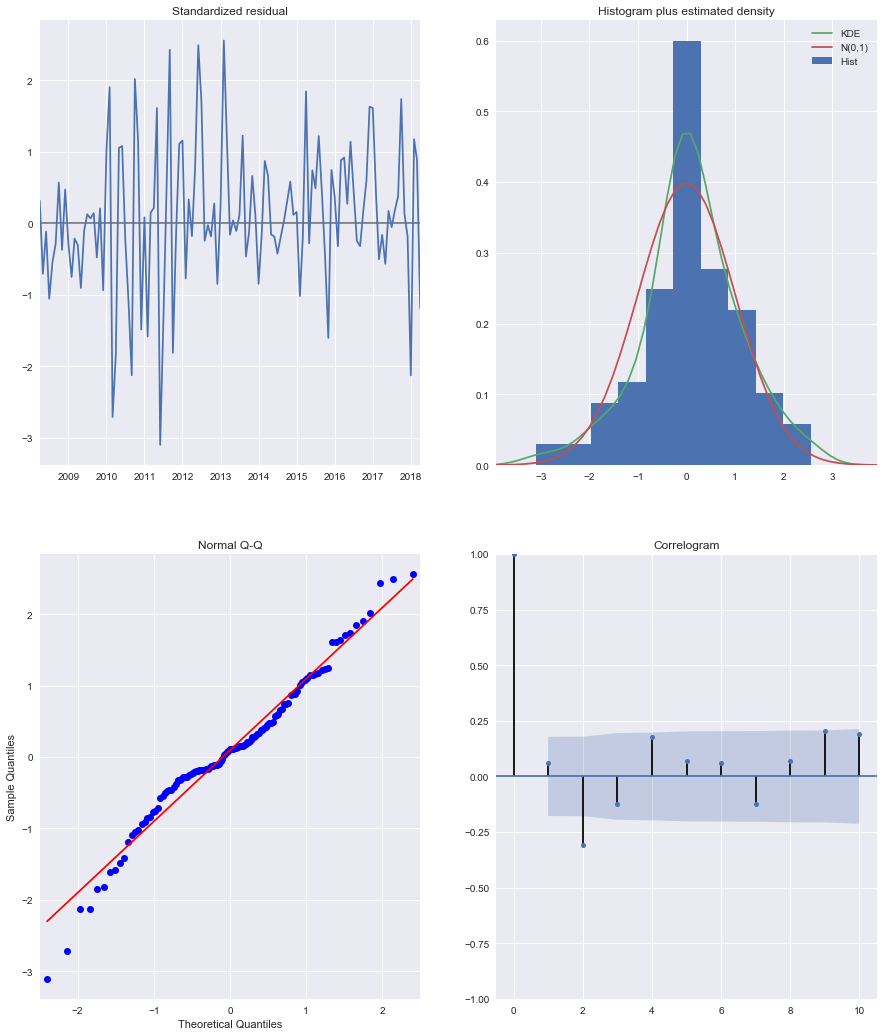

In [159]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [160]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

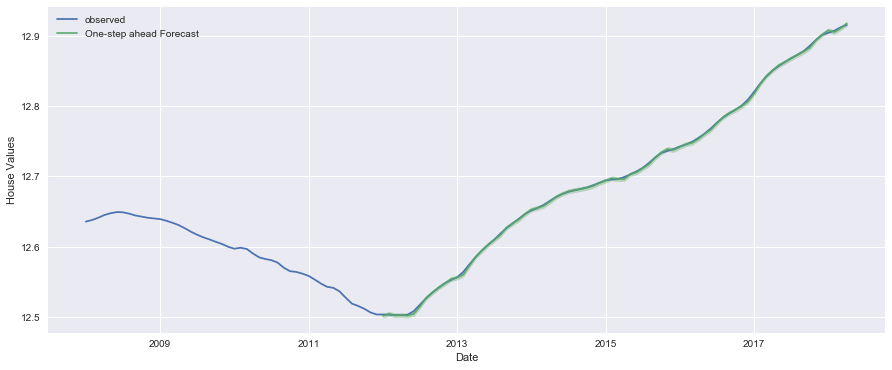

In [161]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_27607['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [162]:
#get the real and predicted values
rdu_27607_forecasted = pred.predicted_mean
rdu_27607_truth = log_27607['2012-01-01':].values

#compute the mean square error
rmse_27607 = np.sqrt(((rdu_27607_forecasted - rdu_27607_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_27607, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [163]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

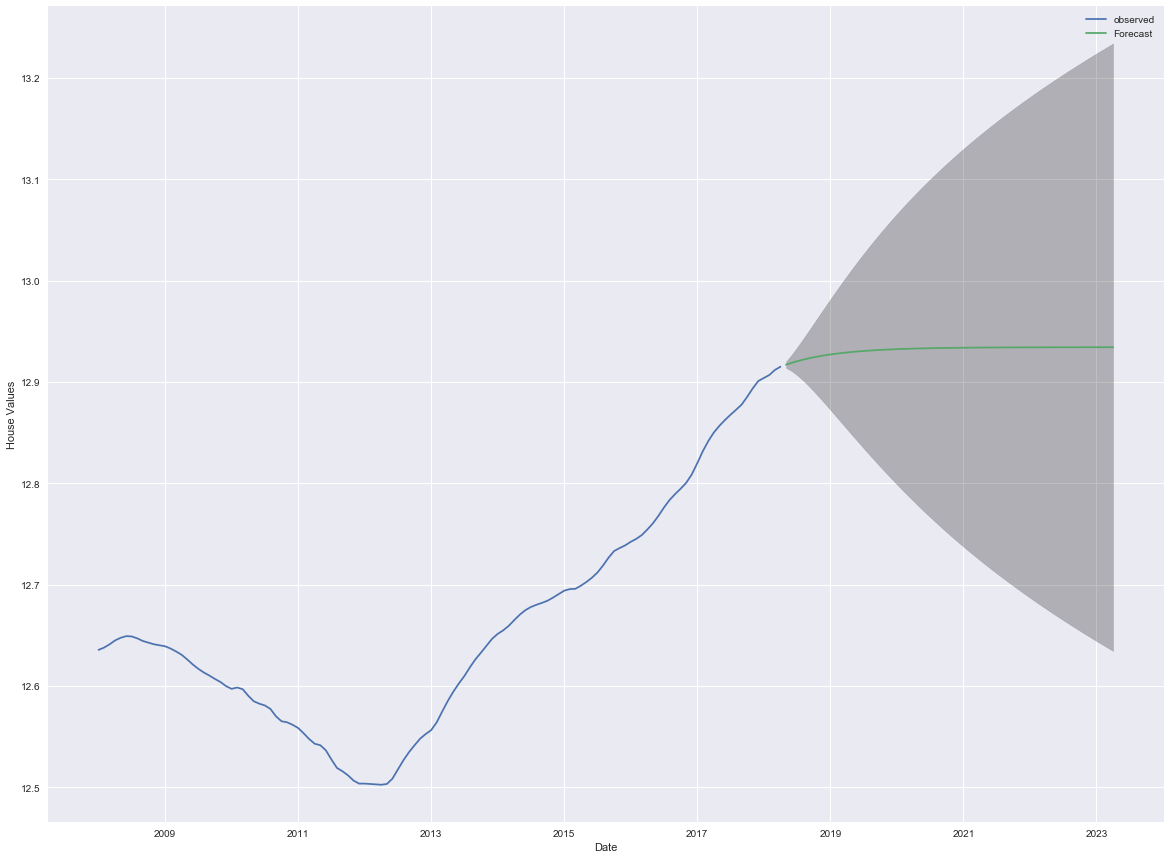

In [164]:
#plot future predictions with confidence intervals

ax = log_27607.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Nashville 37211

In [165]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_37211,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =963.13137787967
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =872.0815696111873
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-211.1343393990582
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-190.92749738631895
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-253.44192764665559
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-312.18553830178234
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-275.9858808598432
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-270.2877382275711
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =952.6068550384247
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =798.3919807077307
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-354.266058113255
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-259.7247974972762
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-255.7751168725481
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-238.3874769022578
ARIMA (0, 

In [166]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1100.41
Name: 56, dtype: object

In [167]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_37211,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9140      0.043     21.178      0.000       0.829       0.999
ma.L1          0.3584      0.122      2.927      0.003       0.118       0.598
sigma2      6.232e-06   6.68e-07      9.326      0.000    4.92e-06    7.54e-06


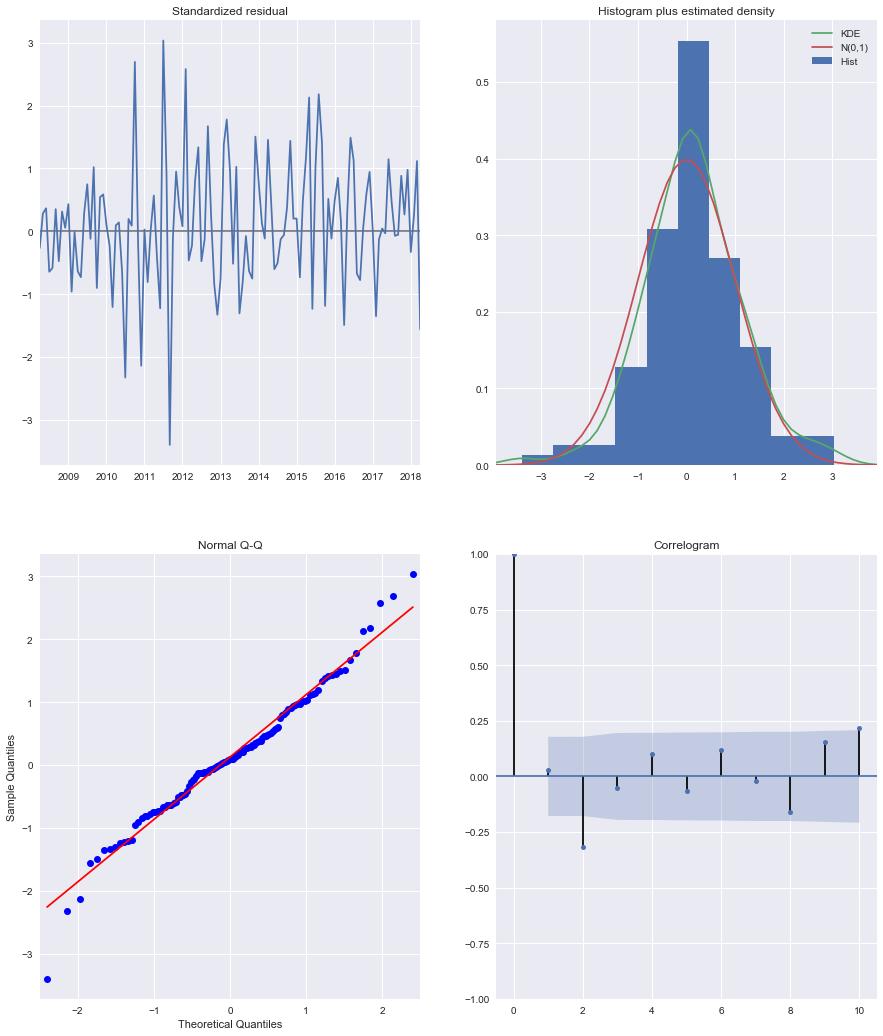

In [168]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [169]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

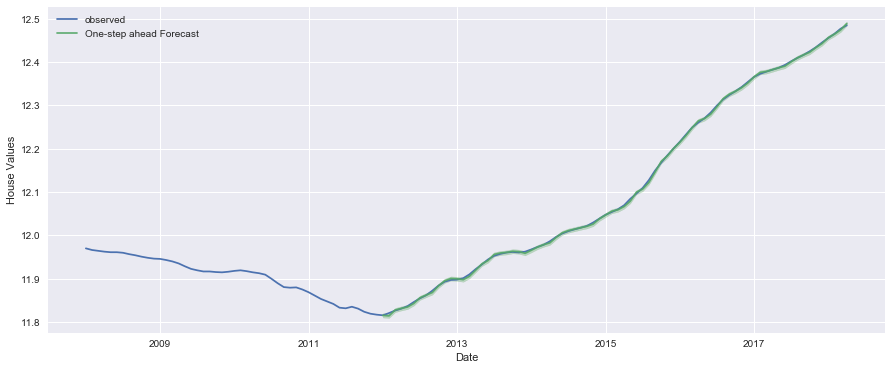

In [170]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_37211['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [171]:
#get the real and predicted values
nash_37211_forecasted = pred.predicted_mean
nash_37211_truth = log_37211['2012-01-01':].values

#compute the mean square error
rmse_37211 = np.sqrt(((nash_37211_forecasted - nash_37211_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_37211, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [172]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

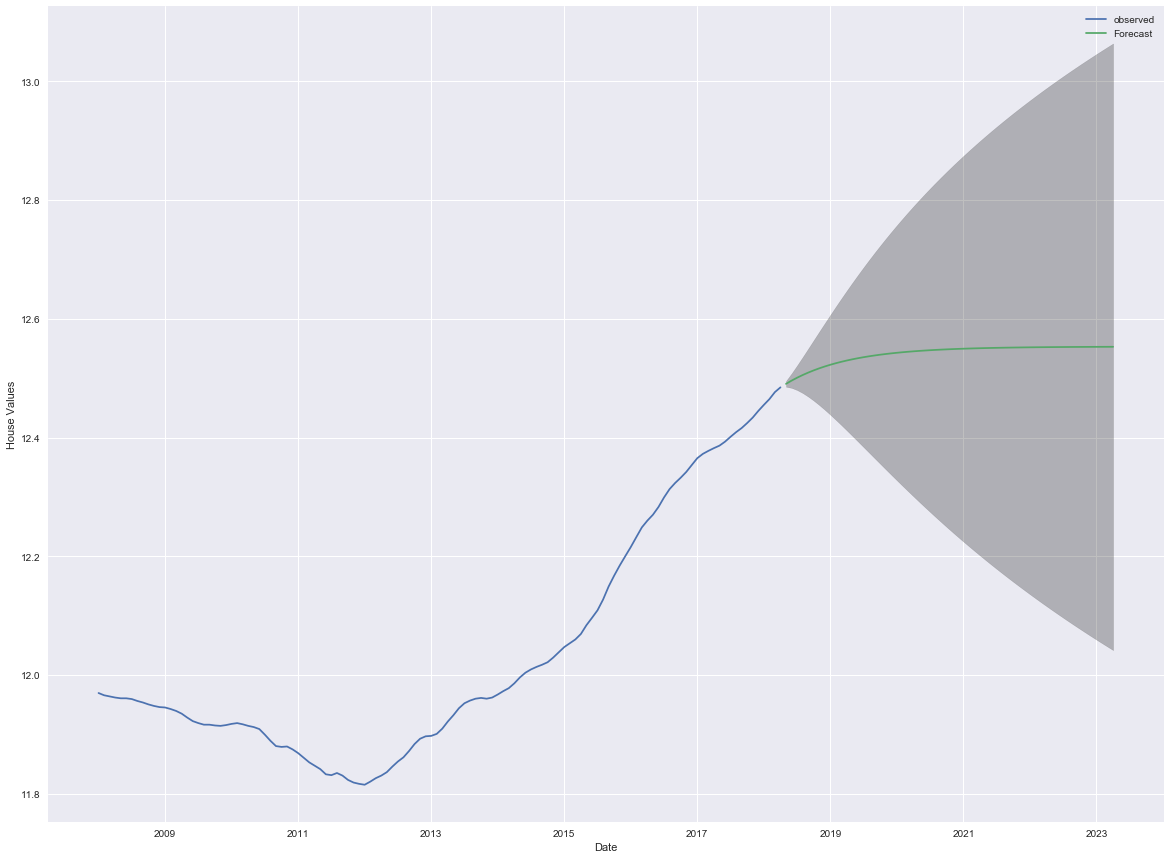

In [173]:
#plot future predictions with confidence intervals

ax = log_37211.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Nashville 37214

In [174]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_37214,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =959.9656295415225
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =867.6765737285704
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-216.67579558261443
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-251.54022645971202
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-253.68022219601647
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-311.2551409029053
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-337.8870734266229
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-326.71225616021155
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =790.89015923458
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =715.1301591319661
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-359.4921822220737
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-264.79998008499456
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-264.45583912859604
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-388.03184074804506
ARIMA

In [175]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1106.01
Name: 56, dtype: object

In [176]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_37214,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9080      0.038     23.759      0.000       0.833       0.983
ma.L1          0.3965      0.103      3.846      0.000       0.194       0.599
sigma2       5.97e-06   8.33e-07      7.164      0.000    4.34e-06     7.6e-06


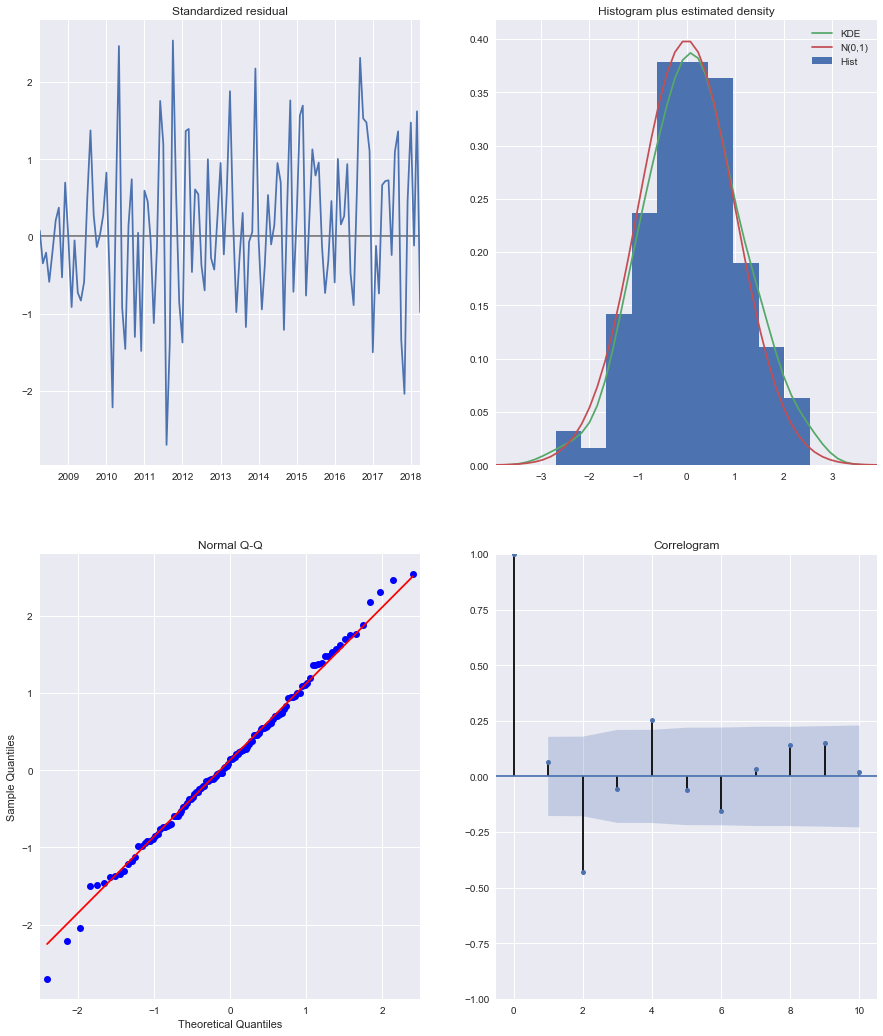

In [177]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [178]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

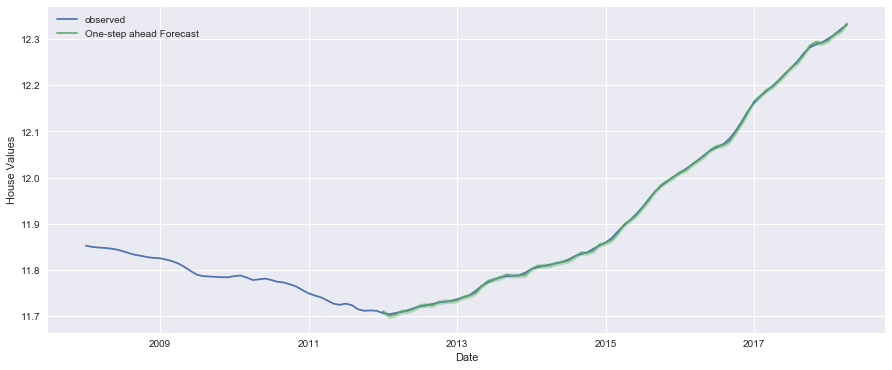

In [179]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_37214['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [180]:
#get the real and predicted values
nash_37214_forecasted = pred.predicted_mean
nash_37214_truth = log_37214['2012-01-01':].values

#compute the mean square error
rmse_37214 = np.sqrt(((nash_37214_forecasted - nash_37214_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_37214, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [181]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

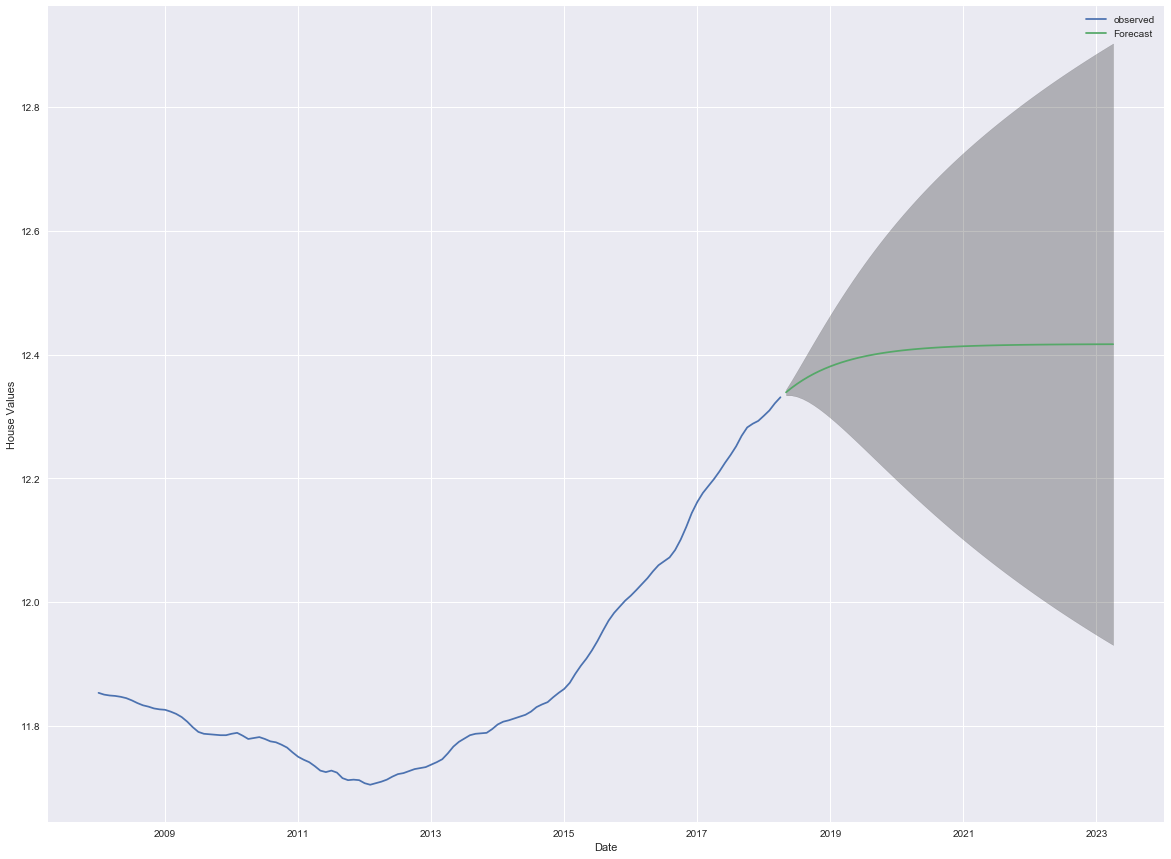

In [182]:
#plot future predictions with confidence intervals

ax = log_37214.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Nashville 37217

In [183]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_37217,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =958.9140461877714
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =864.9973966201921
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-211.6956842146255
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-198.64911895092797
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-236.71307103420315
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-250.48968813321432
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-320.55471495989013
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-316.80169320357646
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =948.4035723601063
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =854.978277724073
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-354.89412407622285
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-270.19842173215966
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-239.0462213934978
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-207.6814896031383
ARIM

In [184]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 0)
PDQs    (0, 0, 0, 12)
AIC          -1087.37
Name: 48, dtype: object

In [185]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_37217,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9311      0.035     26.772      0.000       0.863       0.999
ma.L1          0.1605      0.097      1.655      0.098      -0.030       0.351
sigma2       7.45e-06   1.12e-06      6.639      0.000    5.25e-06    9.65e-06


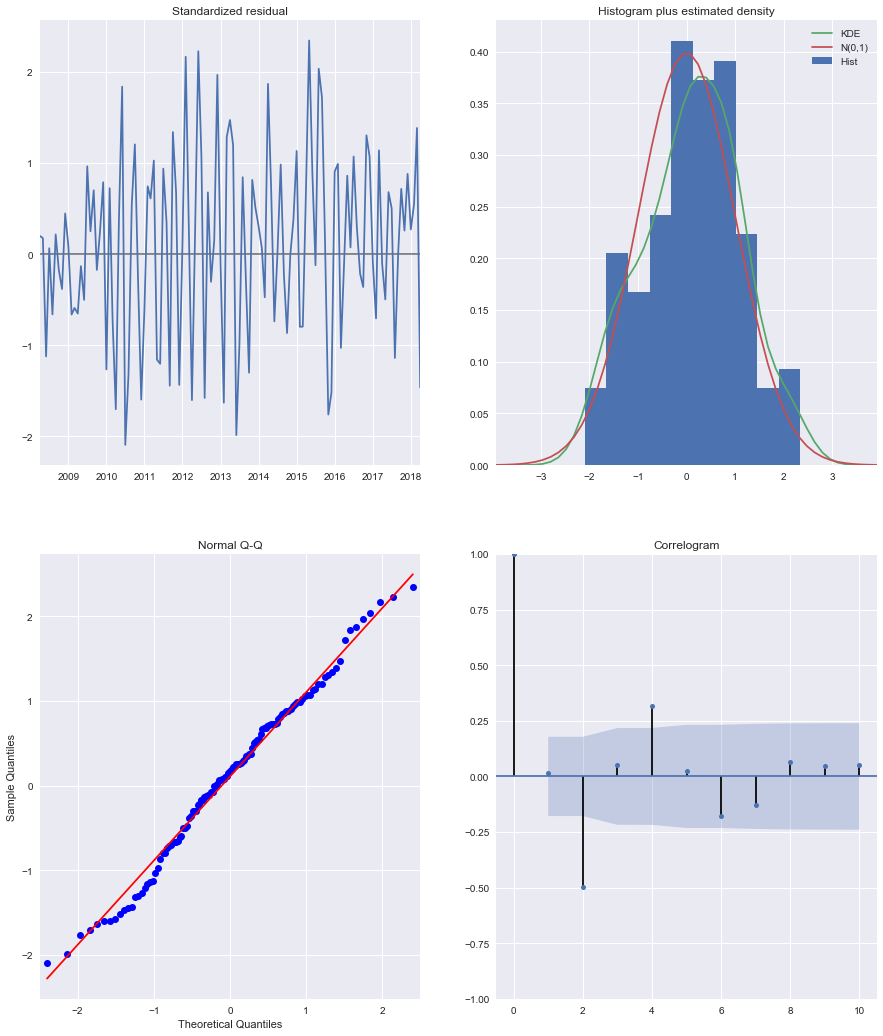

In [186]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [187]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

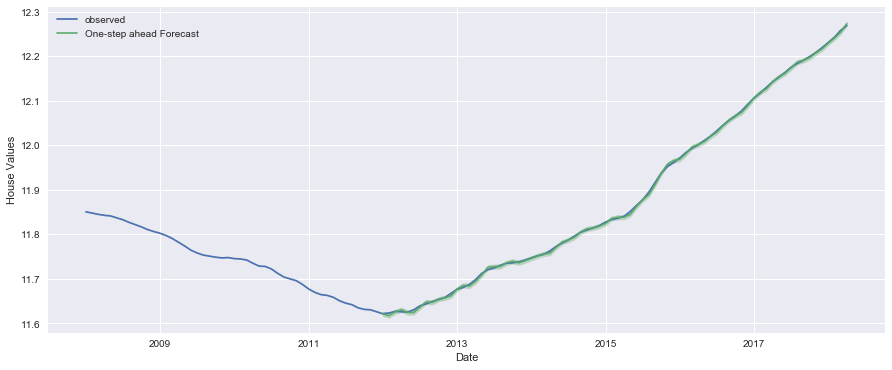

In [188]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_37217['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [189]:
#get the real and predicted values
nash_37217_forecasted = pred.predicted_mean
nash_37217_truth = log_37217['2012-01-01':].values

#compute the mean square error
rmse_37217 = np.sqrt(((nash_37217_forecasted - nash_37217_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_37217, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [190]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

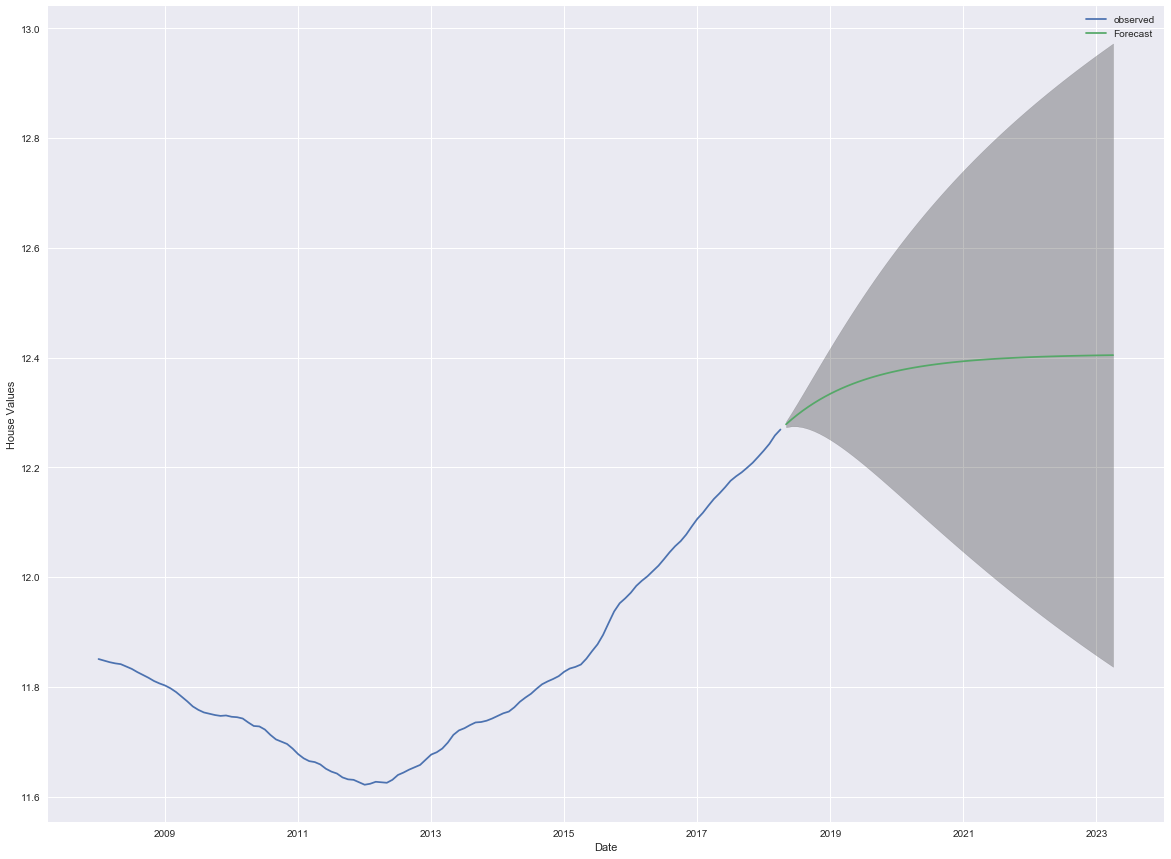

In [191]:
#plot future predictions with confidence intervals

ax = log_37217.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Nashville 37115

In [192]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_37115,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =956.0958504620852
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =862.8014678021985
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-186.6508148685047
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-212.11721782031628
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-205.93512982180636
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-219.48458757221994
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-268.9563195659965
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-262.7559858665182
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =787.0469226828022
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =847.7753422960299
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-330.0697863715595
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-339.71700910684166
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-213.36749983416752
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-189.18020340484526
ARIM

In [193]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 1)
PDQs    (0, 0, 0, 12)
AIC          -1022.58
Name: 56, dtype: object

In [194]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_37115,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8609      0.060     14.275      0.000       0.743       0.979
ma.L1          0.3953      0.101      3.930      0.000       0.198       0.592
sigma2      1.188e-05   1.63e-06      7.294      0.000    8.69e-06    1.51e-05


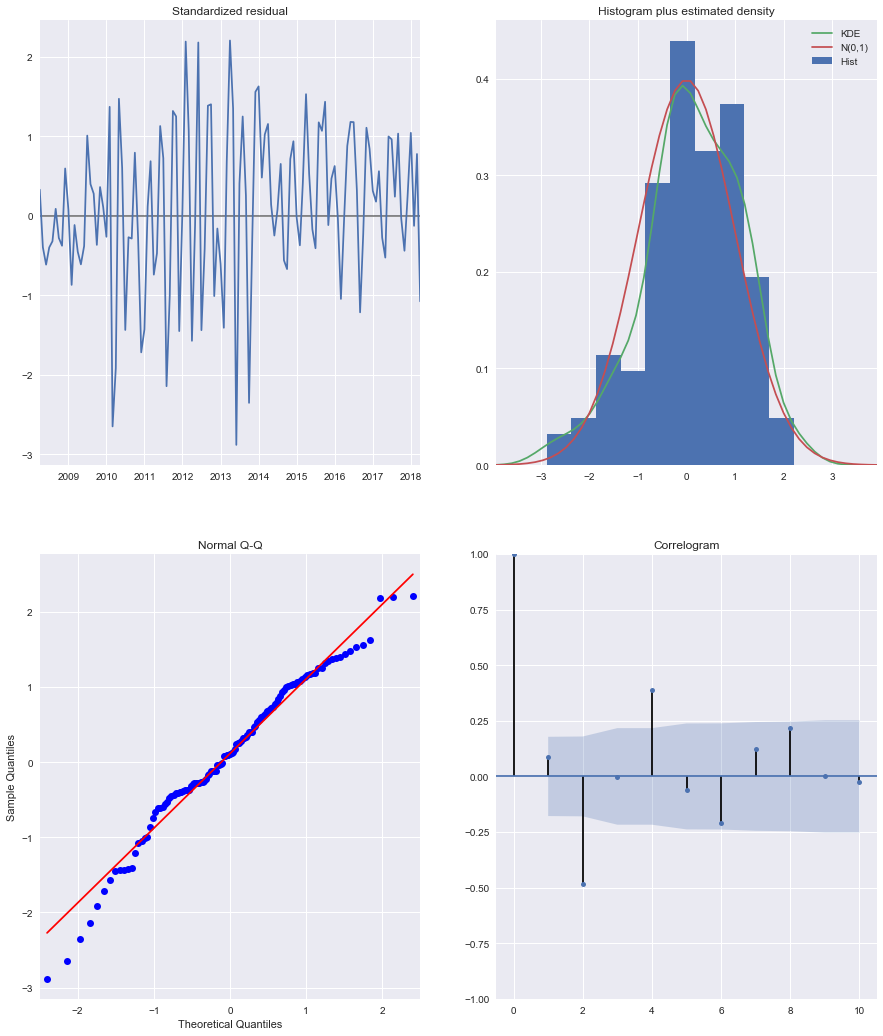

In [195]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [196]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

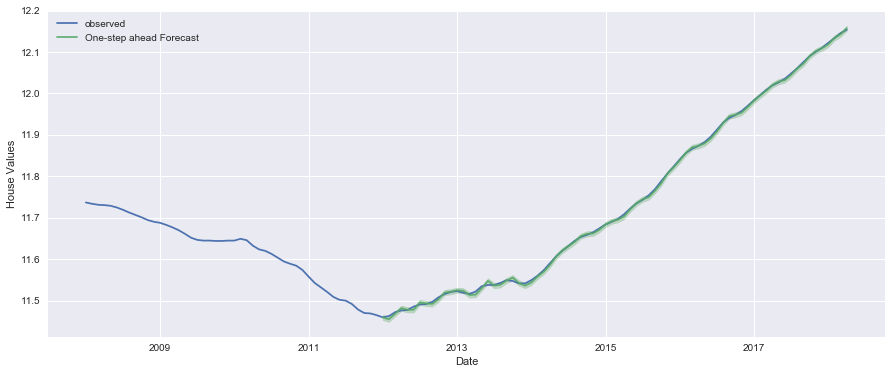

In [197]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_37115['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [198]:
#get the real and predicted values
nash_37115_forecasted = pred.predicted_mean
nash_37115_truth = log_37115['2012-01-01':].values

#compute the mean square error
rmse_37115 = np.sqrt(((nash_37115_forecasted - nash_37115_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_37115, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [199]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

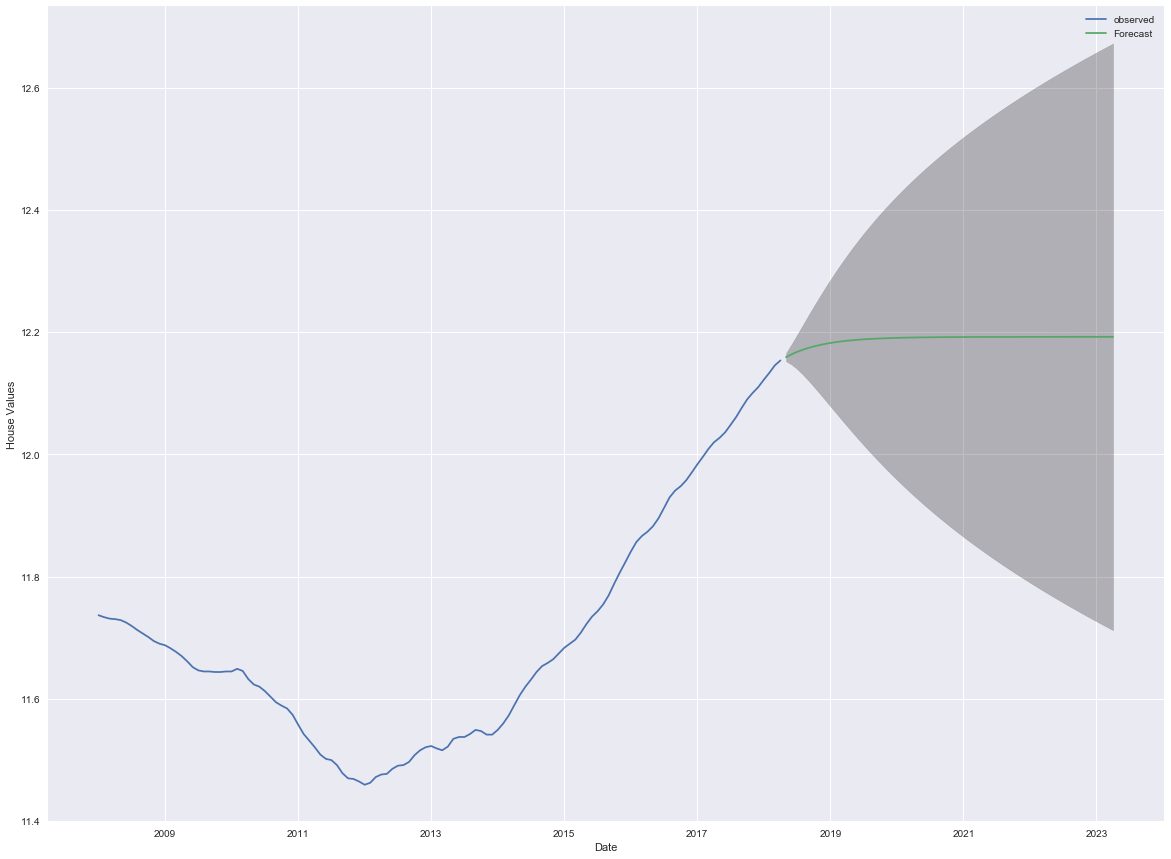

In [200]:
#plot future predictions with confidence intervals

ax = log_37115.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

# Nashville 37138

In [201]:
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_37138,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =962.2338054237146
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =870.211345367708
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-262.6217412904377
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-239.9382573435399
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-297.73944448158767
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-343.62215482798183
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-375.14501392191346
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-367.6787633987461
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =953.2768024859383
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =861.578149946431
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-405.17067497597253
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-306.33602231224
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-298.62408240412555
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-135.74281806802946
ARIMA (0

In [202]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

PDQ         (1, 1, 0)
PDQs    (0, 0, 0, 12)
AIC          -1157.32
Name: 48, dtype: object

In [203]:
#put the optimal parameters into the SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(log_37138,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9339      0.038     24.645      0.000       0.860       1.008
ma.L1          0.1797      0.095      1.885      0.059      -0.007       0.367
sigma2      4.175e-06   5.88e-07      7.100      0.000    3.02e-06    5.33e-06


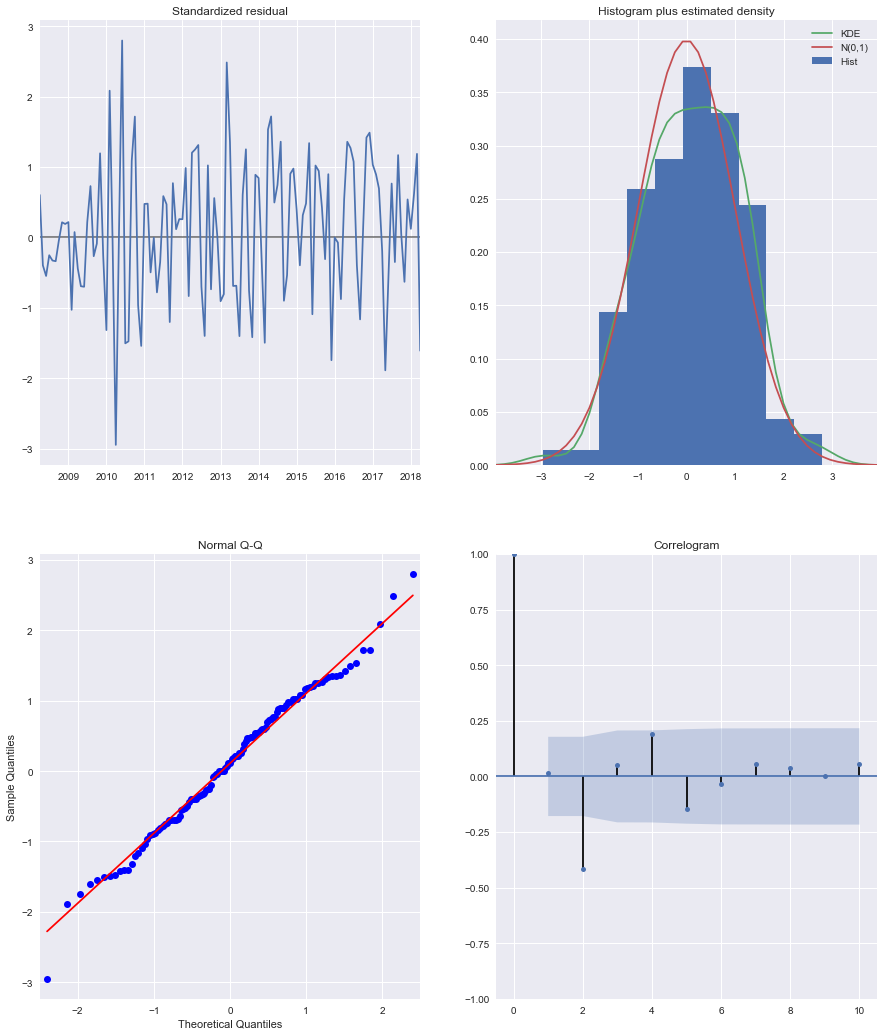

In [204]:
#use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [205]:
#get predictions starting from 2012-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

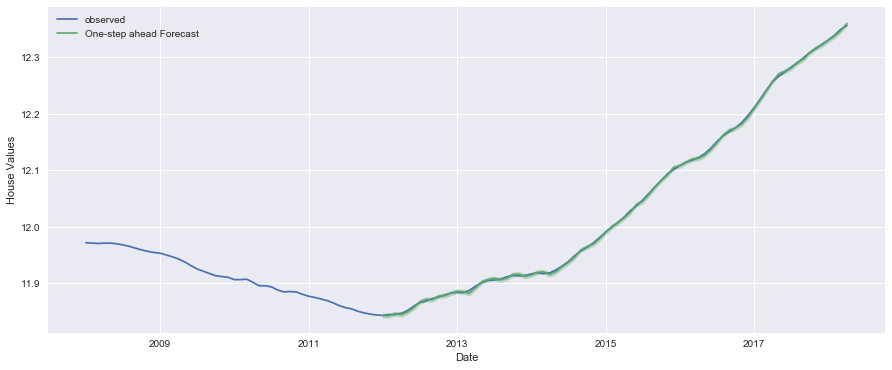

In [206]:
#plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

#plot observed values
ax = log_37138['2008-01-01':].plot(label='observed')

#plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

#set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Values')
plt.legend()

plt.show()

In [207]:
#get the real and predicted values
nash_37138_forecasted = pred.predicted_mean
nash_37138_truth = log_37138['2012-01-01':].values

#compute the mean square error
rmse_37138 = np.sqrt(((nash_37138_forecasted - nash_37138_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse_37138, 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [208]:
#get forecast 60 steps (5 years) ahead in future
prediction = output.get_forecast(steps=61)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

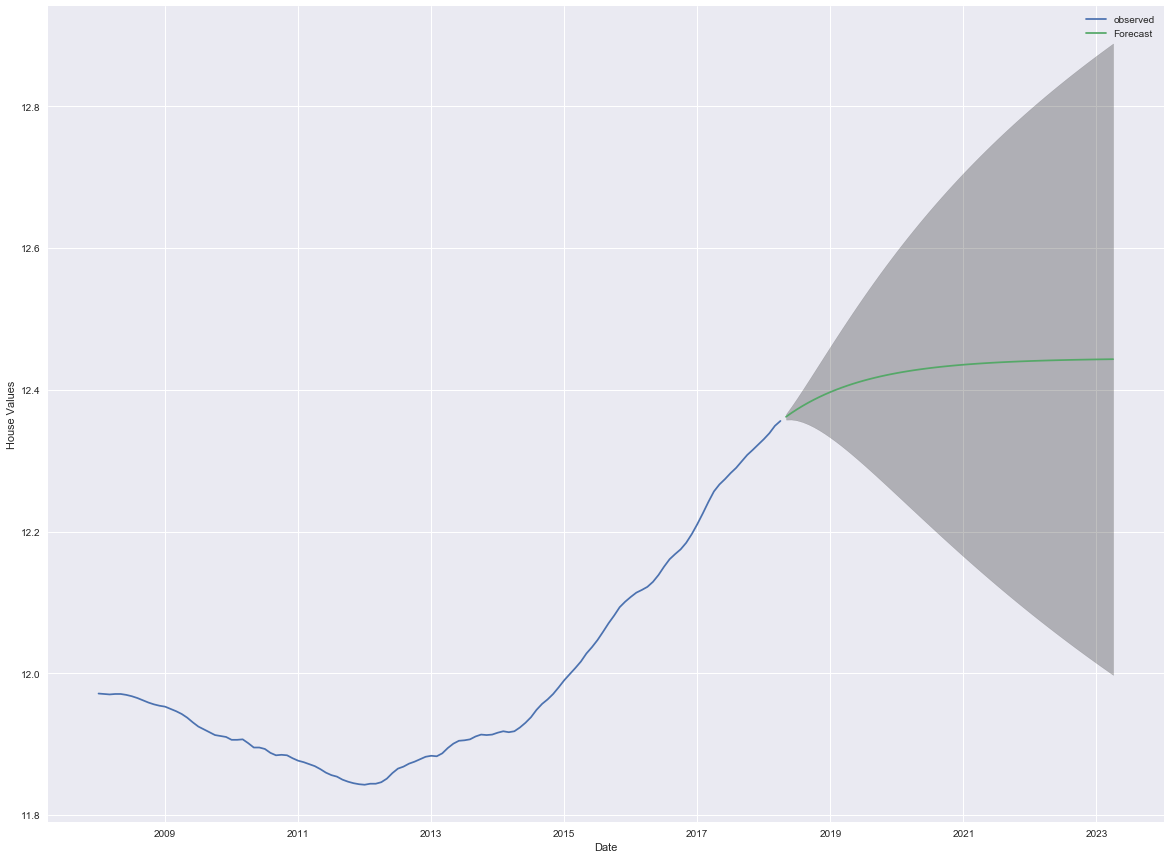

In [209]:
#plot future predictions with confidence intervals

ax = log_37138.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Values')

plt.legend()
plt.show()

## Interpreting Results

According to our models, we chose the following zipcodes because they exhibit high growth potential and a low amount of risk:

Raleigh-Durham:
* 27707
* 27704

Nashville:
* 37217
* 37138
* 37214

Our models show that these zipcodes forecast good returns for the 5 year period 2018-2023. Although Dallas-Fort Worth was the number 1 market in the Emerging Trends in Real Estate Guide, none of the zipcodes were in the top 5 for growth. 

## Recommendations

1. Select key investments in two cities: Raleigh-Durham and Nashville
2. Invest in 37138 and 27707 for investments above $150K
3. Invest in 37214, 37217 and 27704 for investments between $100K and $150K
4. Rehab and sell properties immediately for quick return on investment
5. Rent properties not sold within 30 days of completed renovation for a period of 3-5 years, depending on market conditions
    - Median monthly rent in Raleigh-Durham: $1400
    - Median monthly rent in Nashville: $1500

## Appendix

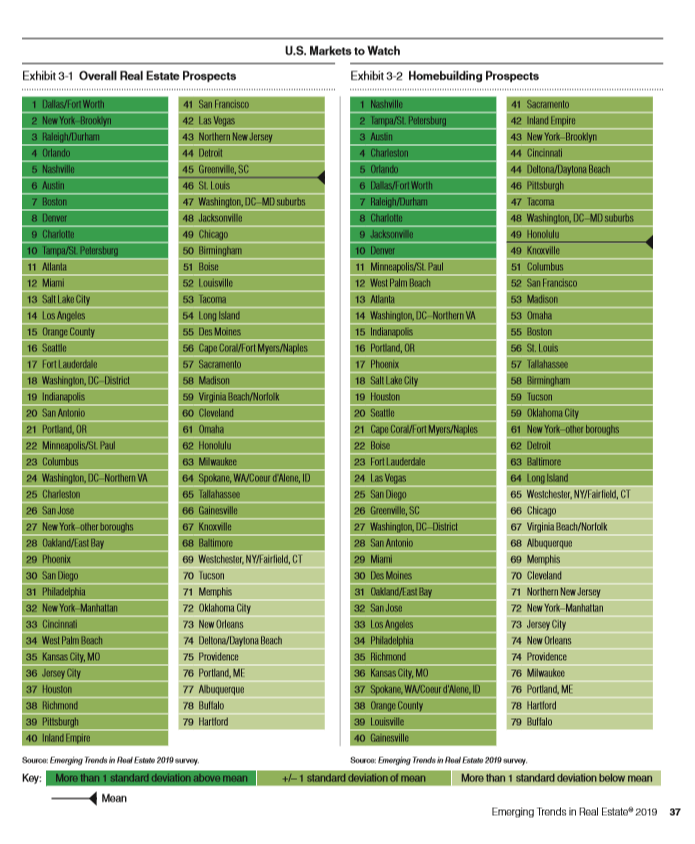

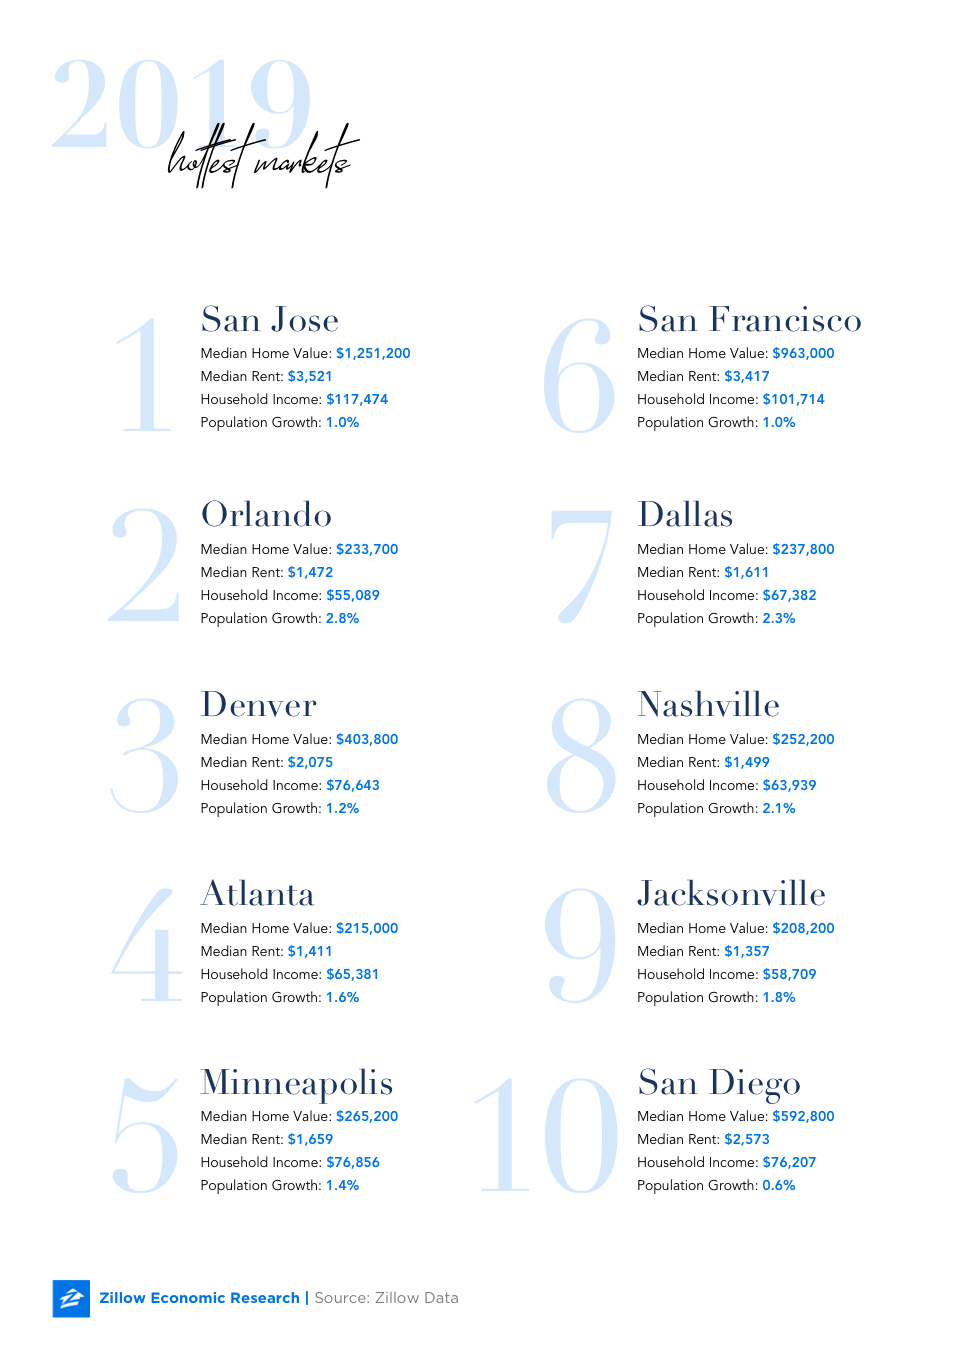